In [1]:
import os
import psutil
import random
from math import ceil, fsum
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import time

import json

from scipy.signal import find_peaks
from scipy.integrate import quad, simpson, trapezoid, IntegrationWarning
from scipy.optimize import curve_fit
from scipy.stats import cauchy
from scipy import interpolate

import joblib
from joblib import Parallel, delayed, parallel_backend

from tqdm.notebook import tqdm, trange
from tqdm.contrib import tenumerate

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from itertools import product, combinations
from collections import defaultdict

# Custom Exception Classes
class ParallelExecutionError(Exception):
    """Custom exception for parallel execution failures"""
    pass

class MemoryThresholdError(Exception):
    """Custom exception for memory threshold exceeded"""
    pass

global_filepath = './training_data/'
# Check if the folder exists
if not os.path.exists(global_filepath):
    # Create the folder
    os.makedirs(global_filepath)
    print(f"Folder '{global_filepath}' created.")
else:
    print(f"Folder '{global_filepath}' already exists.")

2025-07-26 20:08:49.570189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-26 20:08:49.584322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-26 20:08:49.600165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-26 20:08:49.604732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-26 20:08:49.617350: I tensorflow/core/platform/cpu_feature_guar

Folder './training_data/' already exists.


In [2]:
#define the functions to have different kinds of noise
##### Document Conventions #####
# omega = 2 pi f
#t = 1/f

# I utilize numba just in time compilation throughout the code to speed up computation. you can see the @nb.njit decorator on top of the functions

@nb.njit(parallel=False)
def noise_spectrum_1f(omega, A, alpha):
    '''
    Implements S(omega) = A/f^alpha
    Inputs: 
    omega: a numpy array of angular frequencies
    A: a numpy array amplitude of the noise spectrum
    alpha: a numpy array of the exponent of the noise spectrum
    Output:
    S(omega) = A / (omega ** alpha)
    '''
    return np.divide(A, np.power(omega, alpha))

# I'm using the scipy.stats.cauchy.pdf function to compute the Lorentzian distribution., instead of using numba jit, because I didn't see much impact 
# on the performance of the function. The scipy function should be more stable and has better numerical precision, but I have also provided a numba implementation
# that should do the same thing (but please check).
def noise_spectrum_lor(omega, omega_0, gamma,A):
    '''
    Implements S(omega) = A * (1/(pi*gamma(1+((omega-omega_0)/gamma)**2)))
    Inputs:
    omega: a numpy array of angular frequencies
    omega_0: a float of the central frequency
    gamma: a float of the half width at half maximum
    A: a float of the amplitude of the noise spectrum
    Output:
    S(omega): a numpy array
    '''
    return np.multiply(A,cauchy.pdf(omega, loc=omega_0, scale=gamma))

# @nb.njit(parallel=False)
# def noise_spectrum_lor(omega, omega_0, gamma,A):
#     '''
#     Implements S(omega) = A * (1/(pi*gamma(1+((omega-omega_0)/gamma)**2)))
#     Inputs:
#     omega: a numpy array of angular frequencies
#     omega_0: a float of the central frequency
#     gamma: a float of the half width at half maximum
#     A: a float of the amplitude of the noise spectrum
#     Output:
#     S(omega): a numpy array
#     '''
#     # Preallocate the result array
#     result = np.empty_like(omega, dtype=np.float64)
    
#     # Compute Lorentzian (Cauchy) distribution manually
#     for i in range(len(omega)):
#         # Equivalent to scipy.stats.cauchy.pdf(x, loc=omega_0, scale=gamma)
#         result[i] = A / (np.pi * gamma * (1 + ((omega[i] - omega_0) / gamma)**2))
    
#     return result

@nb.njit(parallel=False)
def noise_spectrum_white(omega, C):
    '''Implements S(omega)
    Handles omega as numpy array, list, or single number
    Always returns a numpy array
    '''
    if isinstance(omega, (int, float)):
        return np.array([C])
    else:
        return np.full(len(omega), C)

def noise_spectrum_combination(omega,f_params,lor_params,white_params):
    '''Implements the combination of noise spectra
    Inputs:
    omega: a numpy array of angular frequencies
    f_params: a dictionary of the parameters for the 1/f noise spectrum. {"alpha": [1,2], "A": [1,2]}
    lor_params: a dictionary of the parameters for the Lorentzian noise spectrum. {"omega_0": [1,2,3], "gamma": [1,2,3], "A": [1,2,3]}
    white_params: a dictionary of the parameters for the white noise spectrum. {"C": [1]}
    Output:
    S(omega): a numpy array
    '''

    noise_specturm_list = []

    for i,my_dict in enumerate([f_params, lor_params, white_params]):

        if bool(my_dict) == True:
            for key,value in my_dict.items():
                if type(value) is int:
                    my_dict[key] = [value]

            first_length = len(next(iter(my_dict.values())))
            all_same_length = all(len(lst) == first_length for lst in my_dict.values())

            if not all_same_length:
                    raise ValueError('All the parameters in the dictionary must have the same length.')
        else:
            first_length = 0
        
        # if (my_dict == f_params and i==0):
        if i == 0:
            if first_length != 0:
                f_values  = list(zip(my_dict["A"], my_dict["alpha"]))
                for A, alpha in f_values:
                    noise_specturm_list.append(noise_spectrum_1f(omega, A, alpha))
            else:
                # print(f'{f_params=}'.split('=')[0] + " dictionary is empty. Assuming there is no 1/f noise persent.")
                pass
        # elif (my_dict == lor_params and i==1):
        elif i== 1:
            if first_length != 0:
                lor_values = list(zip(my_dict["omega_0"], my_dict["gamma"], my_dict["A"]))
                for omega_0, gamma, A in lor_values:
                    noise_specturm_list.append(noise_spectrum_lor(omega, omega_0, gamma, A))
            else:
                # print(f'{lor_params=}'.split('=')[0] + " dictionary is empty. Assuming there is no Lorentzian noise persent.")
                pass
        # elif (my_dict == white_params and i==2):
        elif i ==2:
            if first_length != 0:
                white_values = my_dict["C"]
                for C in white_values:
                    noise_specturm_list.append(noise_spectrum_white(omega, C))
            else:
                # print(f'{white_params=}'.split('=')[0] + " dictionary is empty. Assuming there is no white noise persent.")
                pass


    # If there are numerical issues, try increasing the precision of the dtype (e.g. np.float64). If that doesn't work, try using math.fsum.
    #  You'll have to write a custom function like precise_complex_sum above, which handles complex arrays.
    noise_specturm = np.sum(np.array(noise_specturm_list),axis=0)

    return noise_specturm

# define the function to compute coherence decay using a delta function approximation
@nb.njit(parallel=False)
def coherence_decay_profile_delta(t,noise_profile):
    """
    Calculate the coherence decay profile based on the provided formula, e**(-chi(t)),
    uder the assumption that the filter function is a delta function.
    Inputs:
    noise_profile: a function that implements the noise spectrum, S(omega)
    t: a float of the time variable
    Output:
    e**(-chi(t))
    """
    # noise_profile = noise_spectrum_1f(np.pi/t, A, alpha)
    chi_t = t*noise_profile/np.pi
    return np.exp(-chi_t)

@nb.njit(parallel=False)
def filter_function_approx(omega, N, T):
    '''Implemnents an approximation of the filter function, F(omega*t) (eq #2 in [Meneses,Wise,Pagliero,et.al. 2022]).
    Approximation assumes pi-pulse are instantaneous (i.e. tau_pi = 0). Note, this function has singular points at (2m+1)n*Pi/t for integer m.
    Inputs:
    omega: a numpy array of angular frequencies
    N: a float of the number of pulses
    T: a float of the total time of the experiment
    Output:
    F(omega*t): a numpy array
    '''
    if not isinstance(N, int):
        raise TypeError(f"N must be an integer, got {type(N).__name__}")
    
    if N % 2 == 0:
        return 16 * (np.sin((omega*T) / 2) ** 2) * (np.sin((omega*T)/(4*N))**4) / (np.cos((omega*T)/(2*N))**2)
    else:
        return 16 * (np.cos((omega*T) / 2) ** 2) * (np.sin((omega*T)/(4*N))**4) / (np.cos((omega*T)/(2*N))**2)

@nb.njit(parallel=False)
def numba_complex_sum(t_k, omega):
    result = np.zeros_like(omega, dtype=np.complex128)
    for i in range(len(omega)):
        for k in range(len(t_k)):
            result[i] += ((-1)**(k+1))*np.exp(1j * omega[i] * t_k[k])
    return result

def filter_function_finite(omega, N, T, tau_p, method='numba'):
    ''' Implements the filter function, F(omega*t) (eq #1 in the paper).
    Inputs:
    omega: a numpy array of angular frequencies
    N: a float of the number of pulses
    T: a float of the total time for the experiment
    tau_p: a float of the pulse width
    Output:
    F(omega*t): a numpy array
    '''
    # Convert single number to array if needed
    single_number = isinstance(omega, (int, float))
    if single_number:
        omega = np.array([omega])

    if T < N * tau_p:
        raise ValueError("The total time of the experiment is less than the total time of the pulses.")
    else:
        # t_k = np.linspace((T/N-tau_p)/2, T*(1-1/(2*N))-(tau_p/2), N)  # Pulses are evenly spaced. This is the time of beginning of each pulse.
        t_k = T/(2*N)*np.arange(1,2*N+1,2) # Pulses are evenly spaced. This is the middle of the each pulse. Alternatively, np.linspace((T/N)/2, T*(1-1/(2*N)), N)
        if (t_k<0).any():
            raise ValueError("One of the Pulse start times is negative. This is not allowed.")
        
    if method == 'numba':
        # Uses numba to speed up the sum. Should be the fastest implementation.
        # Doesn't store the intermediate results, so it's memory efficient.
        sum_term = numba_complex_sum(t_k, omega)
    elif method == 'numpy_array':
        # Uses numpy array broadcasting to vectorize the sum. 
        # A little faster that a summation loop, and more numerically stable, but has a higher memory overhead. 
        sum_array = np.exp(1j * omega[:, np.newaxis] * t_k)
        sum_array[:,::2] *= -1 # Adds negative sign to odd indices of t_k
        # sum_array.sort(axis=1)
        sum_term = np.sum(sum_array, axis=1)
    elif method == "numpy":
        # Uses a for loop to sum the terms. Slowest implementation, but most more memory efficient than the array version.
        # You can instead sum the positive and negative terms separately, then subtract them, for a slightly more numerically stable result.

        # neg_sum_term = np.zeros(omega.shape)
        # pos_sum_term = np.zeros(omega.shape)
        # for k in range(0,N,2):
        #     # neg_sum_term = neg_sum_term - np.exp(1j * omega * t_k[k])
        #     neg_sum_term = np.sum(np.vstack((neg_sum_term,np.exp(1j * omega * t_k[k]))),axis=0)
            
        # for k in range(1,N+1,2):
        #     # pos_sum_term = pos_sum_term + np.exp(1j * omega * t_k[k])
        #     pos_sum_term = np.sum(np.vstack((pos_sum_term,np.exp(1j * omega * t_k[k]))),axis=0)

        # sum_term = (pos_sum_term-neg_sum_term)
            
        sum_term = np.zeros(omega.shape,dtype=np.complex128)
        for k in range(N):
            sum_term += (-1)**(k+1) * np.exp(1j * omega * t_k[k])
    
    result = np.power(np.abs(1 + np.power(-1,N+1) * np.exp(1j * omega * T) + 2 * np.cos(omega * tau_p / 2) * sum_term),2)
    
    return result

In [3]:
o = np.linspace(0, 1e4, 1000)
N = 2
tau_p = 0.024
T = N*tau_p+tau_p

if N==1:
    st = -np.exp(1j*o*T/2)
elif N==2:
    st = -np.exp(1j*o*T/4)+np.exp(1j*o*3*T/4)

print(np.all(np.isclose(filter_function_finite(o, N, T, tau_p, method='numba'), filter_function_finite(o, N, T, tau_p, method='numpy_array'))))
print(np.all(np.isclose(filter_function_finite(o, N, T, tau_p, method='numba'), filter_function_finite(o, N, T, tau_p, method='numpy'))))
print(np.all(np.isclose(filter_function_finite(o, N, T, tau_p, method='numba'),np.abs(1+(-1)**(N+1)*np.exp(1j*o*T)+2*st*np.cos(o*tau_p/2))**2)))

print(np.all(np.isclose(np.linspace((T/N)/2, T*(1-1/(2*N)), N),T/(2*N)*np.arange(1,2*N+1,2))))

True
True
True
True


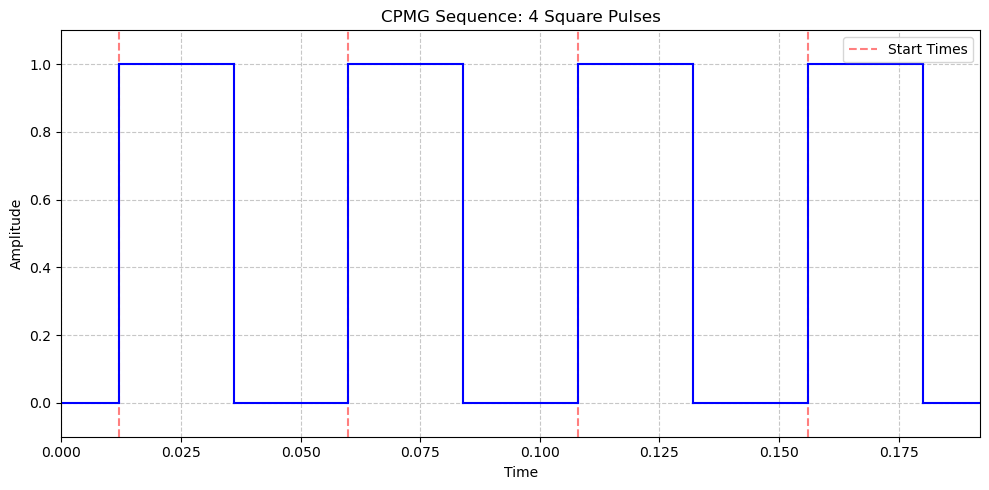

True
True
True
[0.125 0.375 0.625 0.875]


In [4]:
# See the  cpmg pulse sequence 

def plot_square_pulses(t_k, n, tau_p, total_time=None):
    """
    Plot n square pulses of length tau_p that begin at each t_k.
    
    Parameters:
    -----------
    t_k : array-like
        Array of start times for each pulse
    n : int
        Number of pulses to plot
    tau_p : float
        Duration of each square pulse
    total_time : float, optional
        Total time range for the plot. If None, calculated from t_k and tau_p
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    # Ensure t_k is a NumPy array and take first n elements
    t_k = np.asarray(t_k)[:n]
    
    # Determine plot time range if not specified
    if total_time is None:
        total_time = np.max(t_k + tau_p) * 1.1
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot vertical dashed lines at each t_k before square pulses
    for start_time in t_k:
        ax.axvline(x=start_time, color='r', linestyle='--', alpha=0.5, label='Start Times' if start_time == t_k[0] else "")

    ax.plot([0, t_k[0]], [0, 0], 'b-')  # Initial flat line
    ax.plot([t_k[-1]+tau_p, total_time], [0, 0], 'b-') 
    
    # Plot each square pulse
    for i,start_time in enumerate(t_k):
        ax.plot([start_time, start_time], [0, 1], 'b-')  # Rising edge
        ax.plot([start_time + tau_p, start_time + tau_p], [1, 0], 'b-')  # Falling edge
        ax.plot([start_time, start_time + tau_p], [1, 1], 'b-')  # Top of pulse
        if i < n-1:
            ax.plot([start_time + tau_p, t_k[i+1]], [0, 0], 'b-')

    
    # Set plot details
    ax.set_xlim(0, total_time)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title("CPMG Sequence: " + f'{n} Square Pulses')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend for start times
    ax.legend()
    
    plt.tight_layout()
    return fig

N = 4
tau_p = 0.024
wait_time = 0.024
# T = N*(tau_p + time between pulses)
T = N*(tau_p+wait_time)

t_k = np.linspace((T/N-tau_p)/2, T*(1-1/(2*N))-(tau_p/2), N)


# Create and show the plot
fig = plot_square_pulses(t_k, N, tau_p, total_time=T)
plt.show()

# Check the time points To make sure they are correct
print(t_k[0] == (T/N-tau_p)/2)
print(t_k[-1] == T*(1-1/(2*N))-(tau_p/2))
holder = []
for i in range(N-1):
    holder.append(np.isclose(t_k[i] + tau_p + wait_time, t_k[i+1]))
print(all(holder))

t_center = np.linspace((T/N)/2, T*(1-1/(2*N)), N)
# print(T)
# print(t_center)
print(t_center/T)

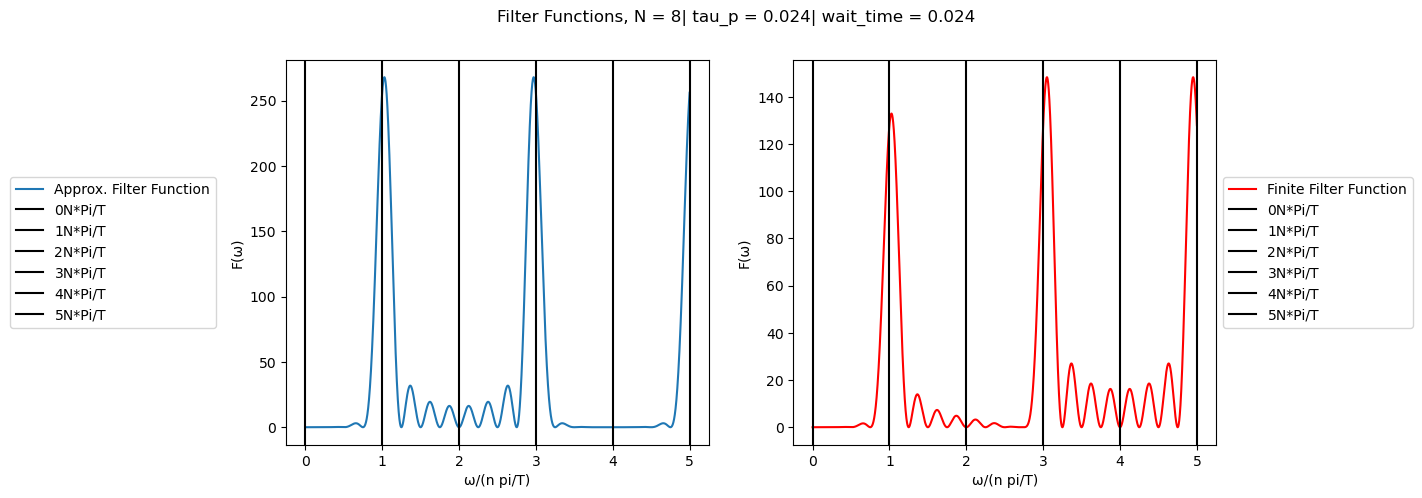

Approx. FF / Finite FF
Mean:  216631.42853013132
Standard Deviation:  126953708.3400941
Max Ratio:  1.8059580303575817


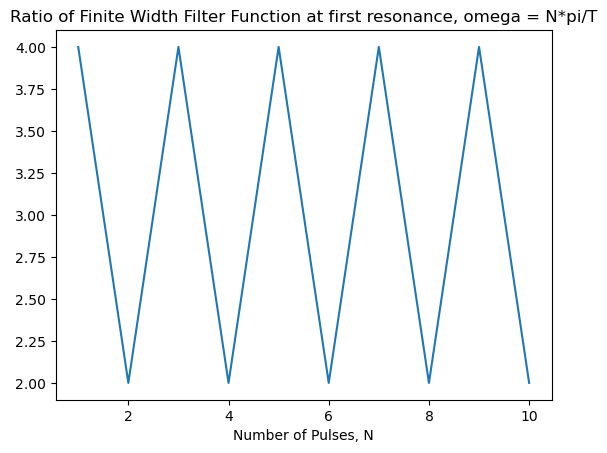

<Figure size 1200x500 with 0 Axes>

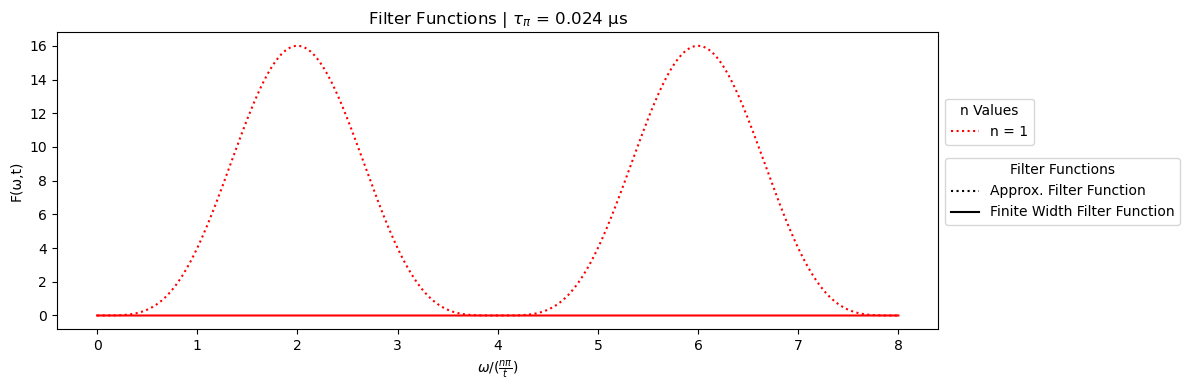

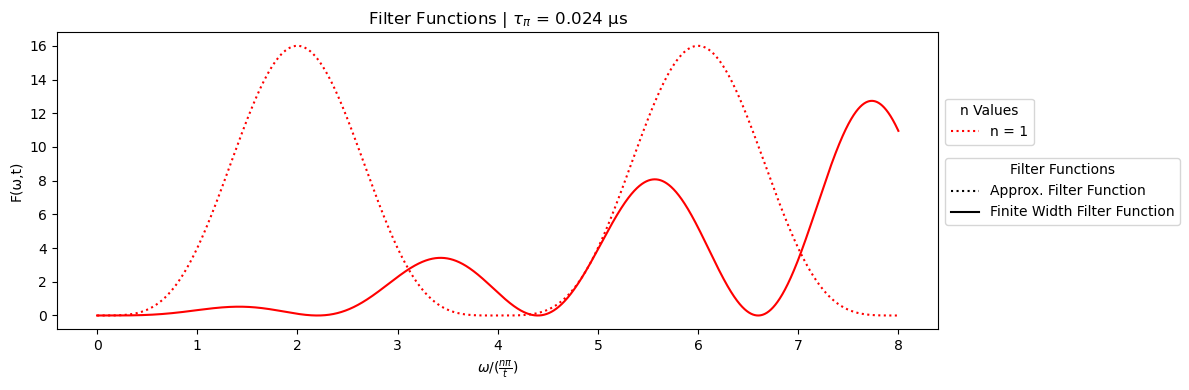

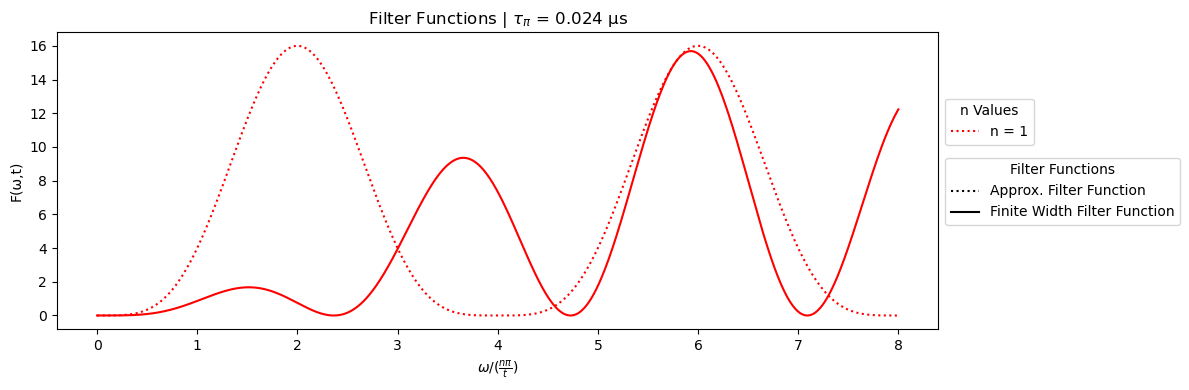

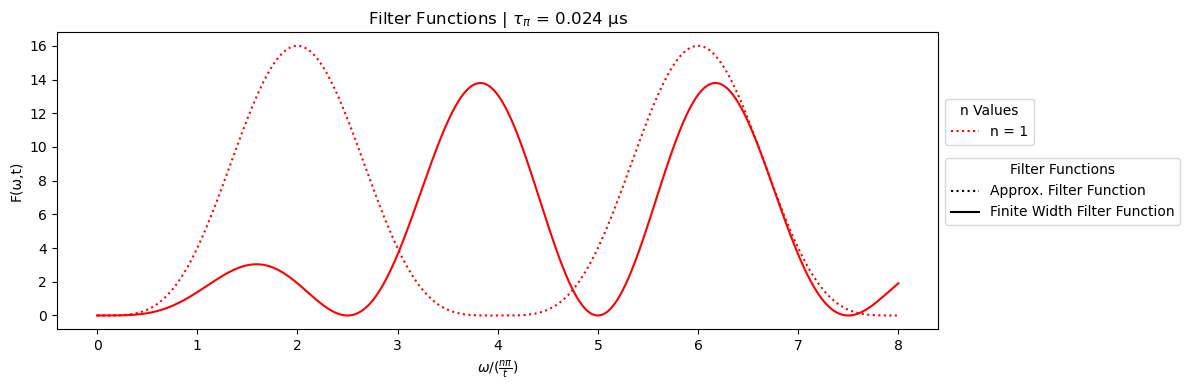

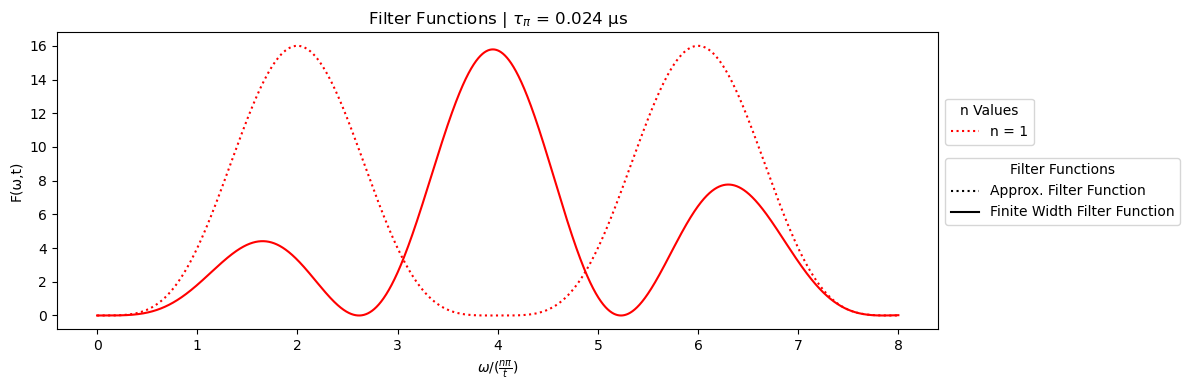

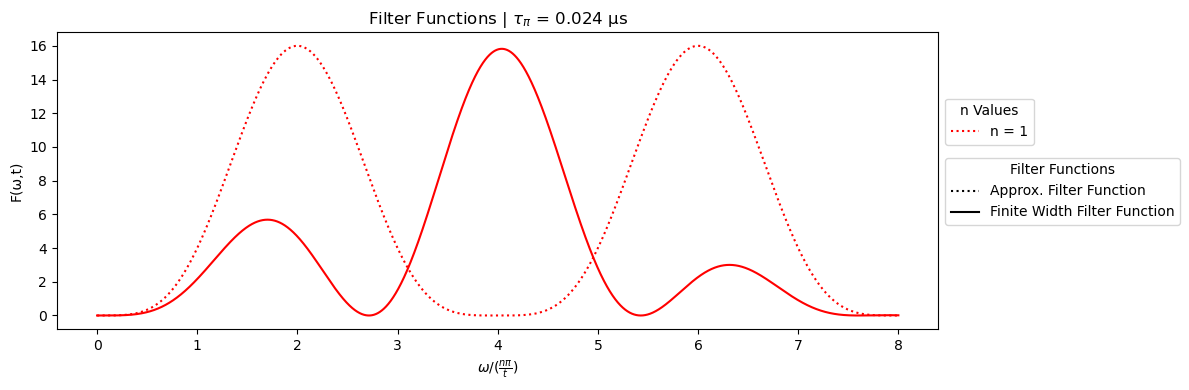

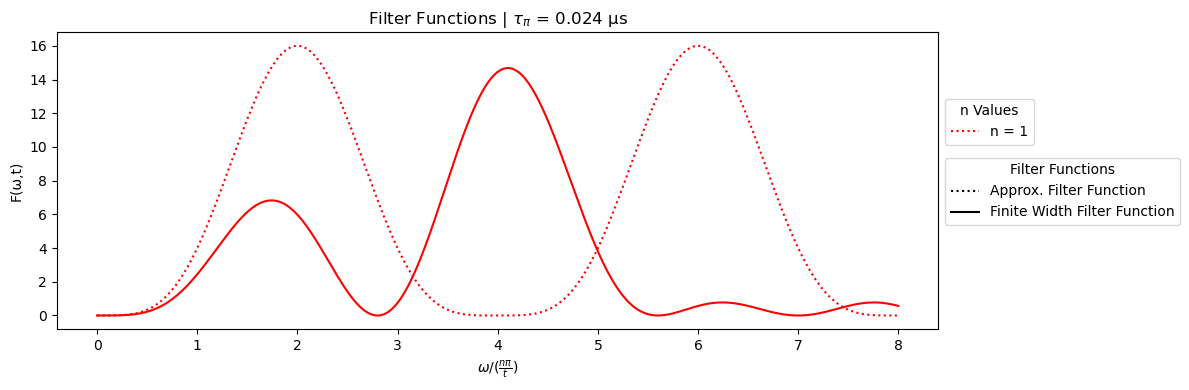

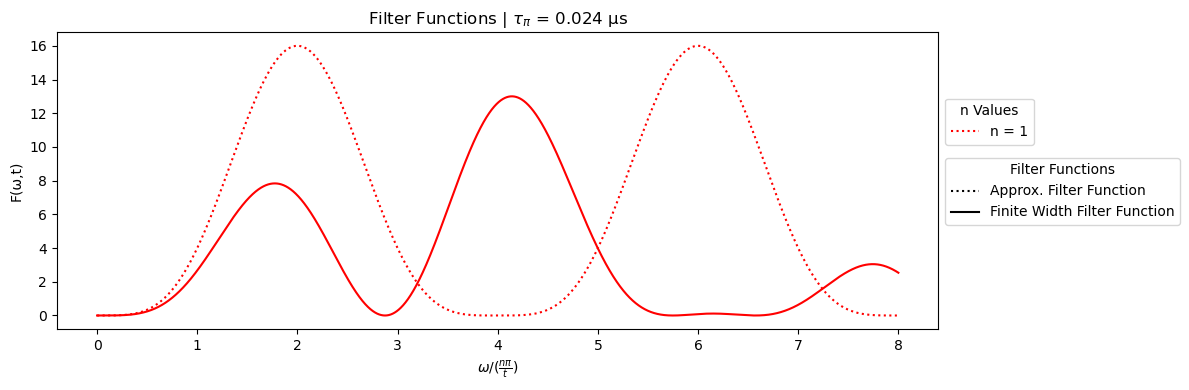

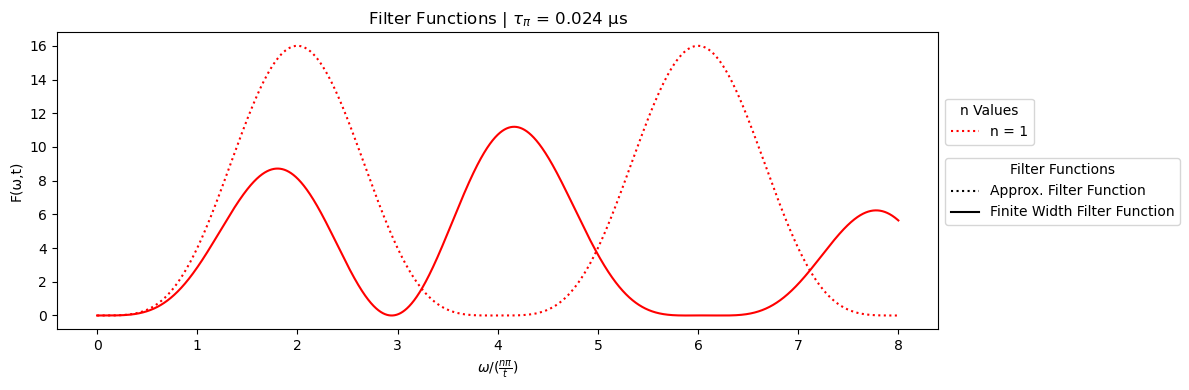

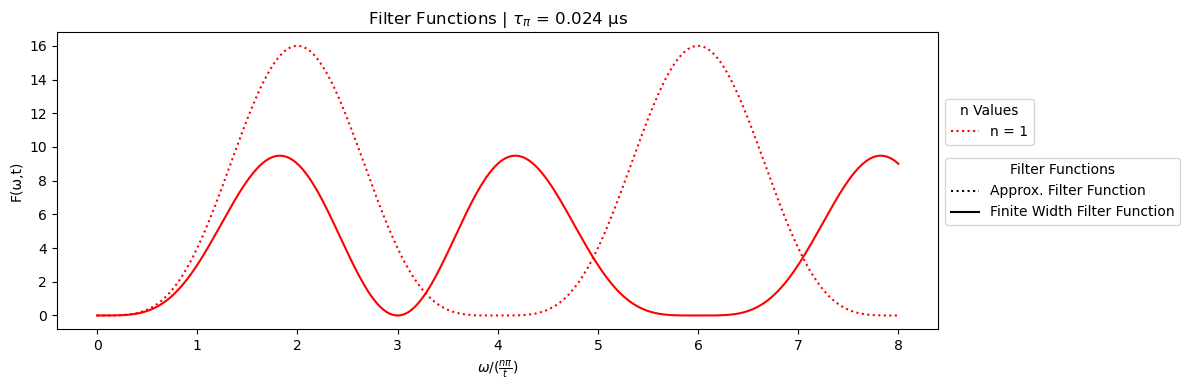

In [26]:
# compare Filter functions 3/6/2025
N = 8
tau_p = 0.024
wait_time = 0.024
T = N*(tau_p+wait_time)
first_resonance = np.pi * N / T
# first_resonance = 1

num_resonances = 2
omega = np.linspace(10**-2, (2*num_resonances+1)*first_resonance, 10**6)
# omega = np.logspace(-4, 8, 10**6)

fig = plt.figure(num=0, figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_ylabel('F(ω)')
ax1.set_xlabel('ω/(n pi/T)')
# ax1.set_xscale('log')
# ax1.set_yscale('log')

ax2.set_ylabel('F(ω)')
ax2.set_xlabel('ω/(n pi/T)')
# ax2.set_xscale('log')
# ax2.set_yscale('log')

plot_me1 = filter_function_approx(omega, N, T)
plot_me2 = filter_function_finite(omega, N, T, tau_p, method='numba')

ax1.plot(omega/first_resonance, plot_me1, label='Approx. Filter Function')
for i in range(2*(num_resonances+1)):
    ax1.axvline(x=i, color='black', label=str(i)+'N*Pi/T')
# Put a legend below current axis
ax1.legend(loc='center right', bbox_to_anchor=(-0.15, 0.5))

ax2.plot(omega/first_resonance, plot_me2,color="r", label='Finite Filter Function')
for i in range(2*(num_resonances+1)):
    ax2.axvline(x=i, color='black', label=str(i)+'N*Pi/T')
# Put a legend below current axis
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Filter Functions, N = '+ str(N)+"| tau_p = "+str(tau_p)+"| wait_time = "+str(wait_time))
plt.show()

print("Approx. FF / Finite FF")
print("Mean: ",np.mean(plot_me1/plot_me2))
print("Standard Deviation: ",np.std(plot_me1/plot_me2))
print("Max Ratio: ",np.max(plot_me1)/np.max(plot_me2))

filter_function_approx(omega, n, T)

R = np.empty(10)
for N in range(1,len(R)+1):
    tau_p = 0.024
    wait_time = 0.024
    T = N*(tau_p+wait_time)
    if N % 2 == 0:
        # R[N-1] = filter_function_finite(N*np.pi/T, N, T, 0, method='numba')[0]/filter_function_finite(N*np.pi/T, N, T, tau_p, method='numba')[0]
        R[N-1] = filter_function_approx(N*np.pi/T, N, T)/filter_function_finite(N*np.pi/T, N, T, tau_p, method='numba')[0]
    else:
        # R[N-1] = filter_function_finite(2*N*np.pi/T, N, T, 0, method='numba')[0]/filter_function_finite(2*N*np.pi/T, N, T, tau_p, method='numba')[0]
        R[N-1] = filter_function_approx(2*N*np.pi/T, N, T)/filter_function_finite(2*N*np.pi/T, N, T, tau_p, method='numba')[0]

plt.plot(range(1,len(R)+1),R)
plt.xlabel('Number of Pulses, N')
plt.title('Ratio of Finite Width Filter Function at first resonance, omega = N*pi/T')
plt.show()

colors = ['red', 'blue', 'green', 'purple', 'orange']
fig2 = plt.figure(num=2, figsize=(12, 5))


# Create black lines for filter function legend (these won't be plotted yet)
approx_black_line = plt.Line2D([0], [0], color='black', linestyle=':', label='Approx. Filter Function')
finite_black_line = plt.Line2D([0], [0], color='black', linestyle='-', label='Finite Filter Function')
filter_handles = [approx_black_line, finite_black_line]
filter_labels = ['Approx. Filter Function', 'Finite Width Filter Function']

tau_p = 0.024
for wait_time in np.linspace(0,2*tau_p,10):  # You can change the wait_time here
    plt.figure(figsize=(12,4))
    # Create empty lists to store handles and labels for N values
    n_handles, n_labels = [], []
    for i, n in enumerate([1]):
        color = colors[i % len(colors)]
        T = n*(tau_p+wait_time)
        first_resonance = np.pi * n / T
        # first_resonance = 1
        num_resonances = 4
        omega = np.linspace(10**-2, (2*num_resonances)*first_resonance, 10**6)
        # omega = np.logspace(-4, 8, 10**6)
        
        plot_me1 = filter_function_approx(omega, n, T)
        plot_me2 = filter_function_finite(omega, n, T, tau_p, method='numba')
        
        # Plot with color but don't add to combined legend
        approx_line = plt.plot(omega/first_resonance, plot_me1, color=color, linestyle=":")[0]
        finite_line = plt.plot(omega/first_resonance, plot_me2, color=color, linestyle="-")[0]
        
        # Add to N values legend
        n_handles.append(approx_line)  # We only need one line per N value for the N legend
        n_labels.append(f"n = {n}")

    # Adjust subplot position to make room for legends
    plt.subplots_adjust(right=0.75)

    plt.ylabel('F(ω,t)')
    # plt.xlabel('ω/(n π/t)')
    plt.xlabel(r'$\omega / (\frac{n \pi}{t})$')
    # plt.xlabel(r'$\sin (x)$')

    # Create the first legend for N values (colors)
    n_legend = plt.legend(n_handles, n_labels, 
                        loc='upper left', 
                        bbox_to_anchor=(1, 0.8),
                        title="n Values")

    # Create the second legend for filter function types (line styles)
    filter_legend = plt.legend(filter_handles, filter_labels, 
                                  loc='upper left', 
                                  bbox_to_anchor=(1, 0.6),
                            title="Filter Functions")

    # Add both legends to the figure
    plt.gca().add_artist(n_legend)
    plt.title("Filter Functions | "+r"$\tau_\pi$"+" = "+str(tau_p)+" μs")
    plt.tight_layout()
    plt.show()

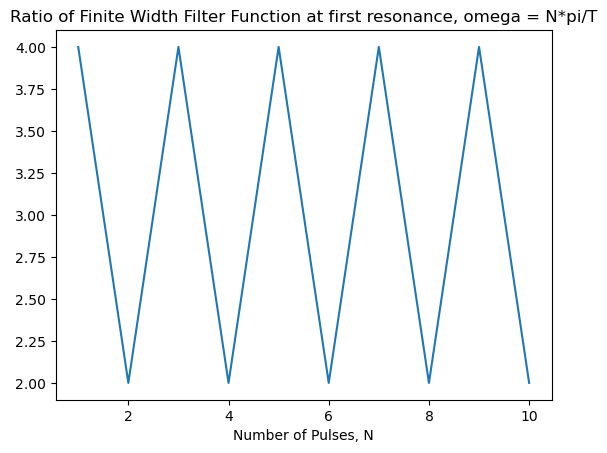

/tmp/ipykernel_159914/4113780522.py:71: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


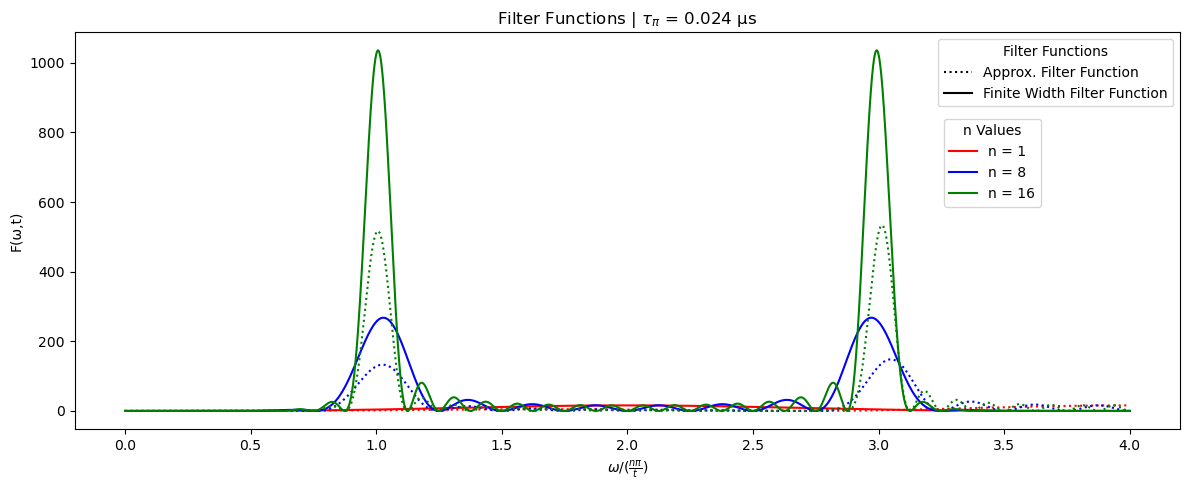

In [9]:
R = np.empty(10)
for N in range(1,len(R)+1):
    tau_p = 0.024
    wait_time = 0.024
    T = N*(tau_p+wait_time)
    if N % 2 == 0:
        R[N-1] = filter_function_finite(N*np.pi/T, N, T, 0, method='numba')[0]/filter_function_finite(N*np.pi/T, N, T, tau_p, method='numba')[0]
    else:
        R[N-1] = filter_function_finite(2*N*np.pi/T, N, T, 0, method='numba')[0]/filter_function_finite(2*N*np.pi/T, N, T, tau_p, method='numba')[0]

plt.plot(range(1,len(R)+1),R)
plt.xlabel('Number of Pulses, N')
plt.title('Ratio of Finite Width Filter Function at first resonance, omega = N*pi/T')
plt.show()

colors = ['red', 'blue', 'green', 'purple', 'orange']
fig2 = plt.figure(num=2, figsize=(12, 5))

# Create empty lists to store handles and labels for N values
n_handles, n_labels = [], []

# Create black lines for filter function legend (these won't be plotted yet)
approx_black_line = plt.Line2D([0], [0], color='black', linestyle=':', label='Approx. Filter Function')
finite_black_line = plt.Line2D([0], [0], color='black', linestyle='-', label='Finite Filter Function')
filter_handles = [approx_black_line, finite_black_line]
filter_labels = ['Approx. Filter Function', 'Finite Width Filter Function']

for i, n in enumerate([1,8,16]):
    color = colors[i % len(colors)]
    T = n*(tau_p+wait_time)
    first_resonance = np.pi * n / T
    # first_resonance = 1
    num_resonances = 2
    omega = np.linspace(10**-2, (2*num_resonances)*first_resonance, 10**6)
    # omega = np.logspace(-4, 8, 10**6)
    
    plot_me1 = filter_function_approx(omega, n, T)
    plot_me2 = filter_function_finite(omega, n, T, tau_p, method='numba')
    
    # Plot with color but don't add to combined legend
    approx_line = plt.plot(omega/first_resonance, plot_me1, color=color, linestyle="-")[0]
    finite_line = plt.plot(omega/first_resonance, plot_me2, color=color, linestyle=":")[0]
    
    # Add to N values legend
    n_handles.append(approx_line)  # We only need one line per N value for the N legend
    n_labels.append(f"n = {n}")

# Adjust subplot position to make room for legends
plt.subplots_adjust(right=0.75)

plt.ylabel('F(ω,t)')
# plt.xlabel('ω/(n π/t)')
plt.xlabel(r'$\omega / (\frac{n \pi}{t})$')
# plt.xlabel(r'$\sin (x)$')

# Create the first legend for N values (colors)
n_legend = plt.legend(n_handles, n_labels, 
                      loc='upper left', 
                      bbox_to_anchor=(0.78, 0.8),
                     title="n Values")

# Create the second legend for filter function types (line styles)
filter_legend = plt.legend(filter_handles, filter_labels, 
                            #   loc='upper left', 
                            #   bbox_to_anchor=(0.78, 0.8),
                          title="Filter Functions")

# Add both legends to the figure
plt.gca().add_artist(n_legend)
plt.title("Filter Functions | "+r"$\tau_\pi$"+" = "+str(tau_p)+" μs")
plt.tight_layout()
plt.show()

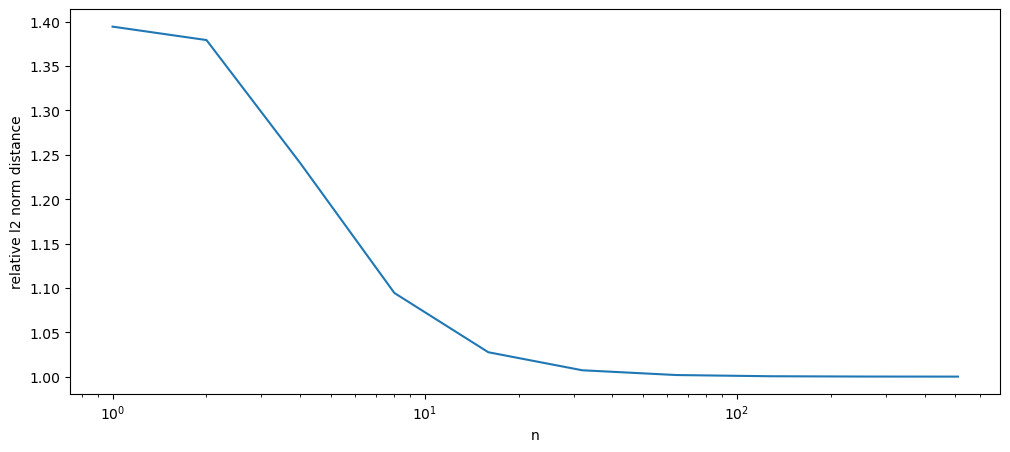

In [9]:
holder = []
ns = 2**np.arange(0, 10) # Number of pulses from 1 to 10
for i, n in enumerate(ns):
    # color = colors[i % len(colors)]
    T = n*(tau_p+wait_time)
    first_resonance = np.pi * n / T
    # first_resonance = 1
    num_resonances = 2
    omega = np.linspace(10**-2, (2*num_resonances)*first_resonance, 10**6)
    # omega = np.logspace(-4, 8, 10**6)
    
    plot_me1 = filter_function_approx(omega, n, T)
    plot_me2 = filter_function_finite(omega, n, T, tau_p, method='numba')

    holder.append(np.linalg.norm(plot_me1-plot_me2)/np.linalg.norm(plot_me2))

plt.figure(num=3, figsize=(12, 5))
plt.plot(ns, holder)
    
plt.ylabel('relative l2 norm distance')
# plt.xlabel('ω/(n π/t)')
plt.xlabel("n")
plt.xscale('log')
# plt.xlabel(r'$\sin (x)$')

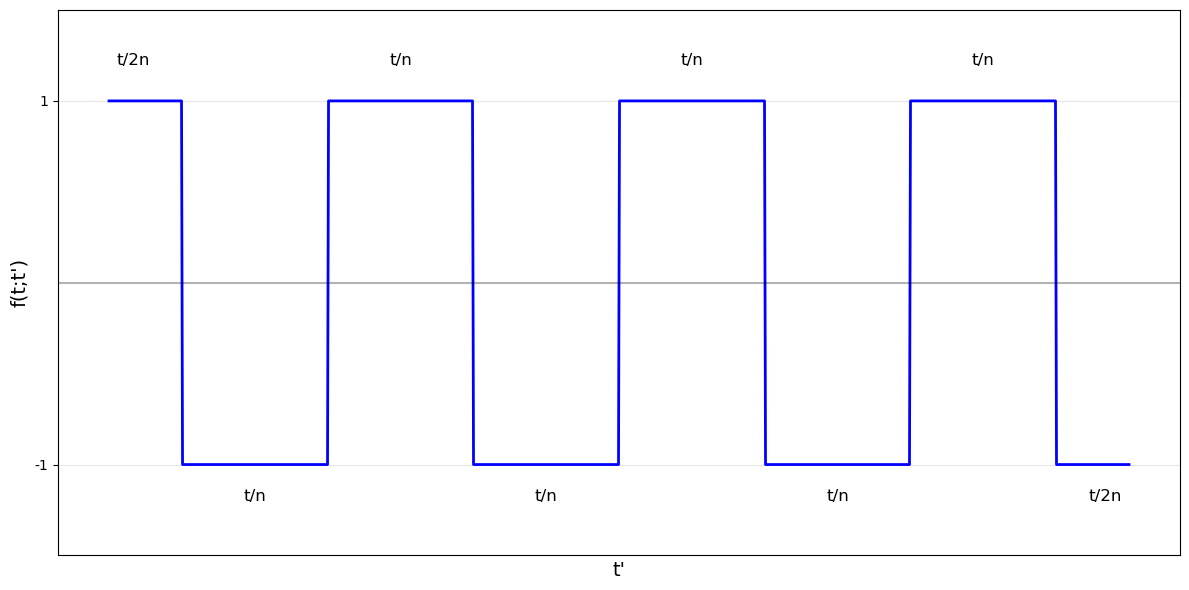

Period of each cycle: T/N = 1.0
Frequency: 1.0 Hz
Total time span: 4.5
Plot shows half plateaus at start and end to match original diagram


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square


# Define parameters
T = 4  # Total period shown in the plot
N = 4  # Number of periods within T (based on the diagram)
period = T/N  # Period of each square wave cycle
freq = 1/period  # Frequency
# Create time vector - adjusted to show half plateaus at start and end
t = np.linspace(period/4, T-period/4, 1000)
# Generate square wave using scipy.signal.square
# The square function generates values between -1 and +1
g = square(2 * np.pi * freq * t)
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(t, g, 'b-', linewidth=2)
# Set up the plot styling
plt.ylim(-1.5, 1.5)
# plt.xlim(-period/2, T)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
# Add labels and annotations
plt.ylabel("f(t;t')", fontsize=14)
plt.xlabel("t'", fontsize=14)
# Remove x-axis ticks
plt.xticks([])
# Add period labels on the plateaus
# First half plateau (positive)
plt.text(period/3, 1.2, 't/2n', ha='center', fontsize=12)
# Full plateaus

for i in range(N+2):
    if i % 2 == 1:  # Positive plateaus
        plt.text((5/4)*period+period*(i-1)/2, 1.2, 't/n', ha='center', fontsize=12)
    else:  # Negative plateaus
        plt.text((3/4)*period+period*i/2, -1.2, 't/n', ha='center', fontsize=12)


plt.text(T-period/3, -1.2, 't/2n', ha='center', fontsize=12)

# Add y-axis labels only for 1 and -1
plt.yticks([1, -1], ['1', '-1'])
# plt.text(-0.1, 1, '1', ha='right', va='center', fontsize=12)
# plt.text(-0.1, -1, '-1', ha='right', va='center', fontsize=12)
# plt.title('Square Wave: g(t)', fontsize=16)
plt.tight_layout()
plt.show()
# Print some information about the signal
print(f"Period of each cycle: T/N = {period}")
print(f"Frequency: {freq} Hz")
print(f"Total time span: {T + period/2}")
print("Plot shows half plateaus at start and end to match original diagram")

1/f 1/e time:  0.6570193735178309
Lorentizian 1/e time:  1.1992253187235848


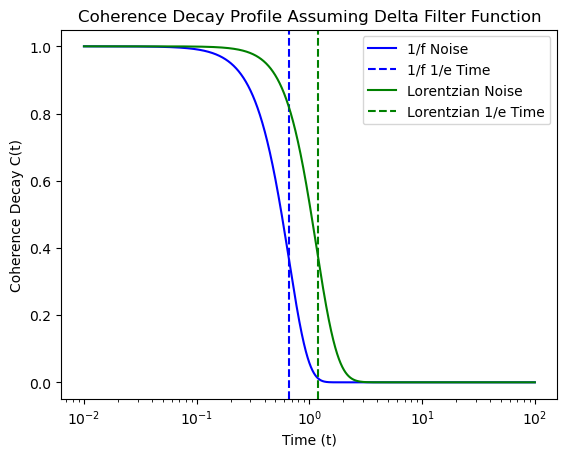

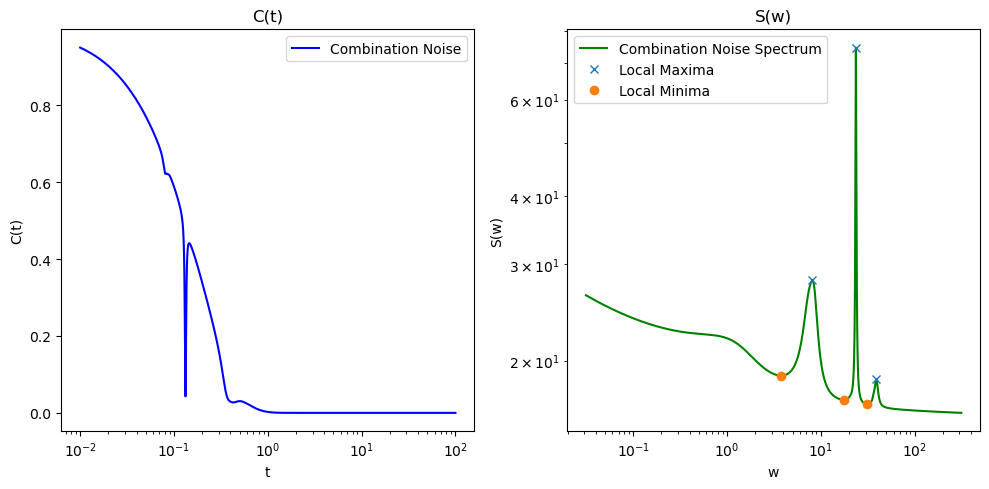

In [11]:
# Example Usage: Coherence Decay Profile Assuming Filter Function is a Delta Function, 1/f Noise, Lorentzian Noise, and combination noise.

t = np.logspace(-2, 2, 10**5)
A = 50
alpha = 1.5


c_1f = coherence_decay_profile_delta(t,noise_spectrum_1f(np.pi/t, A, alpha))
c_1f_1e = t[np.argmin(np.abs(np.array(c_1f)-1/np.e))]
print("1/f 1/e time: ", c_1f_1e)
c_lor = coherence_decay_profile_delta(t,noise_spectrum_lor(np.pi/t, omega_0=0, gamma=alpha, A=A))
c_lor_1e = t[np.argmin(np.abs(np.array(c_lor)-1/np.e))]
print("Lorentizian 1/e time: ", c_lor_1e)
# c_lor = coherence_decay_profile_delta(noise_spectrum_lor(np.pi/t, Delta=alpha, tau_c=1),t)

plt.plot(t,c_1f,label='1/f Noise',color='b')
plt.axvline(c_1f_1e, color='b', linestyle='--', label='1/f 1/e Time')
plt.plot(t,c_lor,label='Lorentzian Noise',color='g')
plt.axvline(c_lor_1e, color='g', linestyle='--', label='Lorentzian 1/e Time')
plt.xlabel('Time (t)')
plt.ylabel('Coherence Decay C(t)')
plt.title('Coherence Decay Profile Assuming Delta Filter Function')
plt.xscale('log')
plt.legend()
plt.show()

num_1f = 1
A_values = np.random.uniform(low=0,high=50,size=num_1f)
alpha_values = np.random.uniform(low=0,high=3,size=num_1f)

num_lor = 7
lor_A_values = np.random.uniform(low=0,high=50,size=num_lor)
omega_0_values = np.random.uniform(low=0,high=50,size=num_lor)
gamma_values = np.random.uniform(low=0,high=3,size=num_lor)

num_C = 1
C_values = np.random.uniform(low=0,high=50,size=num_C)


s_w = noise_spectrum_combination(np.pi/t,{'A':A_values,'alpha':alpha_values},{'omega_0':omega_0_values,'gamma':gamma_values,'A':lor_A_values},{"C":C_values})
# noise_spectrum_combination(np.pi/t,{'A':A_values,'alpha':alpha_values},{'omega_0':omega_0_values,'gamma':gamma_values,'A':A_values},{"C":C_values})
c_t = coherence_decay_profile_delta(t,s_w)

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot y1 in the first subplot
ax1.plot(t, c_t, label="Combination Noise", color="blue")
ax1.set_title("C(t)")
ax1.set_xlabel("t")
ax1.set_ylabel("C(t)")
ax1.set_xscale("log")
ax1.legend()

local_maxima, _ =  find_peaks(s_w)
local_minima, _ = find_peaks(-s_w)

# Plot y2 in the second subplot
ax2.plot(np.pi/t, s_w, label="Combination Noise Spectrum", color="green")
plt.plot((np.pi/t)[local_maxima], s_w[local_maxima], "x", label="Local Maxima")
plt.plot((np.pi/t)[local_minima], s_w[local_minima], "o", label="Local Minima")
ax2.set_title("S(w)")
ax2.set_xlabel("w")
ax2.set_ylabel("S(w)")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()

# Display the plots
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

In [12]:
# noise = noise_spectrum_lor
# omega_0 = 100
# gamma = 0.1
# A = 100
# args = (omega_0, gamma, A)

# N = 2048
# tau_p = 0.04
# t = 2*N*(tau_p)
# # t = 1000

# omega_range = (1e-4,1e8)
# omegas = np.logspace(np.log10(omega_range[0]), np.log10(omega_range[1]), 10**7) # setting resolution to 10^8 points. Might be a little overkill
# S_w = noise_spectrum_lor(omegas, *args)  # Check that the noise_profile function works with the omega_values

# k = 1000
# # Find the k largest values
# # k_largest_values = np.partition(S_w, -k)[-k:]
# k_largest_indices = np.argpartition(S_w, -k)[-k:]

# local_maxima_indices, _ =  find_peaks(S_w)
# local_minima_indices, _ = find_peaks(-S_w)

# points_of_interest = np.unique(np.concatenate((omegas[local_maxima_indices], omegas[local_minima_indices],omegas[k_largest_indices])))
# print(len(points_of_interest))

# # Find the peaks of the filter function, located at omega = (2m+1)n*Pi/t for integer m
# base = np.pi * N / t

# omega_peaks = np.array([base * (2*k + 1) for k in range(100)])

# additional_filter_peaks = []
# for point in points_of_interest:
#     k = round((point/base - 1)/2)
#     additional_filter_peaks.append(base * (2*k + 1))
# additional_filter_peaks = np.array(additional_filter_peaks)

# omega_values = np.unique(np.concatenate((omega_peaks, additional_filter_peaks,points_of_interest,np.logspace(np.log10(omega_range[0]), np.log10(omega_range[1]), 10**5))))

# # omega_peaks = np.array([base * (2*k + 1) for k in range(int(np.ceil((np.max(omega_range) / base-1)/2)+1))])
# # print(np.format_float_scientific(len(omega_peaks)))
# # print(np.format_float_scientific(omega_peaks.nbytes))

# # omega_peaks = np.array([base * (2*k + 1) for k in range(100)])

# filter_values = []
# max_filter_value = np.float128(0)
# # for k in range(int(np.ceil((np.max(omega_range) / base-1)/2)+1)):
# for k in range(1000):
#     peak = base * (2*k + 1)
#     ff_value = filter_function_finite(peak, N, t, tau_p)[0]
#     filter_values.append(ff_value)
#     # if np.abs((ff_value.astype(np.float128)-max_filter_value.astype(np.float128))/ff_value.astype(np.float128)) <= 1e-2:
#     #     break
#     if ff_value > max_filter_value:
#         max_filter_value = ff_value
    
# filter_values = np.array(filter_values)
# # omegas = np.concatenate((omega_peaks, omega_values[k_largest_indices]))

In [13]:
# print(len(filter_values))
# plt.plot(range(len(filter_values)),filter_values)
# plt.show()

# em = np.array(find_peaks(filter_values)[0])

# if np.all(np.diff(filter_values) >= 0):
#     print("Period not found")
#     print(len(filter_values))
# elif len(em) == 0:
#     print("Period in k is:")
#     print(len(filter_values))
# elif len(em) == 1:
#     print("Period in k is:")
#     print(em)
# else:
#     print("Period in k is:")
#     print(np.bincount(np.diff(em)).argmax())

# # print(filter_values[em])

In [ ]:
def monitor_memory():
    """Monitor current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # in MB

def find_k_largest_peaks(arr, k):
    """
    Find the k largest peaks in a 1D array.
    
    Parameters:
    -----------
    arr : array-like
        Input 1D array to find peaks in
    k : int
        Number of largest peaks to return
    
    Returns:
    --------
    peak_indices : ndarray
        Indices of the k largest peaks
    peak_heights : ndarray
        Heights of the k largest peaks
    """
    # Find all peaks
    peaks, _ = find_peaks(arr)
    
    # Get peak heights
    peak_heights = arr[peaks]
    
    # Sort peaks by height in descending order
    sorted_peak_indices = np.argsort(peak_heights)[::-1]
    
    # Select k largest peaks
    k_largest_peak_indices = peaks[sorted_peak_indices[:k]]
    k_largest_peak_heights = peak_heights[sorted_peak_indices[:k]]
    
    return k_largest_peak_indices, k_largest_peak_heights

def coherence_decay_profile_finite_peaks_with_widths(t, N, tau_p, method, noise_profile, *args, max_memory_mb=15000, **kwargs):
    """Computes the integral in eq #1 in [Meneses,Wise,Pagliero,et.al. 2022] exactly, considering finite pulse widths, which computes the Coherence decay profile, C(t). 
    Inputs:
    t: a float of the time variable
    N: a float of the number of pulses
    tau_p: a float of the pulse width
    method: a string of the method to use for integration. Options are "quad,"trapezoid","simpson",and "log_sum_exp". 
    noise_profile: a function that implements the noise spectrum, S(omega)
    *args: a list of arguments to pass to the noise_profile function
    **kwargs: a dictionary of keyword arguments to pass to the function
    Output:
    np.exp(-chi_t): The coherence decay profile, C(t), the omega values used in the integration, the filter function values, and the integrand values.
    omega_values: a numpy array of angular frequencies
    filter_values: a numpy array of the filter function values, evaluated at omega_values
    integrand: a numpy array of the integrand values given by S(omega)*F(omega*t)/(2*pi*omega**2), evaluated at omega_values
    """
    if not (isinstance(N, int) and N > 0):
        raise TypeError(f"N must be a positive integer, got {type(N).__name__}")
    
    if kwargs.get('num_peaks_cutoff'):
        if not (isinstance(kwargs['num_peaks_cutoff'], int) and kwargs['num_peaks_cutoff'] >= 0):
            raise TypeError(f"num_peaks_cutoff must be a positive integer, got {type(kwargs['num_peaks_cutoff']).__name__}")
        
    current_memory = monitor_memory()
    if current_memory > max_memory_mb:
        raise MemoryError(f"Memory usage ({current_memory}MB) exceeded threshold")   

    try:
        omegas = np.logspace(np.log10(kwargs.get("omega_range")[0]), np.log10(kwargs.get("omega_range")[1]), 10**7) # setting resolution to 10^8 points. Might be a little overkill
    except KeyError:
        omegas = np.logspace(-4, 8, 10**7) # setting resolution to 10^8 points. Might be a little overkill
    S_w = noise_profile(omegas, *args)  # Check that the noise_profile function works with the omega_values

    k = 1000
    # Find the k largest values
    # k_largest_values = np.partition(S_w, -k)[-k:]
    k_largest_indices = np.argpartition(S_w, -k)[-k:]

    local_maxima_indices, _ =  find_peaks(S_w)
    local_minima_indices, _ = find_peaks(-S_w)

    points_of_interest = np.unique(np.concatenate((omegas[local_maxima_indices], omegas[local_minima_indices],omegas[k_largest_indices])))
    # print(len(points_of_interest))

    # Find the peaks of the filter function, located at omega = (2m+1)n*Pi/t for integer m
    base = np.pi * N / t

    omega_peaks = np.array([base * (2*k + 1) for k in range(100)]) # consider the first 100 FF resonance peaks

    # Check for additional FF resonance peaks near the points of interest on the noise
    # additional_filter_peaks = []
    # for point in points_of_interest:
    #     k = round((point/base - 1)/2)
    #     additional_filter_peaks.append(base * (2*k + 1))
    # additional_filter_peaks = np.array(additional_filter_peaks)

    k_values = np.round((points_of_interest/base - 1)/2).astype(int)
    additional_filter_peaks = base * (2*k_values + 1)

    try:
        omega_sweep = np.logspace(np.log10(kwargs.get("omega_range")[0]), np.log10(kwargs.get("omega_range")[1]), kwargs.get("omega_resolution",10**5)) # setting resolution to 10^8 points. Might be a little overkill
    except KeyError:
        omega_sweep = np.logspace(-4, 8, kwargs.get("omega_resolution",10**5)) # setting resolution to 10^8 points. Might be a little overkill

    breakpoints = np.unique(np.concatenate((omega_peaks, additional_filter_peaks, points_of_interest)))
    omega_values = np.unique(np.concatenate((breakpoints, omega_sweep)))


    filter_values = filter_function_finite(omega_values, N, t, tau_p)

    integrand = np.multiply(filter_values, np.divide(noise_profile(omega_values, *args),(np.power(omega_values,2))))

    largest_peak_indices, _ = find_k_largest_peaks(integrand, kwargs.get('num_peaks_cutoff', len(omega_values)))

    if list(largest_peak_indices): # If there are singularities in the filter function within the specified omega range
        additional_omega_values = np.array([])
        for index in largest_peak_indices:
            if kwargs.get("peak_resolution"):
            # Joonhee says that the width of the peaks should scale as O(1/N)
            # Using 1/N here is not percise, for low values of N, it can lead to negative values of omega being added to omega_values (i.e. peak_width/2 > peak), which I 
            # correct for by removing negative values below. A more sophisticated approach would be to use a peak width that scales with N.
                peak = omega_values[index]
                peak_width = 1/N # Width in indices

                # Otherwise, add additional points around the peak, if no resolution is specified, use 10 points.
                peak_res = kwargs.get("peak_resolution", 10)

                # You could opt to use a logspace around the peak, but I went with a linear space for now. Have to fix issue where peak_width/2 > peak, which would require a 
                # more sophisticated approach to setting peak_width.
                # additional_omega_values.append(omega_values, np.logspace(np.log10(peak-peak*peak_width), np.log10(peak+peak*peak_width), peak_res))
                additional_omega_values = np.append(additional_omega_values,np.linspace(peak-peak*peak_width, peak+peak*peak_width, peak_res))
                
        additional_omega_values = additional_omega_values[additional_omega_values > 0] # Remove non-positive values to be safe. Important when N=1 to avoid devide by zero errors.
        additional_filter_values = filter_function_finite(additional_omega_values, N, t, tau_p)
        additional_integrand = np.multiply(additional_filter_values, np.divide(noise_profile(additional_omega_values, *args),(np.power(additional_omega_values,2))))

        
        # Concatenate and get unique, sorted omega values
        merged_omega_values = np.sort(np.unique(np.concatenate((omega_values, additional_omega_values))))
        # Create merged filter values array
        merged_integrand = np.zeros_like(merged_omega_values, dtype=integrand.dtype)
        merged_filter_values = np.zeros_like(merged_omega_values, dtype=filter_values.dtype)
        
        # Find indices of original omega values in merged array
        original_indices = np.searchsorted(merged_omega_values, omega_values)
        merged_integrand[original_indices] = integrand
        merged_filter_values[original_indices] = filter_values
        
        # Find indices of new omega values in merged array
        new_indices = np.searchsorted(merged_omega_values, additional_omega_values)
        merged_integrand[new_indices] = additional_integrand
        merged_filter_values[new_indices] = additional_filter_values

        omega_values = merged_omega_values
        integrand = merged_integrand
        filter_values = merged_filter_values
    
        # print("Range of Omega Values: ", np.format_float_scientific(np.min(omega_values)), np.format_float_scientific(np.max(omega_values)))

    if method == "quad":
        # for the scipy adaptive quadrature, we need to provide the integrand as a function of omega
        integrand = lambda omega: (noise_profile(omega, *args) * filter_function_finite(omega, N, t, tau_p)) / np.power(omega,2)
        # Integrate the integrand over the specified omega range using a maximum of "limit" subdivisions in the adaptive alogrithm,
        #  and using the omega_peaks as break points where sigularities occur.

        # with warnings.catch_warnings():
        #     warnings.filterwarnings('ignore', category=IntegrationWarning)
        chi_t = 0
        chi_t_i, _ = quad(integrand, 0, breakpoints[0], 
                    limit=kwargs.get('quad_limit',len(breakpoints)+10), 
                    points=[0,breakpoints[0]],
                    epsabs=kwargs.get('epsabs', 1.49e-8),
                    epsrel=kwargs.get('epsrel', 1.49e-8))
        chi_t += chi_t_i
        for i in range(len(breakpoints)-1):
            chi_t_i, _ = quad(integrand, breakpoints[i], breakpoints[i+1], 
                                limit=kwargs.get('quad_limit',len(breakpoints)+10), 
                                points=[breakpoints[i],breakpoints[i+1]],
                                epsabs=kwargs.get('epsabs', 1.49e-8),
                                epsrel=kwargs.get('epsrel', 1.49e-8))
            chi_t += chi_t_i
            
        chi_t = chi_t/(np.pi)

        return np.exp(-chi_t), omega_values, filter_values, integrand(omega_values)/(np.pi)  # No omega_values, filter_values, or integrand for quad method
    else:     

        # integrand = np.multiply(filter_values, np.divide(noise_profile(omega_values, *args),(np.power(omega_values,2))))

        # I'm using the "trapezoid" method because it's error has better scaling with the size of the step size of x values, which 
        # is large since we are using log spacing for points.
        if method == "simpson":
            chi_t = simpson(integrand, x=omega_values)
        elif method == "trapezoid":
            chi_t = trapezoid(integrand, x=omega_values)
        else:
            raise ValueError(f"Unknown method: {method}")
        

        chi_t = chi_t/(np.pi)
        
        return np.exp(-chi_t), omega_values, filter_values, integrand/(np.pi)
    
def retry_parallel_execution(func=None, max_retries=None, initial_n_jobs=None, min_n_jobs=1):
    """
    Decorator that implements retry logic with CPU reduction for parallel execution.
    Can be used with or without parameters.
    
    Args:
        func: The function to wrap
        max_retries: Maximum number of retry attempts (default: use all available CPUs down to min_n_jobs)
        initial_n_jobs: Initial number of CPUs to use (default: all available - 1)
        min_n_jobs: Minimum number of CPUs to try before giving up (default: 1)
    """
    def decorator(f):
        def wrapper(*args, **kwargs):
            # Allow overriding initial_n_jobs through function kwargs
            n_jobs = kwargs.pop('initial_n_jobs', None) or initial_n_jobs or max(1, os.cpu_count())
            if max_retries is None:
                max_retry_attempts = n_jobs - min_n_jobs + 1
            else:
                max_retry_attempts = max_retries
            
            attempt = 0
            current_n_jobs = n_jobs
            
            while attempt < max_retry_attempts and current_n_jobs >= min_n_jobs:
                try:
                    kwargs['n_jobs'] = current_n_jobs
                    print(f"\nAttempting execution with {current_n_jobs} CPU{'s' if current_n_jobs > 1 else ''}...")
                    result = f(*args, **kwargs)
                    print(f"Successfully completed using {current_n_jobs} CPU{'s' if current_n_jobs > 1 else ''}")
                    return result
                
                except Exception as e:
                    if "SIGKILL" in str(e) or isinstance(e, MemoryError):
                        attempt += 1
                        current_n_jobs -= 1
                        
                        if current_n_jobs >= min_n_jobs:
                            print(f"\nExecution failed with {current_n_jobs + 1} CPUs: {str(e)}")
                            print(f"Retrying with {current_n_jobs} CPU{'s' if current_n_jobs > 1 else ''}...")
                            time.sleep(2)  # Give system time to clean up resources
                        else:
                            print("\nReached minimum CPU count. Raising error.")
                            raise ParallelExecutionError(
                                f"Failed to execute even with minimum {min_n_jobs} CPU(s). Last error: {str(e)}"
                            )
                    else:
                        # If it's not a SIGKILL or MemoryError, re-raise the original exception
                        raise
            
            raise ParallelExecutionError(
                f"Exceeded maximum retry attempts ({max_retry_attempts}) or minimum CPU count reached"
            )
        return wrapper

    if func is None:
        return decorator
    return decorator(func)

@retry_parallel_execution
def parallel_coherence_decay(times, N, tau_p, method, noise_profile, *args, n_jobs=None, batch_size=None, max_memory_per_worker=1000, **kwargs):
    """
    Parallelized version of coherence_decay_profile_finite_peaks_with_widths.
    Inputs:
    times: a numpy array of time values
    n: a float of the number of pulses
    tau_p: a float of the pulse width
    method: a string of the method to use for integration. Options are "quad", "trapezoid", "simpson", and "log_sum_exp".
    noise_profile: a function that implements the noise spectrum, S(omega)
    *args: a list of arguments to pass to the noise_profile function
    n_jobs: an int of the number of CPUs to use for computation. Default is None, which uses all available CPUs.
    **kwargs: a dictionary of keyword arguments to pass to the function
    Output:
    C_t: a numpy array of the coherence decay profile, C(t)
    omega_values_list: a list of numpy arrays of angular frequencies used in the integration
    filter_values_list: a list of numpy arrays of the filter function values, evaluated at omega_values
    integrand_list: a list of numpy arrays of the integrand values given by S(omega)*F(omega*t)/(2*pi*omega**2), evaluated at omega_values
    """
    if not isinstance(N, int):
        raise TypeError(f"N must be an integer, got {type(N).__name__}")

    # if n_jobs is None:
    #     n_jobs = -1  # -1 means using all available CPUs

    if batch_size is None:
        batch_size = max(1, len(times) // (n_jobs * 4))  # Divide work into smaller chunks

    print(n_jobs)
    if n_jobs >1:
        print(f"Using {n_jobs} CPUs with batch size {batch_size}")
    elif n_jobs < 0:
        print(f"Using {os.cpu_count() + n_jobs + 1} CPU with batch size {batch_size}")

    time_batches = [times[i:i + batch_size] for i in range(0, len(times), batch_size)]

    def process_batch(batch):
        return [coherence_decay_profile_finite_peaks_with_widths(
            t, N, tau_p, method, noise_profile, *args, 
            max_memory_mb=max_memory_per_worker, **kwargs) 
                for t in batch]
    
    with parallel_backend('loky', n_jobs=n_jobs):
    # with parallel_backend('loky', n_jobs=n_jobs, inner_max_num_threads=1): # Use this line if you are using numpy or scipy functions that are not thread-safe
        results_nested = Parallel(verbose=1)(
            delayed(process_batch)(batch) 
            for batch in tqdm(time_batches, desc="Processing batches")
        )
    
    # Flatten results and filter out None values
    results = [r for batch in results_nested for r in batch if r is not None]
    
    if not results:
        raise RuntimeError("No valid results were produced")
    
    # Unpack the results
    C_t, omega_values_list, filter_values_list, integrand_list = zip(*results)
    
    return (np.array(C_t), omega_values_list, filter_values_list, integrand_list)


Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   25.2s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   59.1s finished


Successfully completed using 16 CPUs
CPU times: user 4.55 s, sys: 1.26 s, total: 5.8 s
Wall time: 59.2 s
1/e time:  2.5877260959473087


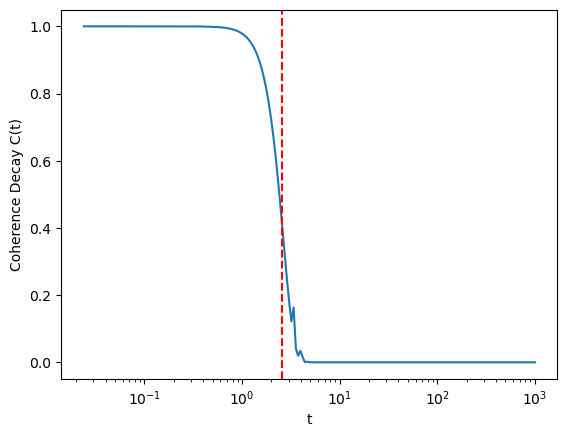

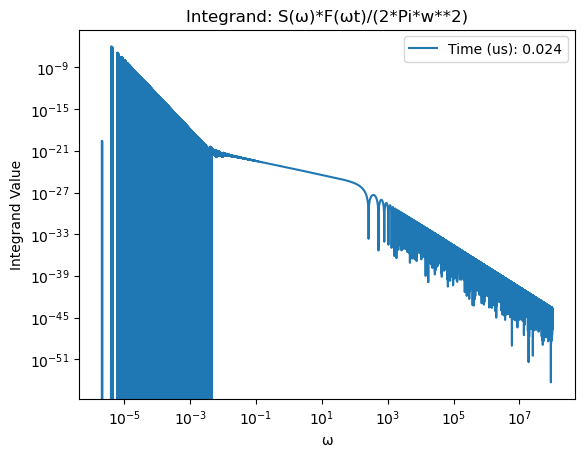

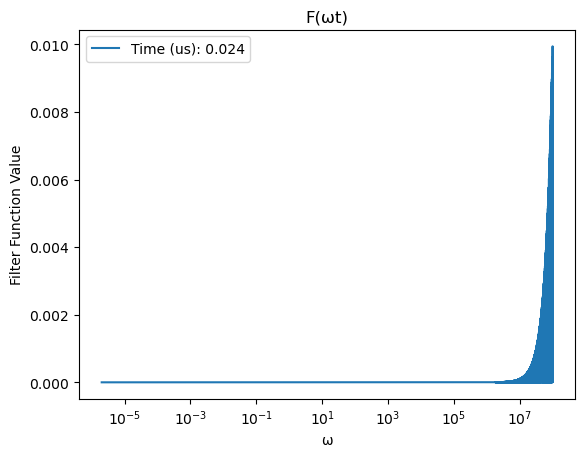

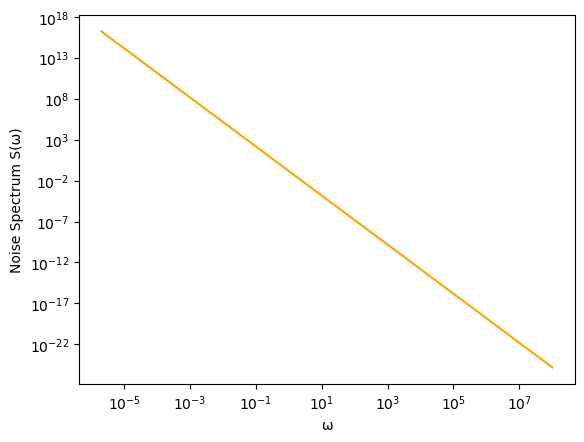

In [15]:
# Example Usage: Compute C(t) for a 1/f noise spectrum with finite pulse widths
tau_p = 0.024
n = 1
# The minimum allowable time is n*tau_p, so we start from there. The +10e-9 is to avoid numererical errors.
times = np.logspace(np.log10(n*tau_p+10e-10,dtype=np.float64), 3, 201,dtype=np.float64)

# int((10**6)*np.exp(-alpha))

integration_params = {
    "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
    "omega_range" : (10**(-4),10**8), # The number of peaks to use in the filter function
    "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
    "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
    "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
    "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
    "epsrel": 1.49e-8 # Relative tolerance for the quadrature integration
}

noise = noise_spectrum_1f
A = 0.15151515
alpha = 3
args = [A, alpha]

# noise = noise_spectrum_lor
# omega_0 = 1.e+00
# gamma = 1.e-01
# A = 1.e+03
# args = [omega_0, gamma, A]

# #[ 100.,   10., 1000.]
# #[5.e+07, 1.e-01, 1.e+02]

# Use all available CPUs (default behavior)
%time C_t, omega_values_list, filter_values_list, integrand_list = parallel_coherence_decay(times, n, tau_p, "trapezoid", noise, *args, initial_n_jobs=None, max_memory_per_worker=10**4, **integration_params)
# If you dont't want to run this in parallel, you can use:
# %time C_t, omega_values_list, filter_values_list, integrand_list = zip(*[coherence_decay_profile_finite_peaks_with_widths(t, n, tau_p, "trapezoid", noise, *args,**integration_params) for t in tqdm(times)])


print("1/e time: ", times[np.argmin(np.abs(np.array(C_t)-1/np.e))])
plt.plot(times,C_t)
plt.axvline(times[np.argmin(np.abs(np.array(C_t)-1/np.e))], color='r', linestyle='--', label='1/e Time')
plt.xlabel('t')
plt.ylabel('Coherence Decay C(t)')
# plt.title('Coherence Decay Profile')
plt.xscale('log')
# plt.legend()
plt.show()

plot_index = 0

plt.plot(omega_values_list[plot_index],integrand_list[plot_index],label="Time (us): " + "{:.3f}".format(times[plot_index]))
plt.title("Integrand: S(ω)*F(ωt)/(2*Pi*w**2)")
plt.xlabel("ω")
plt.ylabel("Integrand Value")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(omega_values_list[plot_index],filter_values_list[plot_index],label="Time (us): " + "{:.3f}".format(times[plot_index]))
plt.title("F(ωt)")
plt.xlabel("ω")
plt.ylabel("Filter Function Value")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

plt.plot(omega_values_list[plot_index],noise(omega_values_list[plot_index], *args), color="orange", label="Time (us): " + "{:.3f}".format(times[plot_index]))
# plt.title("S(ω)")
plt.xlabel("ω")
plt.ylabel("Noise Spectrum S(ω)")
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.show()

In [16]:
a= np.array([1,2,3,4,5])
b = np.array([(6,1),(7,2),(8,3),(9,4),(10,5)])
[x for x in zip(a,b)]

[(1, array([6, 1])),
 (2, array([7, 2])),
 (3, array([8, 3])),
 (4, array([9, 4])),
 (5, array([10,  5]))]

In [17]:
def lorentzian_peak_show(C_t,times,n,omega_0):
    C_t = np.array(C_t)
    you, _ = find_k_largest_peaks(-C_t, 8)

    plt.plot(times,C_t,label="C(t)")
    plt.plot(times[you], C_t[you], "x", label="Local Minima")
    plt.title("C(t)")
    plt.xlabel("t")
    plt.ylabel("C(t)")
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    plt.show()


    for i,plot_index in enumerate(np.sort(you)):

        base = np.pi*n/times[plot_index]
        center_k = round((omega_0/base-1)/2)
        peaks = [base*(2*k+1) for k in range(np.max((center_k-1000,0)),center_k+1000)]

        # Find the index of the value closest to omega_0
        closest_index = np.argmin(np.abs(np.array(peaks) - omega_0))

        # Get the closest value
        closest_value = peaks[closest_index]

        closest_k = round((closest_value/base-1)/2)

        print(str(i+1)+"th Local Minima time: " + str(times[plot_index]))
        print("Lorentzian Peak: " + str(omega_0))
        print("Closest value to omega_0 is the " +str(closest_k+1)+"th peak: ", closest_value)
        print("**************************************************")
        # print(str(i)+"th Filter Function Peak: " + str(np.pi*n/times[plot_index]*(2*i+1)))


        # plt.plot(omega_values_list[plot_index],integrand_list[plot_index],label="Time (us): " + "{:.3f}".format(times[plot_index]))
        # plt.title("Integrand: S(w)*F(wt)/(2*Pi*w**2)")
        # plt.xlabel("w")
        # plt.ylabel("Integrand Value")
        # plt.xscale('log')
        # plt.yscale('log')
        # plt.legend()
        # plt.show()

        # plt.plot(omega_values_list[plot_index],filter_values_list[plot_index],label="Time (us): " + "{:.3f}".format(times[plot_index]))
        # plt.title("F(wt)")
        # plt.xlabel("w")
        # plt.ylabel("Filter Function Value")
        # plt.xscale('log')
        # # plt.yscale('log')
        # plt.legend()
        # plt.show()

        # plt.plot(omega_values_list[plot_index],noise(omega_values_list[plot_index], *args), label="Time (us): " + "{:.3f}".format(times[plot_index]))
        # plt.title("S(w)")
        # plt.xlabel("w")
        # plt.ylabel("Noise Spectrum Value")
        # plt.xscale('log')
        # plt.yscale('log')
        # plt.legend()
        # plt.show()

# lorentzian_peak_show(C_t,times,n,omega_0)

In [18]:
import imageio # Make fun gifs to see how the filter function and integrand changes over time
def create_integrand_gif(omega_values_list, plot_list, times, save_name, n=None, omega_0=None):
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8, 6))
    # Set up the GIF writer
    writer = imageio.get_writer(save_name, mode='I', duration=0.1)
    for i in range(len(times)):
        # Clear the axis
        ax.clear()
        # Plot the current integrand
        ax.plot(omega_values_list[i], plot_list[i], label=f"Time (us): {times[i]:.3f}")
        if n is not None:
            peaks = [np.pi*n/times[i] *(2*k+1) for k in range(10)]
            ax.plot(peaks, [plot_list[i][np.argmin(np.abs(omega_values_list[i]-peak))] for peak in peaks], "x", label="Filter Resonances")
        if omega_0 is not None:
            ax.plot(omega_0, plot_list[i][np.argmin(np.abs(omega_values_list[i]-omega_0))], "o", label="Lorentzian Peak")
       
        if save_name == "integrands_plot.gif":
            ax.set_title("Integrand: S(w)*F(wt)/(2*Pi*w**2)")
            ax.set_xlabel("w")
            ax.set_ylabel("Integrand Value")
        elif save_name == "filter_functions.gif":
            ax.set_title("F_n(w,t)")
            ax.set_xlabel("w")
            ax.set_ylabel("Filter Function Value")
           
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        
        # Add the plot to the GIF - UPDATED CODE HERE
        fig.canvas.draw()
        # Get the pixel data from the canvas using buffer_rgba instead of tostring_rgb
        width, height = fig.canvas.get_width_height()
        # Use buffer_rgba to get the image data
        buf = fig.canvas.buffer_rgba()
        # Convert the buffer to an array
        image = np.frombuffer(buf, dtype=np.uint8).reshape(height, width, 4)
        # If you need RGB instead of RGBA, you can slice off the alpha channel
        image = image[:, :, :3]
        
        writer.append_data(image)
    # Finish the GIF
    writer.close()
    print(f"GIF created: {save_name}")

# create_integrand_gif(omega_values_list, filter_values_list, times, "filter_functions.gif", n=n)
# create_integrand_gif(omega_values_list, integrand_list, times, "integrands_plot.gif", n=n, omega_0=omega_0)

In [19]:
##### GENERATE TRAINING SET #####

def generate_training_data_delta(t_points, noise_profile, *args,num_examples =2*10**4):
    # Generate all possible parameters and remove existing ones
    parameters_list = list(product(*args))

     # Create a RandomState object with a specific seed
    rng = random.Random(69)

    # Use this specific random state for sampling
    parameters = list(rng.sample(parameters_list, np.min((num_examples,len(parameters_list)))))

    C_t_list = []

    for params in parameters:
        noise = noise_profile(np.pi/t_points, *params)
        C_t = coherence_decay_profile_delta(t_points, noise)
        C_t_list.append([C_t,noise,params])
    
    return C_t_list

# def generate_training_data_finite(times,parameters, n, tau_p, method, noise_profile, **integration_params):
#     """
#     Generate coherence decay data with parallelized computation over both time points and parameters.
    
#     Parameters:
#     -----------
#     t_points : array-like
#         Time points at which to compute coherence
#     n : int
#         Number of pulses
#     tau_p : float
#         Pulse width
#     method : str
#         Integration method ('quad', 'simpson', 'trapezoid')
#     noise_profile : callable
#         Function to compute noise spectrum
#     *args : iterables
#         Parameters to sweep over for parameter space exploration
#     **integration_params : dict
#         Additional parameters for integration (e.g., omega_range, omega_resolution)
    
#     Returns:
#     --------
#     list of [C_t, noise_spectrum, params]
#         C_t: numpy array of coherence values for each time point
#         noise_spectrum: numpy array of noise spectrum
#         params: specific parameter combination
#     """
    
#     # Prepare omega values for noise spectrum
#     try:
#         omega = np.logspace(
#             np.log10(integration_params.get("omega_range")[0]), 
#             np.log10(integration_params.get("omega_range")[1]), 
#             integration_params.get("omega_resolution", 10**5)
#         )
#     except KeyError:
#         omega = np.logspace(-4, 8, integration_params.get("omega_resolution", 10**5))
    
#     C_t_list = []
#     for params in parameters:
#         # C_t, _, _, _ = parallel_coherence_decay(t_points, n, tau_p, method, noise_profile, *params, initial_n_jobs=None, max_memory_per_worker=10**4, **integration_params)
#         C_t, _, _, _ = zip(*[coherence_decay_profile_finite_peaks_with_widths(t, n, tau_p, method, noise_profile, *params,**integration_params) for t in times])
#         C_t_list.append([C_t,noise_profile(omega, *params),params])

#     return C_t_list

@retry_parallel_execution
def generate_training_data_finite(inputs, n, tau_p, method, noise_profile, **integration_params):
    """
    Generate coherence decay data with parallelized computation over both time points and parameters.
    
    Parameters:
    -----------
    t_points : array-like
        Time points at which to compute coherence
    n : int
        Number of pulses
    tau_p : float
        Pulse width
    method : str
        Integration method ('quad', 'simpson', 'trapezoid')
    noise_profile : callable
        Function to compute noise spectrum
    *args : iterables
        Parameters to sweep over for parameter space exploration
    **integration_params : dict
        Additional parameters for integration (e.g., omega_range, omega_resolution)
    
    Returns:
    --------
    list of [C_t, noise_spectrum, params]
        C_t: numpy array of coherence values for each time point
        noise_spectrum: numpy array of noise spectrum
        params: specific parameter combination
    """
    
    # Prepare omega values for noise spectrum
    try:
        omega = np.logspace(
            np.log10(integration_params.get("omega_range")[0]), 
            np.log10(integration_params.get("omega_range")[1]), 
            integration_params.get("omega_resolution", 10**5)
        )
    except KeyError:
        omega = np.logspace(-4, 8, integration_params.get("omega_resolution", 10**5))
    
    def compute_single_task(t, params):
        # Compute coherence for a single time point and parameter set
        ct, _, _, _ = coherence_decay_profile_finite_peaks_with_widths(
            t, n, tau_p, method, noise_profile, *params, 
            max_memory_mb=15000, **integration_params
        )
        return t, params, ct

    # Parallel computation across all (time, parameter) pairs
    results = Parallel(verbose=2, n_jobs=-1, backend="loky")(
        delayed(compute_single_task)(t, params) for t, params in inputs
    )
    
    parameters = list({param for _, param in inputs})

    # Organize results by parameter set
    output = []
    for param in parameters:
        # Extract results for this parameter set
        param_results = [res for res in results if res[1] == param]
        # Sort results by time
        param_results.sort(key=lambda x: x[0])
        # Extract C_t values and noise spectrum
        C_t = np.array([res[2] for res in param_results])
        noise_spectrum = noise_profile(omega, *param)
        output.append([C_t, noise_spectrum, param])
    
    return output

def make_and_save_training_data(t_points, assume_delta, save_every_n, noise_profile, *args, **kwargs):
    """
    Generate and save training data, splitting parameters into groups for intermittent saving.

    Parameters:
    -----------
    t_points : array-like
        Time points for the training data.
    assume_delta : bool
        Whether to assume delta function noise.
    noise_profile : callable
        Function to compute noise spectrum.
    *args : iterables
        Parameter ranges for exploration.
    **kwargs : dict
        Additional arguments for data generation.

    Returns:
    --------
    None
    """

    print("Generating Training Data: " + noise_profile.__name__)
    # print(f_args)
    print("****************************")

    # Create a filename appendage based on the noise profile and parameter characteristics
    if noise_profile.__name__ == "noise_spectrum_combination":
        appendage = (
            "num_1f_" + str(len(args[0][0]["A"])) +
            "_num_lor_" + str(len(args[1][0]["gamma"])) +
            "_num_white_" + str(len(args[2][0]["C"]))
        )
    else:
        appendage = ""

    if assume_delta:
        data = generate_training_data_delta(t_points, noise_profile, *args)
        filename = f"{noise_profile.__name__}"
        save_name = f'training_data_{filename}{appendage}_delta.pkl'

        X = []
        Y = []
        params_list = []
        
        for item in data:
            X.append(item[0])  # C_t values
            Y.append(item[1])  # Noise profiles
            params_list.append(item[2])  # Parameters

        X = np.array(X)
        Y = np.array(Y)
        params_list = np.array(params_list)

        print(X.shape)
        print(Y.shape)
        save_dict = {"noise_profile": noise_profile.__name__, "noise_profile_args": params_list, "filter_function_args": kwargs,"data": (X, Y)}

        print(f"Saving training data to {save_name}")
        joblib.dump(save_dict, global_filepath + save_name)

    else:
        # Similar logic for finite width case
        params = '_'.join(f"{k}_{v}" for k, v in kwargs.items())
        filename = f"{noise_profile.__name__}_{params}"
        save_name = 'training_data_' + filename + appendage + '_finite_width.pkl'
        
        n = kwargs.pop("N")
        tau_p = kwargs.pop("tau_p")
        method = kwargs.pop("integration_method")

        # Check if file already exists and load existing data if it does
        try:
            existing_data = joblib.load(global_filepath + save_name)
            existing_params = set(tuple(params) for params in existing_data.get("noise_profile_args", []))
            print(f"Loaded existing data. Found {len(existing_params)} existing parameter sets.")
        except FileNotFoundError:
            existing_params = set()
            existing_data = None

        # Generate all possible parameter combinations
        parameters = list(product(*args))
        
        # Filter out parameters that have already been computed
        new_parameters = [param for param in parameters if tuple(param) not in existing_params]
        
        if not new_parameters:
            print("No new parameters to compute.")
            return

        # Initialize storage for cumulative results
        cumulative_X = []
        cumulative_Y = []
        cumulative_params = []

        # If existing data is found, initialize cumulative lists with existing data
        if existing_data:
            cumulative_X = list(existing_data['data'][0])
            cumulative_Y = list(existing_data['data'][1])
            cumulative_params = list(existing_data['noise_profile_args'])

        # Define batch size for parameter groups
        batch_size = save_every_n
        num_batches = (len(new_parameters) + batch_size - 1) // batch_size

        for batch_idx in tqdm(range(num_batches),desc="Processing Batches"):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(new_parameters))
            param_subset = new_parameters[start_idx:end_idx]
            subset_inputs = [(time, param) for time in t_points for param in param_subset]

            # Generate data for the current subset
            data_subset = generate_training_data_finite(subset_inputs, n, tau_p, method, noise_profile, **kwargs)

            for item in data_subset:
                cumulative_X.append(item[0])  # C_t values
                cumulative_Y.append(item[1])  # Noise profiles
                cumulative_params.append(item[2])  # Parameters

            # Save intermediate results
            intermediate_save_name = f'training_data_{filename}{appendage}_finite_width.pkl'
            intermediate_save_dict = {
                "noise_profile": noise_profile.__name__,
                "noise_profile_args": np.array(cumulative_params),
                "filter_function_args": kwargs,
                "data": (np.array(cumulative_X), np.array(cumulative_Y))
            }

            print(f"Saving intermediate training data (batch index = "+str(batch_idx) +") to " +str(intermediate_save_name))
            joblib.dump(intermediate_save_dict, global_filepath + intermediate_save_name)

        # Final save with all cumulative data
        final_save_dict = {
            "noise_profile": noise_profile.__name__,
            "noise_profile_args": np.array(cumulative_params),
            "filter_function_args": kwargs,
            "data": (np.array(cumulative_X), np.array(cumulative_Y))
        }
        print(f"Saving final training data to "+ str(save_name))
        joblib.dump(final_save_dict, global_filepath + save_name)

np_data_type = np.float64
# Parameters

num_samples = 10**4
# 1/f noise parameters
A_values = np.linspace(0, 100, ceil(np.sqrt(num_samples)),dtype=np_data_type)  # Adjust the number of points as needed
alpha_values = np.linspace(0, 3, ceil(np.sqrt(num_samples)),dtype=np_data_type)  # Adjust the number of points as needed
f_args = [A_values, alpha_values]

# Lorentzian noise parameters
num_samples_lor = 10**4
omega_0_values = np.linspace(1, 50*1e6, ceil(num_samples_lor**(1/3)),dtype=np_data_type)  # Adjust the number of points as needed
gamma_values = np.linspace(0.1, 10*1e6, ceil(num_samples_lor**(1/3)),dtype=np_data_type)  # Adjust the number of points as needed 
lor_A_values = np.linspace(10**3, 10**9, ceil(num_samples_lor**(1/3)),dtype=np_data_type)  # Adjust the number of points as needed
# omega_0_values = np.array([100,50*1e6])
# gamma_values = np.array([1.e-1,1e5])
# lor_A_values = np.array([100])
lor_args = [omega_0_values, gamma_values, lor_A_values]
print(len(lor_args[0])*len(lor_args[1])*len(lor_args[2]))

finite_width_params = {
    "N": 256, #CPMG-N (test spin echo)
    "tau_p": 24*10**(-3), #pi pulse width in mircoseconds
    "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
    "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
    "omega_range" : (10**(-4),10**8), # The number of peaks to use in the filter function
    "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
    "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
    # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
    # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
    # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
}

t_points = np.logspace(np.log10(finite_width_params["N"]*finite_width_params["tau_p"]+1e-10), np.log10(300), 201, dtype=np_data_type)  # Time points for coherence profile. Units are Microseconds
# frequency_points = np.pi / t_points  # Frequency range for generating noise spectrum

assume_delta = True # Whether or not to approximate Filter function pulses as Delta functions
save_every_n = 20 # The number of parameter sets to process in each batch. For intermittent saving of results.

make_and_save_training_data(t_points,assume_delta,save_every_n,noise_spectrum_1f,*f_args,**finite_width_params)
make_and_save_training_data(t_points,assume_delta,save_every_n,noise_spectrum_lor,*lor_args,**finite_width_params)


# # # 1/f + Lor
# # f_params = [{"A":[A], "alpha":[alpha]} for A, alpha in zip(A_values, alpha_values)]
# f_params = [{"A":[A], "alpha":[alpha]} for A, alpha in zip(np.linspace(0, 1, ceil(np.sqrt(num_samples)),dtype=np_data_type), alpha_values)]
# # lor_params = [{"omega_0":[omega_0], "gamma":[gamma], "A":[A]} for omega_0, gamma, A in zip(omega_0_values, gamma_values, lor_A_values)]
# lor_params = [{"omega_0":[omega_0], "gamma":[gamma], "A":[A]} for omega_0, gamma, A in zip(omega_0_values, gamma_values, np.linspace(0, 10, ceil(num_samples_lor**(1/3)),dtype=np_data_type))]

# white_params = [{"C": [c]} for c in np.linspace(0, 5, 10)]
# combo_args = [f_params, lor_params, white_params]

# make_and_save_training_data(t_points,assume_delta,save_every_n,noise_spectrum_combination,*combo_args,**finite_width_params)

# # 1/f + lor + lor
np_data_type = np.float64
# Parameters

# # 1/f noise parameters
# A_values = np.linspace(0, 100, ceil(np.sqrt(num_samples)),dtype=np_data_type)  # Adjust the number of points as needed
# alpha_values = np.linspace(0, 3, ceil(np.sqrt(num_samples)),dtype=np_data_type)  # Adjust the number of points as needed
# # Ensures that the parameters are all unique , and sorted. Not necessary, but convenient.
# A_values = np.unique(A_values)[::-1]
# alpha_values = np.unique(alpha_values)[::-1]
# # f_args = [A_values, alpha_values]

# # Lorentzian noise parameters
# num_samples_lor = 10**4
# omega_0_values = np.linspace(1, 50*1e6, ceil(num_samples_lor**(1/3)),dtype=np_data_type)  # Adjust the number of points as needed
# gamma_values = np.linspace(0.1, 10*1e6, ceil(num_samples_lor**(1/3)),dtype=np_data_type)  # Adjust the number of points as needed 
# lor_A_values = np.linspace(0, 10**9, ceil(num_samples_lor**(1/3)),dtype=np_data_type)  # Adjust the number of points as needed
# # Ensures that the parameters are all unique , and sorted. Not necessary, but convenient.
# omega_0_values = np.unique(omega_0_values)[::-1]
# gamma_values = np.unique(gamma_values)[::-1]
# lor_A_values = np.unique(lor_A_values)[::-1]
# # lor_args = [omega_0_values, gamma_values, lor_A_values]

num_1f = 1
# Get all num_1f-length combinations for both parameter arrays
A_combos = list(combinations(np.linspace(0, 0.1, ceil(np.sqrt(num_samples))), num_1f))
alpha_combos = list(combinations(alpha_values, num_1f))
f_params = [{"A": list(A), "alpha": list(alpha)} for A, alpha in zip(A_combos, alpha_combos)]

num_lor = 2
omega_0_combos = list(combinations(omega_0_values, num_lor))
gamma_combos = list(combinations(gamma_values, num_lor))
lor_A_combos = list(combinations(np.linspace(0, 5, ceil(num_samples_lor**(1/3)),dtype=np_data_type), num_lor))
lor_params = [{"omega_0": list(omega_0), "gamma": list(gamma), "A": list(A)} for omega_0, gamma, A in zip(omega_0_combos, gamma_combos, lor_A_combos)]

num_C = 1
C_combos = list(combinations(np.linspace(0, 10, 1000), num_C))
white_params = [{"C": list(C)} for C in C_combos]

combo_args = [f_params, lor_params, white_params]

# parameters = list(product(*combo_args))
# new_parameters = np.array([str(param) for param in parameters if tuple(param)])
# len(np.unique(new_parameters)) == len(parameters)


make_and_save_training_data(t_points,assume_delta,save_every_n,noise_spectrum_combination,*combo_args,**finite_width_params)

10648
Generating Training Data: noise_spectrum_1f
****************************
(10000, 201)
(10000, 201)
Saving training data to training_data_noise_spectrum_1f_delta.pkl
Generating Training Data: noise_spectrum_lor
****************************
(10648, 201)
(10648, 201)
Saving training data to training_data_noise_spectrum_lor_delta.pkl
Generating Training Data: noise_spectrum_combination
****************************
(20000, 201)
(20000, 201)
Saving training data to training_data_noise_spectrum_combinationnum_1f_1_num_lor_2_num_white_1_delta.pkl


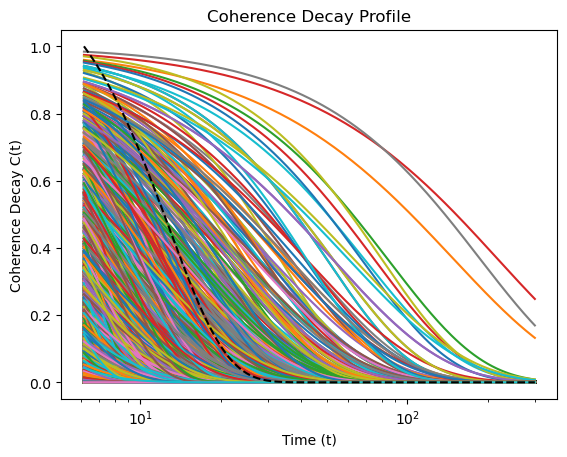

Average T2 Time:  6.360100333186931


In [20]:
assume_delta = True # Whether or not to approximate Filter function pulses as Delta functions

if assume_delta == True:
    X_1f, Y_1f = joblib.load(global_filepath + 'training_data_' + noise_spectrum_1f.__name__ + '_delta.pkl')["data"]
    X_lor, Y_lor = joblib.load(global_filepath + 'training_data_' + noise_spectrum_lor.__name__ + '_delta.pkl')["data"]
    X_combo1, Y_combo1 = joblib.load(global_filepath + 'training_data_' + "noise_spectrum_combinationnum_1f_1_num_lor_1_num_white_1" + '_delta.pkl')["data"]
    X_combo2, Y_combo2 = joblib.load(global_filepath + 'training_data_' + "noise_spectrum_combinationnum_1f_1_num_lor_2_num_white_1" + '_delta.pkl')["data"]
else:
    params = '_'.join(f"{k}_{v}" for k, v in finite_width_params.items())
    X_1f, Y_1f = joblib.load(global_filepath + 'training_data_' + noise_spectrum_1f.__name__ + "_" + params + '_finite_width.pkl')["data"]
    X_lor, Y_lor = joblib.load(global_filepath + 'training_data_' + noise_spectrum_lor.__name__ + "_" + params + '_finite_width.pkl')["data"]
    X_combo1,Y_combo1 = joblib.load(global_filepath + 'training_data_' + "noise_spectrum_combo_N1f_1_Nlor_1_NC_1_" + params + '_finite_width.pkl')["data"]
    # X_combo2,Y_combo2 = joblib.load(global_filepath + 'training_data_' + "noise_spectrum_combo_N1f_1_Nlor_2_NC_1_" + params + '_finite_width.pkl')["data"]


plot_omegas = np.logspace(np.log10(finite_width_params["omega_range"][0]), np.log10(finite_width_params["omega_range"][1]), finite_width_params["omega_resolution"])
# for X,Y in [(X_1f,Y_1f)]:
# for X,Y in [(X_1f,Y_1f),(X_lor,Y_lor),(X_combo1, Y_combo1)]:
for X,Y in [(X_combo2, Y_combo2)]:
    
    m = X.shape[0]
    indexes = np.random.choice(X.shape[0],size=m,replace=False)
    T2_times = []
    for i in indexes:
        plt.plot(t_points, X[i], label='Index: {}'.format(i))
        try:
            T2_times.append(t_points[X[i] <= 1/np.e][0])
        except:
            pass


    with open(global_filepath + "XY8fits_forNoah.json","r") as file:
        data = json.load(file)
        # print(data.keys())
        # print(data["N_pi"])
        times = np.array(data["time_points"])
        # print(times.shape)
        # print(np.all(np.isclose(times[-1],np.logspace(np.log10(512*24e-3+1e-10), np.log10(300), 201))))
        # print()
        # print(np.logspace(np.log10(1*24*10**-3+1e-10), np.log10(300), 201))

        for i,n in enumerate(data["N_pi"]):
            if n == finite_width_params["N"]:
                plt.plot(data["time_points"][i], data["y_fit"][i],label = f"N = {n}",color="black",linestyle="--")


    plt.xlabel('Time (t)')
    plt.ylabel('Coherence Decay C(t)')
    plt.title('Coherence Decay Profile')
    plt.xscale('log')
    if m <= 15:
        plt.legend()
    plt.show()

    print("Average T2 Time: ", np.mean(T2_times))

    # for i in indexes:
    #     plt.plot(plot_omegas, Y[i], label='Index: {}'.format(i))
    # plt.xlabel('frequency')
    # plt.ylabel('S')
    # plt.title('Noise profile')
    # plt.xscale('log')
    # plt.yscale('log')
    # if m <= 15:
    #     plt.legend()
    # plt.show()

In [18]:
# i = 1
# plt.plot(t_points, X_lor[i], label='Index: {}'.format(i))
# # plt.xscale('log')
# plt.show()

# plt.plot(plot_omegas, Y_lor[i], label='Index: {}'.format(i))
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# o_0 = joblib.load(global_filepath + 'training_data_' + noise_spectrum_lor.__name__ + "_" + params + '_finite_width.pkl')["noise_profile_args"][i][0]
# lorentzian_peak_show(X_lor[i],t_points,finite_width_params["N"],o_0)

In [21]:
def build_cnn(input_shape, output_shape, activation_output='linear', kernel_size=3):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Encoder: 3 Conv1D + BatchNorm + MaxPooling + Dropout
    x = layers.Conv1D(filters=400, kernel_size=kernel_size, padding='same')(inputs)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)  # ReLU activation after BatchNorm
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=600, kernel_size=kernel_size, padding='same')(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=800, kernel_size=kernel_size, padding='same')(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Decoder: 3 Conv1D + BatchNorm + UpSampling + Dropout
    x = layers.Conv1D(filters=800, kernel_size=kernel_size, padding='same')(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.UpSampling1D(size=2)(x)
    
    x = layers.Conv1D(filters=600, kernel_size=kernel_size, padding='same')(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.UpSampling1D(size=2)(x)
    
    x = layers.Conv1D(filters=400, kernel_size=kernel_size, padding='same')(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.UpSampling1D(size=2)(x)
    
    # Dense layer to match output shape
    x = layers.Flatten()(x)
    outputs = layers.Dense(output_shape[-1], activation=activation_output)(x)
    
    # Model definition
    model = models.Model(inputs, outputs)
    
    return model

In [22]:
# X = np.concatenate((X_1f, X_lor), axis=0)
# Y = np.concatenate((Y_1f, Y_lor), axis=0)
# XTraining, XValidation, YTraining, YValidation = train_test_split(X,np.log1p(Y),shuffle=True,test_size=0.1) # before model building


# # # Learning rate schedule
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.0001,
#     decay_steps=1000,
#     decay_rate=0.9
# )

# model = build_cnn((len(t_points), 1), (Y.shape[1],),activation_output='linear',kernel_size=3)
# model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=lr_schedule))
# model.summary()


# # Train the model with early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # warm-up the model
# # for _ in range(3):
# #     model.predict(X)  # or model.train_on_batch(X, Y)

# # run the model
# history = model.fit(XTraining,YTraining,batch_size=64,epochs=500,validation_data=(XValidation,YValidation),callbacks=[early_stopping])

# ##### 9/4/2024 NOTE: The above uses logs bc Souvik encountered issues with e**(-chi(t)) and S(omega) both being exponential and having both very large and very small values.
# # He read that log'ing them would help. Unclear if this works.#####

# # Save the trained model
# model.save(global_filepath + 'trained_model_1.keras')

# # # Plot training history
# plt.plot(history.history['loss'], label='Train loss')
# plt.plot(history.history['val_loss'], label='Val loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.title('Training History')
# plt.yscale('log')
# plt.show()

In [23]:
# def test_model(t_points,rand=True,assume_delta=True,*args,**kwargs):
    
#     tf.keras.backend.clear_session()

#     if rand == True:
#         # Define the functions for generating noise and coherence profiles
#         noise_profiles = [noise_spectrum_1f,noise_spectrum_lor,noise_spectrum_combination]
#         noise_profile = random.choice(noise_profiles)
#         print(noise_profile.__name__)
#         # Randomly choose parameters within the range of parameter values trianed on
#         if noise_profile == noise_spectrum_1f:
#             args = [np.random.uniform(np.min(A_values),np.max(A_values),1)[0], np.random.uniform(np.min(alpha_values),np.max(alpha_values),1)[0]]
#         elif noise_profile == noise_spectrum_lor:
#             args = [np.random.uniform(np.min(omega_0_values),np.max(omega_0_values),1)[0], np.random.uniform(np.min(gamma_values),np.max(gamma_values),1)[0], np.random.uniform(np.min(A_values),np.max(A_values),1)[0]]
#         elif noise_profile == noise_spectrum_combination:
#             args = [np.random.choice(random_combo_args[0]),np.random.choice(random_combo_args[1]),np.random.choice(random_combo_args[2])]
#     else:
#         noise_profile = kwargs['noise_profile']

#     if noise_profile == noise_spectrum_1f:
#         print("A: ", args[0])
#         print("alpha: ", args[1])
#         info_text = f"Noise Profile: 1/f\nA: {args[0]:.2f}\nα: {args[1]:.2f}"
#     elif noise_profile == noise_spectrum_lor:
#         print("omega_0: ", args[0])
#         print("gamma: ", args[1])
#         print("A: ", args[2])
#         info_text = f"Noise Profile: Lorentzian\nω₀: {args[0]:.2f}\nγ: {args[1]:.2f}\nA: {args[2]:.2f}"
#     elif noise_profile == noise_spectrum_combination:
#         print("A: ", args[0]["A"])
#         print("alpha: ", args[0]["alpha"])
#         print("omega_0: ", args[1]["omega_0"])
#         print("gamma: ", args[1]["gamma"])
#         print("A: ", args[1]["A"])
#         print("C: ", args[2]["C"])
#         info_text = (f"Noise Profile: Combination\n"
#             f"A_1f: {args[0]['A'][0]:.2f}\nα: {args[0]['alpha'][0]:.2f}\n"
#             f"ω₀: {args[1]['omega_0'][0]:.2f}\nγ: {args[1]['gamma'][0]:.2f}\n"
#             f"A_lor: {args[1]['A'][0]:.2f}\nC: {args[2]['C'][0]:.2f}")


#     if assume_delta == True:
#         print("Assuming Filter Function Pulse Width is a delta function")
#         coherence_profile_test, noise = generate_single_sample_delta(t_points, noise_profile,*args)
#     else:
#         print("Assuming finite Filter Function Pulse Width")
#         N = finite_width_params["N"]#CPMG-N (test spin echo)
#         omega_range = finite_width_params["omega_range"] #range of integration for calculating the decay
#         peak_prominence = finite_width_params["peak_prominence"] #which peaks to pick for the filter function
#         tau_p = finite_width_params["tau_p"]  #pi pulse width
#         # Assuming you have already set N, yau_p, omega_range, peak_prominence as global variables outside of this function.
#         coherence_profile_test, noise = generate_single_sample(t_points, N, tau_p, omega_range, peak_prominence, noise_profile,*args)


#     X_test = np.array((coherence_profile_test)).reshape((1,len(t_points)))


#     # Predict noise spectrum
#     # Load the trained model
#     model = load_model(global_filepath + 'trained_model_1.keras', compile=True)
#     # model = load_model(global_filepath + 'trained_model_reduction_100.keras', compile=True)
#     # model.compile(optimizer=Adam(learning_rate=lr_schedule), loss = 'log_cosh') #loss='mse')
#     predicted_noise_spectrum = model.predict(X_test).flatten()  # Flatten to get a 1D array
    
#     frequency_points = np.pi / t_points 

#     # Create a figure with 2 subplots side by side
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    
#     # First subplot
#     ax1.plot(t_points, X_test[0,:])
#     ax1.set_xlabel('Time (us)')
#     ax1.set_ylabel('Coherence Decay C(t)')
#     ax1.set_xscale('log')
#     # ax1.set_yscale('log')
#     ax1.set_title(f'Coherence Decay Profile, C(t)')
    
#     # Second subplot
#     ax2.plot(frequency_points, np.expm1(predicted_noise_spectrum), '-c', label='Exp Predicted Noise Spectrum')
#     ax2.plot(frequency_points, noise, 'or', alpha=0.4, markersize=2, label='True Noise Spectrum')
#     ax2.set_xlabel('Frequency')
#     ax2.set_ylabel('Noise Spectrum')
#     ax2.set_xscale('log')
#     ax2.set_yscale('log')
#     ax2.set_title(f'Noise Spectral Density, S(w)')
#     ax2.legend()

#     # Add text box to ax2 in bottom left corner
#     ax2.text(0.05, 0.05, info_text,
#             transform=ax2.transAxes,
#             verticalalignment='bottom',  # Changed from 'top' to 'bottom'
#             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
#     # Add some spacing between subplots
#     plt.tight_layout()

#     # plt.plot(frequency_points, np.expm1(predicted_noise_spectrum), '-c', label='Exp Predicted Noise Spectrum')
#     # # plt.loglog(frequency_points, predicted_noise_spectrum, '-k', label='Predicted Noise Spectrum')

#     # plt.plot(frequency_points, noise, 'or', alpha=0.4, markersize=2, label='True Noise Spectrum')
#     # plt.xlabel('Frequency')
#     # plt.ylabel('Noise Spectrum')
#     # plt.title('Predicted Noise Spectrum from Coherence Profile')
#     # plt.legend()

#     plt.show()

I0000 00:00:1748417459.423939  873109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748417459.592763  873109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748417459.592822  873109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748417459.599416  873109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1748417459.599578  873109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

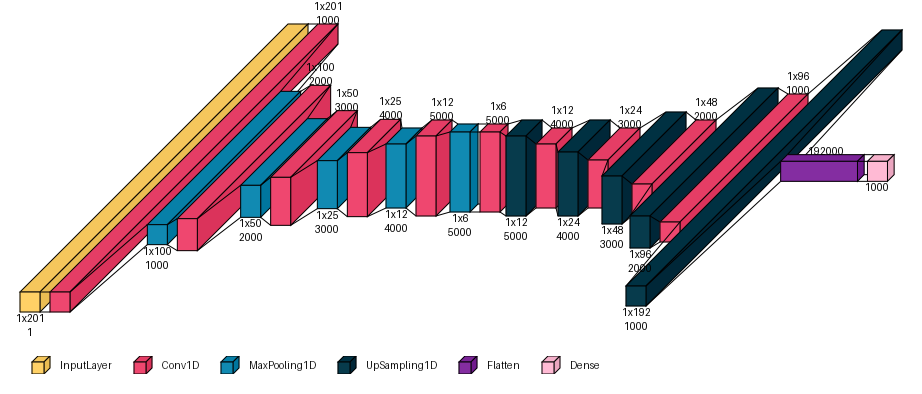

In [24]:
# from tensorflow.keras.utils import plot_model
# model = load_model(global_filepath + 'trained_model_n128_tau_p_0.024_reduction_100.keras', compile=True)
# # model = build_cnn((201,), (201,))  # Adjust input shape as needed
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

def mee(input_shape, output_shape, activation_output='linear', kernel_size=10):

    tf.keras.backend.clear_session()
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Encoder: 3 Conv1D + BatchNorm + MaxPooling + Dropout
    x = layers.Conv1D(filters=4, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(inputs)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)  # ReLU activation after BatchNorm
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=8, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=12, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(filters=16, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(filters=20, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Decoder: 3 Conv1D + BatchNorm + UpSampling + Dropout
    x = layers.Conv1D(filters=20, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.UpSampling1D(size=2)(x)
    
    x = layers.Conv1D(filters=16, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.UpSampling1D(size=2)(x)
    
    x = layers.Conv1D(filters=12, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.UpSampling1D(size=2)(x)

    x = layers.Conv1D(filters=8, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.UpSampling1D(size=2)(x)

    x = layers.Conv1D(filters=4, kernel_size=kernel_size, padding='same', activation=lambda x: tf.nn.leaky_relu(x, alpha=0.1))(x)
    # x = layers.Dropout(dropout_rate)(x)
    # x = layers.BatchNormalization()(x)  # BatchNorm after Conv
    # x = layers.ReLU()(x)
    x = layers.UpSampling1D(size=2)(x)
    
    # Dense layer to match output shape
    x = layers.Flatten()(x)
    outputs = layers.Dense(output_shape[-1], activation=activation_output)(x)
    
    # Model definition
    model = models.Model(inputs, outputs)
    
    return model

def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)

    if layer_index == 0: # Input layer
        output_shape = (1,201, 1)
    if layer_index == 1: # First Conv1D layer
        output_shape = (1,201, 1000) 
    if layer_index == 2: # MaxPooling1D layer
        output_shape = (1,100, 1000)
    if layer_index == 3: # Second Conv1D layer
        output_shape = (1,100, 2000)
    if layer_index == 4: # MaxPooling1D layer
        output_shape = (1,50, 2000)
    if layer_index == 5: # Third Conv1D layer
        output_shape = (1,50, 3000)
    if layer_index == 6: # MaxPooling1D layer
        output_shape = (1,25, 3000)
    if layer_index == 7: # Fourth Conv1D layer
        output_shape = (1,25, 4000)
    if layer_index == 8: # MaxPooling1D layer
        output_shape = (1,12, 4000)
    if layer_index == 9: # Fifth Conv1D layer
        output_shape = (1,12, 5000)
    if layer_index == 10: # MaxPooling1D layer
        output_shape = (1,6, 5000)
    if layer_index == 11: # Sixth Conv1D layer
        output_shape = (1,6, 5000)
    if layer_index == 12: # UpSampling layer
        output_shape = (1,12, 5000)
    if layer_index == 13: # Seventh Conv1D layer
        output_shape = (1,12, 4000)
    if layer_index == 14: # UpSampling layer
        output_shape = (1,24, 4000)
    if layer_index == 15: # Eighth Conv1D layer
        output_shape = (1,24, 3000)
    if layer_index == 16: # UpSampling layer
        output_shape = (1,48, 3000)
    if layer_index == 17: # Ninth Conv1D layer
        output_shape = (1,48, 2000)
    if layer_index == 18: # Ninth Conv1D layer
        output_shape = (1,96, 2000)
    if layer_index == 19: # Ninth Conv1D layer
        output_shape = (1,96, 1000)
    if layer_index == 20: # Ninth Conv1D layer
        output_shape = (1,192, 1000)
    if layer_index == 21: # Flatten
        output_shape = (192000,)
    if layer_index == 22: # Dense layer
        output_shape = (1000,)

    # Get the output shape of the layer
    # try:
    #     output_shape = [x for x in list(layer.output_shape) if x is not None]
    # except:
    #     output_shape = [x for x in list(layer.output_shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    # output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

import visualkeras

model = mee((201,1),(1000,1))
model.build(input_shape=(201,1))

# visualkeras.layered_view(model,legend=True).show() # display using your system viewer
visualkeras.layered_view(model,legend=True, to_file='output.png',text_callable=text_callable,padding=20) # write to disk
# visualkeras.layered_view(model,legend=True, to_file='output.png').show() # write and show

In [23]:
keras_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(2, activation="relu", name="layer1"),
        tf.keras.layers.Dense(3, activation="relu", name="layer2"),
        tf.keras.layers.Dense(4, name="layer3"),
    ]
)

x = tf.keras.ops.ones((3, 3))
y = keras_model(x)

input_shape = x.shape
for layer in keras_model.layers:
    output_shape = layer.compute_output_shape(input_shape)
    print(
        f"{layer.name}, "
        f"input_shape={input_shape}, "
        f"output_shape={output_shape}"
    )
    input_shape = output_shape

layer1, input_shape=(3, 3), output_shape=(3, 2)
layer2, input_shape=(3, 2), output_shape=(3, 3)
layer3, input_shape=(3, 3), output_shape=(3, 4)


In [24]:
def test_model_2_1f(t_points,*args,**kwargs):

    plot_cutoff=10**100

    def noise_spectrum_2_1f(omega,A1,A2,alpha1,alpha2):
        return noise_spectrum_1f(omega,A1,alpha1) + noise_spectrum_1f(omega,A2,alpha2)
    
    noise_profile = noise_spectrum_2_1f

    tf.keras.backend.clear_session()

    # Load the trained model
    model = load_model(global_filepath + 'trained_model_n_'+ str(int(kwargs["N"])) +'_tau_p_'+str(kwargs["tau_p"])+'.keras', compile=True)

    # frequency_points = np.pi / t_points 
    # frequency_points = np.logspace(np.log10(10**(-4)), np.log10(10**8), 10**3)
    frequency_points = np.logspace(np.log10(np.min(kwargs["omega_range"])), np.log10(np.max(kwargs["omega_range"])), model.output_shape[-1])
    print_range = sum(frequency_points < plot_cutoff)

    # frequency_points =  frequency_points[::100]

    print("A1: ", args[0])
    print("alpha1: ", args[2])
    print("A2: ", args[1])
    print("alpha2: ", args[3])
    info_text = f"Noise Profile: 2x 1/f\nA1: {args[0]:.2f}, α1: {args[2]:.2f}\nA1: {args[1]:.2f}, α1: {args[3]:.2f}"


    print("Assuming finite Filter Function Pulse Width")
    # coherence_profile_test, noise = generate_single_sample(t_points, N, tau_p, omega_range, peak_prominence, noise_profile,*args)
    integration_params = {}
    if kwargs.get("omega_range"):
        integration_params["omega_range"] = kwargs["omega_range"]
    if kwargs.get("omega_resolution"):
        integration_params["omega_resolution"] = kwargs["omega_resolution"]
    if kwargs.get("num_peaks_cutoff"):
        integration_params["num_peaks_cutoff"] = kwargs["num_peaks_cutoff"]
    if kwargs.get("peak_resolution"):
        integration_params["peak_resolution"] = kwargs["peak_resolution"]
            
    coherence_profile_test, _, _, _ = parallel_coherence_decay(t_points, kwargs["N"], kwargs["tau_p"], kwargs["integration_method"], noise_profile, *args, n_jobs=kwargs.get("n_jobs",None),batch_size=kwargs.get("batch_size",None), max_memory_per_worker=kwargs.get("max_memory_per_worker",1000), **integration_params)
    noise = noise_profile(frequency_points,*args)


    X_test = np.array((coherence_profile_test)).reshape((1,len(t_points)))

    # Predict noise spectrum
    # model.compile(optimizer=Adam(learning_rate=lr_schedule), loss = 'log_cosh') #loss='mse')
    predicted_noise_spectrum = model.predict(X_test).flatten()  # Flatten to get a 1D array

    if noise_profile == noise_spectrum_1f:
        fit_length = sum(frequency_points < 10**0)
        l2_norm = np.linalg.norm(noise[:fit_length]-np.expm1(predicted_noise_spectrum)[:fit_length],ord=2)/np.linalg.norm(noise[:fit_length])

        def linear(x,m,b):
            return m*x + b
        
        x_data = frequency_points[:fit_length]
        y_data = np.expm1(predicted_noise_spectrum[:fit_length])

        # Initial parameter guesses
        p0 = [-5,15]

        # Perform the curve fit
        popt, cov = curve_fit(linear, np.log10(x_data), np.log10(y_data), p0=p0, maxfev = 10000)


        # Extracted parameters
        alpha, b = popt

        # # Add a text box with fitted parameters in the second subplot
        textstr = f'Fitted parameters: \n S(ω) = Aω^α \nA = {10**b:.4e}\nα = {alpha:.4f}'

        y_fit = 10**linear(np.log10(x_data), *popt)

    else:
        l2_norm = np.linalg.norm(noise-np.expm1(predicted_noise_spectrum),ord=2)/np.linalg.norm(noise)
    
    
    # Create a figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle("N = "+ str(kwargs["N"]) + ", τ_p = "+str(kwargs["tau_p"]))
    
    # First subplot
    ax1.plot(t_points, X_test[0,:])
    ax1.set_xlabel('Time (µs)')
    ax1.set_ylabel('Coherence Decay C(t)')
    ax1.set_xscale('log')
    # ax1.set_yscale('log')
    ax1.set_title(f'Coherence Decay Profile, C(t)')
    
    # Second subplot
    # ax2.plot(frequency_points, np.expm1(predicted_noise_spectrum), '-c', label='Exp Predicted Noise Spectrum')
    # ax2.plot(frequency_points, noise, 'or', alpha=0.4, markersize=2, label='True Noise Spectrum')
    ax2.plot(frequency_points[:print_range], np.expm1(predicted_noise_spectrum)[:print_range], '-c', label='NN Predicted Noise Spectrum')
    ax2.plot(frequency_points[:print_range], noise[:print_range], 'red',linestyle=":", label='True Noise Spectrum')
    if noise_profile == noise_spectrum_1f:
        ax2.plot(frequency_points[:print_range], 10**linear(np.log10(frequency_points)[:print_range], *popt), "green",linestyle="--", label='Fitted Curve')
        # Add text box to ax2
        ax2.text(0.7, 0.7, textstr, transform=ax2.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Noise Spectrum')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # ax2.set_title(f'Noise Spectral Density, S(w)')
    ax2.set_title(f'l2 norm between NN prediction and actual= {l2_norm:.2f}')
    ax2.legend()

    # Add text box to ax2 in bottom left corner
    ax2.text(0.05, 0.05, info_text,
            transform=ax2.transAxes,
            verticalalignment='bottom',  # Changed from 'top' to 'bottom'
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add some spacing between subplots

    plt.tight_layout()
    plt.show()

    # plt.plot(frequency_points, np.expm1(predicted_noise_spectrum), '-c', label='Exp Predicted Noise Spectrum')
    # # plt.loglog(frequency_points, predicted_noise_spectrum, '-k', label='Predicted Noise Spectrum')

    # plt.plot(frequency_points, noise, 'or', alpha=0.4, markersize=2, label='True Noise Spectrum')
    # plt.xlabel('Frequency')
    # plt.ylabel('Noise Spectrum')
    # plt.title('Predicted Noise Spectrum from Coherence Profile')
    # plt.legend()

    del model

    # if noise_profile == noise_spectrum_1f:
    #     return t_points,X_test[0,:],frequency_points[:print_range],np.expm1(predicted_noise_spectrum)[:print_range], noise[:print_range],10**b ,alpha
    # else:
    #     return t_points,X_test[0,:],frequency_points[:print_range],np.expm1(predicted_noise_spectrum)[:print_range], noise[:print_range],None,None
    
meme = {
    "N": 128, #CPMG-N (test spin echo)
    "tau_p": 24*10**(-3), #pi pulse width in mircoseconds
    "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
    "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t)
    "omega_range": (10**(-4), 10**8), # The frequency range for integration
    "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. Only use top peaks in integration
    "peak_resolution": 100, # Additional points around singular points of the filter function
}

# youyou = np.concatenate((np.random.choice(A_values,2),np.random.choice(alpha_values,2)))
youyou = [90,3,1,2]
t_points = np.logspace(np.log10(meme["N"]*meme["tau_p"]+1e-10), np.log10(300), 201)

test_model_2_1f(t_points,*youyou,**meme)

: 

In [25]:
def test_model(t_points, rand=True, assume_delta=True, plot_cutoff=10**100,*args,**kwargs):

    tf.keras.backend.clear_session()

    # Load the trained model
    model = load_model(global_filepath + 'trained_model_n_'+ str(int(kwargs["N"])) +'_tau_p_'+str(kwargs["tau_p"])+'.keras', compile=True)

    # frequency_points = np.pi / t_points 
    # frequency_points = np.logspace(np.log10(10**(-4)), np.log10(10**8), 10**3)
    frequency_points = np.logspace(np.log10(np.min(kwargs["omega_range"])), np.log10(np.max(kwargs["omega_range"])), model.output_shape[-1])
    print_range = sum(frequency_points < plot_cutoff)

    # frequency_points =  frequency_points[::100]

    if rand == True:
        # Define the functions for generating noise and coherence profiles
        noise_profiles = [noise_spectrum_1f,noise_spectrum_lor]
        noise_profile = random.choice(noise_profiles)
        # print(noise_profile.__name__)
        # Randomly choose parameters within the range of parameter values trianed on
        if noise_profile == noise_spectrum_1f:
            args = [np.random.uniform(np.min(A_values),np.max(A_values),1)[0], np.random.uniform(np.min(alpha_values),np.max(alpha_values),1)[0]]
            # print("A: ", args[0])
            # print("alpha: ", args[1])
        elif noise_profile == noise_spectrum_lor:
            args = [np.random.uniform(np.min(omega_0_values),np.max(omega_0_values),1)[0], np.random.uniform(np.min(gamma_values),np.max(gamma_values),1)[0], np.random.uniform(np.min(A_values),np.max(A_values),1)[0]]
            # print("omega_0: ", args[0])
            # print("gamma: ", args[1])
            # print("A: ", args[2])
    else:
        noise_profile = kwargs['noise_profile']

    # print(noise_profile.__name__)
    # print(*args)

    if noise_profile == noise_spectrum_1f:
        print("A: ", args[0])
        print("alpha: ", args[1])
        info_text = f"Noise Profile: 1/f\nA: {args[0]:.2f}\nα: {args[1]:.2f}"
    elif noise_profile == noise_spectrum_lor:
        print("omega_0: ", args[0])
        print("gamma: ", args[1])
        print("A: ", args[2])
        info_text = f"Noise Profile: Lorentzian\nω₀: {args[0]:.2f}\nγ: {args[1]:.2f}\nA: {args[2]:.2f}"
    elif noise_profile == noise_spectrum_combination:
        print("A: ", args[0]["A"])
        print("alpha: ", args[0]["alpha"])
        print("omega_0: ", args[1]["omega_0"])
        print("gamma: ", args[1]["gamma"])
        print("A: ", args[1]["A"])
        print("C: ", args[2]["C"])
        info_text = (f"Noise Profile: Combination\n"
            f"A_1f: {args[0]['A'][0]:.2f}\nα: {args[0]['alpha'][0]:.2f}\n"
            f"ω₀: {args[1]['omega_0'][0]:.2f}\nγ: {args[1]['gamma'][0]:.2f}\n"
            f"A_lor: {args[1]['A'][0]:.2f}\nC: {args[2]['C'][0]:.2f}")

    if assume_delta == True:
        # need to fix
        print("Assuming Filter Function Pulse Width is a delta function")
        coherence_profile_test, noise = generate_single_sample_delta(t_points, noise_profile,*args)
    else:
        print("Assuming finite Filter Function Pulse Width")
        # coherence_profile_test, noise = generate_single_sample(t_points, N, tau_p, omega_range, peak_prominence, noise_profile,*args)
        integration_params = {}
        if kwargs.get("omega_range"):
            integration_params["omega_range"] = kwargs["omega_range"]
        if kwargs.get("omega_resolution"):
            integration_params["omega_resolution"] = kwargs["omega_resolution"]
        if kwargs.get("num_peaks_cutoff"):
            integration_params["num_peaks_cutoff"] = kwargs["num_peaks_cutoff"]
        if kwargs.get("peak_resolution"):
            integration_params["peak_resolution"] = kwargs["peak_resolution"]
                
        coherence_profile_test, _, _, _ = parallel_coherence_decay(t_points, kwargs["N"], kwargs["tau_p"], kwargs["integration_method"], noise_profile, *args, n_jobs=kwargs.get("n_jobs",None),batch_size=kwargs.get("batch_size",None), max_memory_per_worker=kwargs.get("max_memory_per_worker",1000), **integration_params)
        noise = noise_profile(frequency_points,*args)


    X_test = np.array((coherence_profile_test)).reshape((1,len(t_points)))

    # Predict noise spectrum
    # model.compile(optimizer=Adam(learning_rate=lr_schedule), loss = 'log_cosh') #loss='mse')
    predicted_noise_spectrum = model.predict(X_test).flatten()  # Flatten to get a 1D array

    fit_length = sum(frequency_points < 10**0)
    l2_norm = np.linalg.norm(noise[:fit_length]-np.expm1(predicted_noise_spectrum)[:fit_length],ord=2)/np.linalg.norm(noise[:fit_length])

    if noise_profile == noise_spectrum_1f:
        def linear(x,m,b):
            return m*x + b
        
        x_data = frequency_points[:fit_length]
        y_data = np.expm1(predicted_noise_spectrum[:fit_length])

        # Initial parameter guesses
        p0 = [-5,15]

        # Perform the curve fit
        popt, cov = curve_fit(linear, np.log10(x_data), np.log10(y_data), p0=p0, maxfev = 10000)


        # Extracted parameters
        alpha, b = popt

        # # Add a text box with fitted parameters in the second subplot
        textstr = f'Fitted parameters: \n '+r'$S(\omega) = \frac{A}{\omega^\alpha}$'+ f' \nA = {10**b:.4f}\nα = {-alpha:.4f}'

        # y_fit = 10**linear(np.log10(x_data), *popt)
    
    
    # Create a figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle("n = "+ str(kwargs["N"]) + ", "+ r"$\tau_p$"+" = "+str(kwargs["tau_p"])+r" $\mu$s")
    
    # First subplot
    ax1.plot(t_points, X_test[0,:])
    ax1.set_xlabel('Time (µs)')
    ax1.set_ylabel('Coherence Decay C(t)')
    ax1.set_xscale('log')
    # ax1.set_yscale('log')
    ax1.set_title(f'Coherence Decay Profile, C(t)')
    ax2.set_title(r'Noise Spectral Density, $S(\omega)$')
    
    # Second subplot
    # ax2.plot(frequency_points, np.expm1(predicted_noise_spectrum), '-c', label='Exp Predicted Noise Spectrum')
    # ax2.plot(frequency_points, noise, 'or', alpha=0.4, markersize=2, label='True Noise Spectrum')
    ax2.plot(frequency_points[:print_range], np.expm1(predicted_noise_spectrum)[:print_range], '-c', label='NN Predicted Noise Spectrum')
    ax2.plot(frequency_points[:print_range], noise[:print_range], 'red', label='True Noise Spectrum')

    if noise_profile == noise_spectrum_1f:
        ax2.plot(frequency_points[:print_range], 10**linear(np.log10(frequency_points)[:print_range], *popt), "green",linestyle="--", label='Fitted Curve')
        # Add text box to ax2
        ax2.text(0.7, 0.7, textstr, transform=ax2.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
        
    ax2.set_xlabel(r'$\omega$ (MHz)')
    ax2.set_ylabel(r'$S(\omega)$')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # ax2.set_title(f'Noise Spectral Density, S(w)')
    # ax2.set_title(f'l2 norm between NN prediction and actual= {l2_norm:.2f}')
    ax2.legend()

    # Add text box to ax2 in bottom left corner
    ax2.text(0.05, 0.05, info_text,
            transform=ax2.transAxes,
            verticalalignment='bottom',  # Changed from 'top' to 'bottom'
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add some spacing between subplots

    plt.tight_layout()
    plt.show()

    # plt.plot(frequency_points, np.expm1(predicted_noise_spectrum), '-c', label='Exp Predicted Noise Spectrum')
    # # plt.loglog(frequency_points, predicted_noise_spectrum, '-k', label='Predicted Noise Spectrum')

    # plt.plot(frequency_points, noise, 'or', alpha=0.4, markersize=2, label='True Noise Spectrum')
    # plt.xlabel('Frequency')
    # plt.ylabel('Noise Spectrum')
    # plt.title('Predicted Noise Spectrum from Coherence Profile')
    # plt.legend()

    del model

    if noise_profile == noise_spectrum_1f:
        return t_points,X_test[0,:],frequency_points[:print_range],np.expm1(predicted_noise_spectrum)[:print_range], noise[:print_range],10**b ,alpha
    else:
        return t_points,X_test[0,:],frequency_points[:print_range],np.expm1(predicted_noise_spectrum)[:print_range], noise[:print_range],None,None

In [26]:
# repeats = 1
# test_As = np.random.choice(A_values,repeats)
# test_alphas = np.random.choice(alpha_values,repeats)
# test_omega_0s = np.random.choice(omega_0_values,repeats)
# test_gammas = np.random.choice(gamma_values,repeats)
# test_lor_As = np.random.choice(lor_A_values,repeats)
# test_combo1 = np.random.choice(combo_args[0],repeats)
# test_combo2 = np.random.choice(combo_args[1],repeats)
# test_Cs = np.random.choice(combo_args[2],repeats)

# plot_cutoff = 10**100


# for n in [1,8,128,256,512]:
#     finite_width_params = {
#         "N": n, #CPMG-N (test spin echo)
#         "tau_p": 24*10**(-3), #pi pulse width in mircoseconds
#         "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
#         "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t), unless method is "quad", in which case, this is the resolution used to determine the filter function and integrand outputs.
#         "omega_range" : (10**(-4),10**8), # The number of peaks to use in the filter function
#         "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. If this value is set, then only the top num_peaks_cutoff peaks will be used in the integration. This can be useful for speeding up the integration when the noise spectrum has many peaks.
#         "peak_resolution": 100, # For every method except "quad", you can specify additional points around the singular points of the filter function. This argument specifies the number of points to use around each singular point.
#         # "quad_limit": 10**5, # The maximum number of subdivisions in the adaptive quadrature algorithm
#         # "epsabs": 1.49e-8, # Absolute tolerance for the quadrature integration
#         # "epsrel": 1.49e-8, # Relative tolerance for the quadrature integration
#     }
#     t_points = np.logspace(np.log10(finite_width_params["N"]*finite_width_params["tau_p"]+1e-10), np.log10(300), 201) 

#     # test_model(t_points,False,False,random.choice(A_values),random.choice(alpha_values),noise_profile=noise_spectrum_1f,**finite_width_params)
#     # test_model(t_points,False,False,random.choice(omega_0_values),random.choice(gamma_values),random.choice(lor_A_values),noise_profile=noise_spectrum_lor,**finite_width_params)
#     # test_model(t_points,True,False,**finite_width_params)

#     print("##############################################")
#     print("N = ", n)
#     print("##############################################")
#     print()
#     print("1/f Noise")
#     for i in range(repeats):
#         print(str(i+1) + "/" + str(repeats))
#         tps, C_t, frequency_points, NN_prediction, true_noise, A, alpha = test_model(t_points,False,False,plot_cutoff,test_As[i],test_alphas[i],noise_profile=noise_spectrum_1f,**finite_width_params)
#     print()
#     print("lor Noise")
#     for i in range(repeats):
#         print(str(i+1) + "/" + str(repeats))
#         tps, C_t, frequency_points, NN_prediction, true_noise, A, alpha = test_model(t_points,False,False,plot_cutoff,test_omega_0s[i],test_gammas[i],test_lor_As[i],noise_profile=noise_spectrum_lor,**finite_width_params)
#     print()
#     print("1/f + lor Noise")
#     for i in range(repeats):
#         print(str(i+1) + "/" + str(repeats))
#         tps, C_t, frequency_points, NN_prediction, true_noise, A, alpha = test_model(t_points,False,False,plot_cutoff,test_combo1[i],test_combo2[i],test_Cs[i],noise_profile=noise_spectrum_combination,**finite_width_params)
#     print()
#     print("Random Noises")
#     for i in range(repeats):
#         tps, C_t, frequency_points, NN_prediction, true_noise, A, alpha = test_model(t_points,True,False,plot_cutoff,**finite_width_params)

##############################################
N =  128
##############################################


Lor Noise
1/8
omega_0:  30978244.35676793
gamma:  1979187.1436649994
A:  47685598.009832695
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   26.6s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   57.6s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


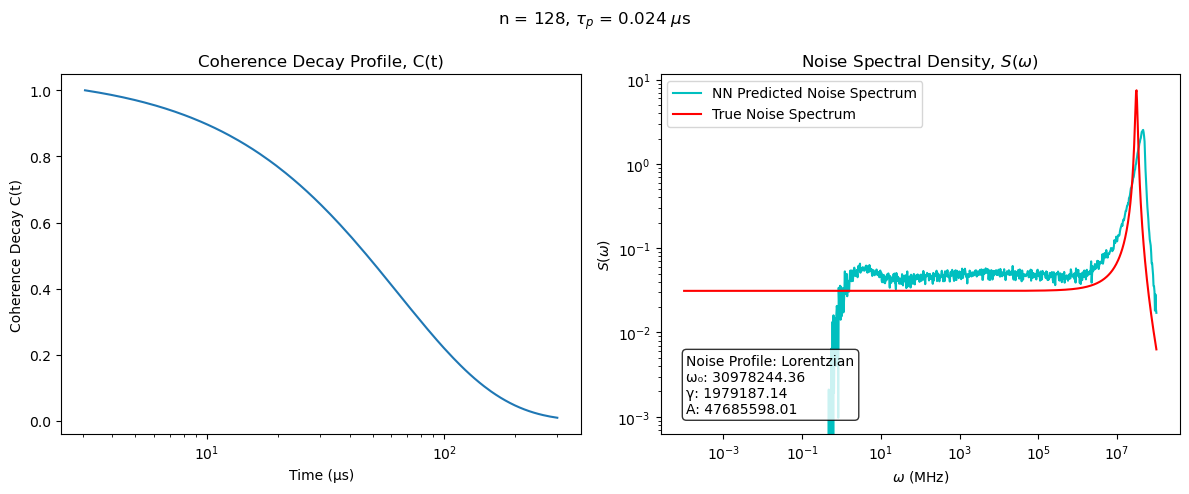

2/8
omega_0:  5205034.057693452
gamma:  8177147.9923704695
A:  505264687.5481665
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   22.5s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   53.9s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


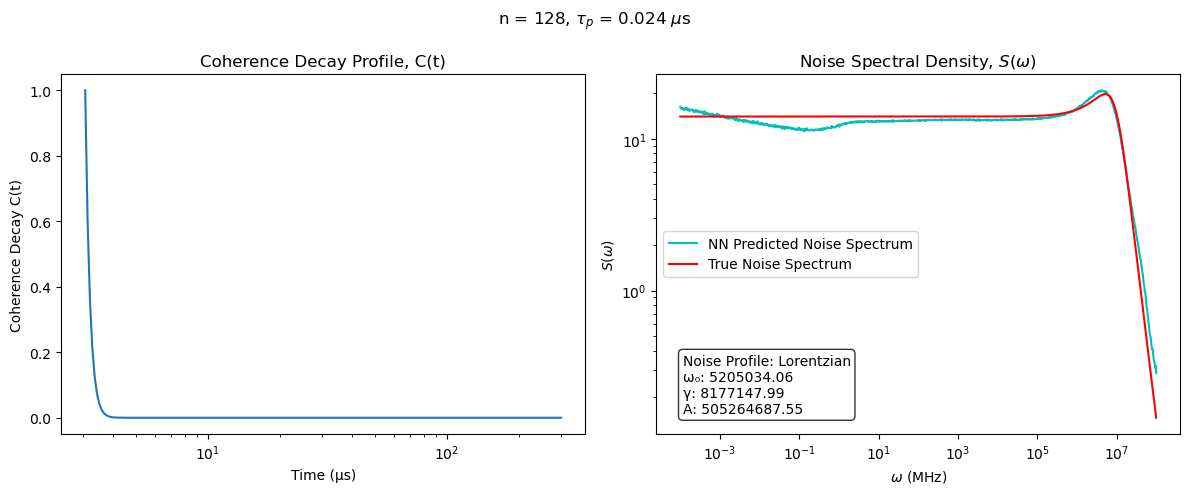

3/8
omega_0:  16247562.422457844
gamma:  4440701.664668241
A:  170750953.65845433
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   23.2s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   55.2s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


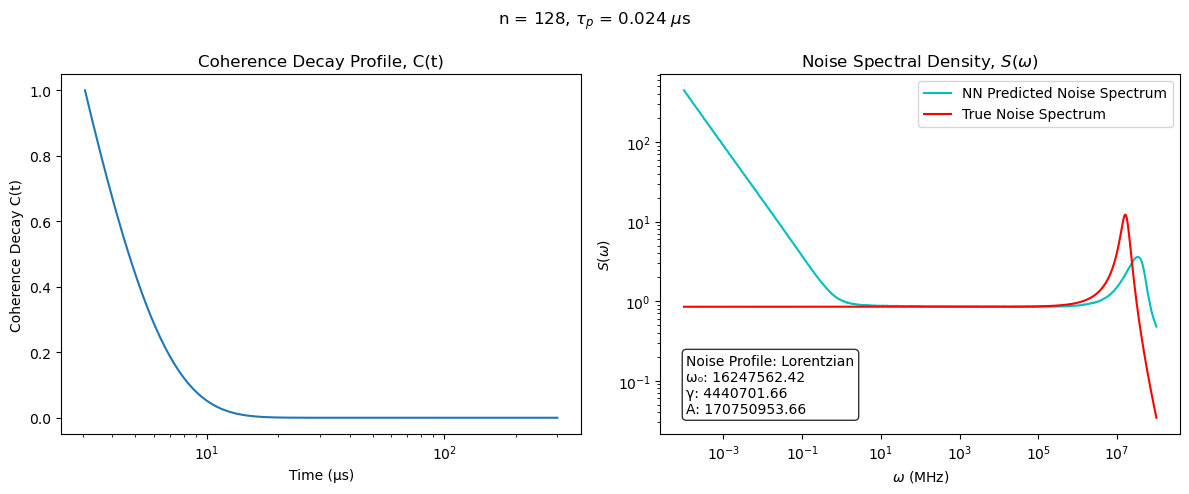

4/8
omega_0:  29908768.429294102
gamma:  1777554.758902708
A:  653627532.1563588
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   19.6s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   49.3s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


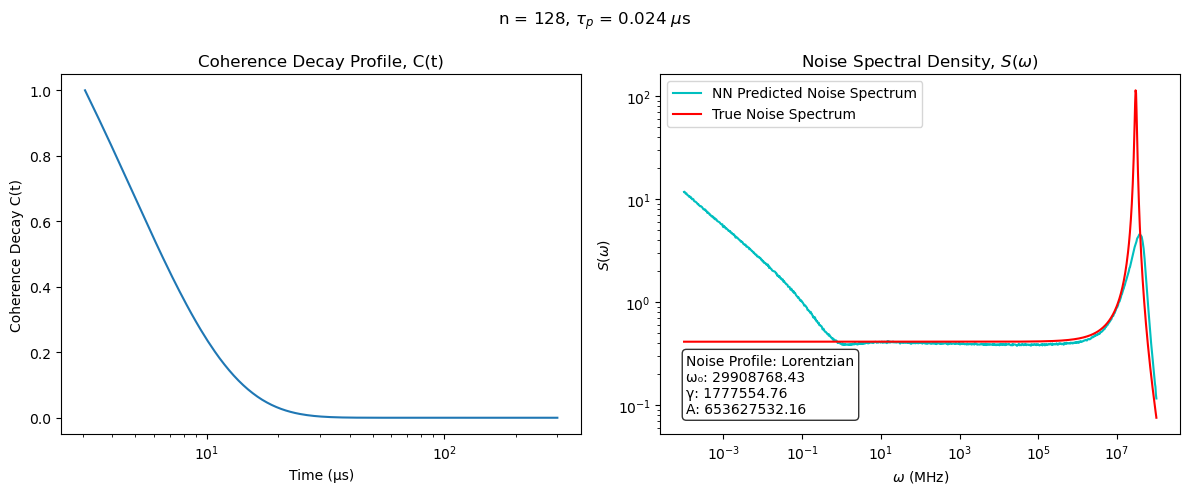

5/8
omega_0:  31628424.45621732
gamma:  9928716.888626786
A:  958946530.296307
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   22.3s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   50.8s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


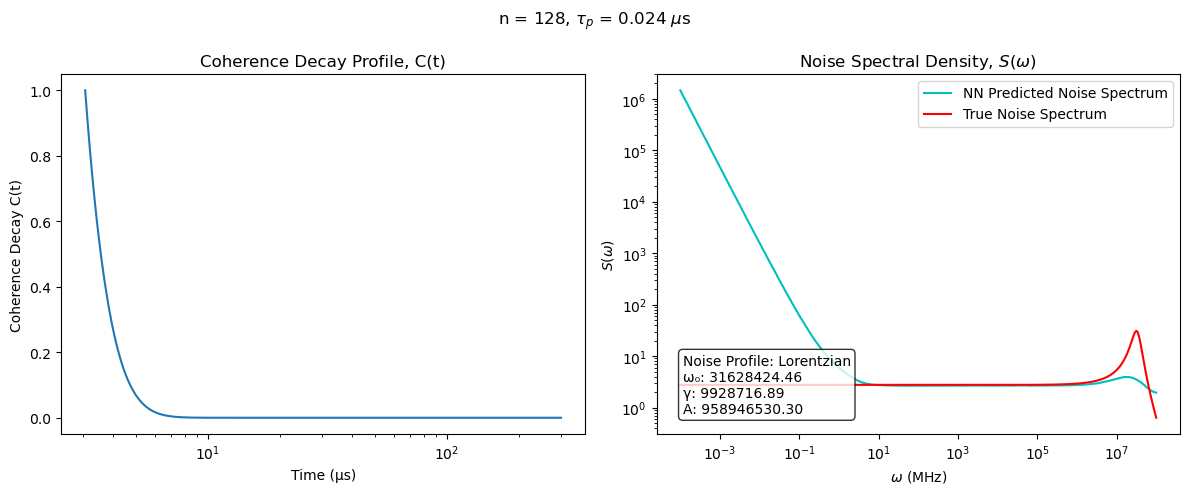

6/8
omega_0:  22097209.100107916
gamma:  7421566.418571872
A:  238363096.32970268
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   21.3s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   50.1s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ -1s -683001us/step


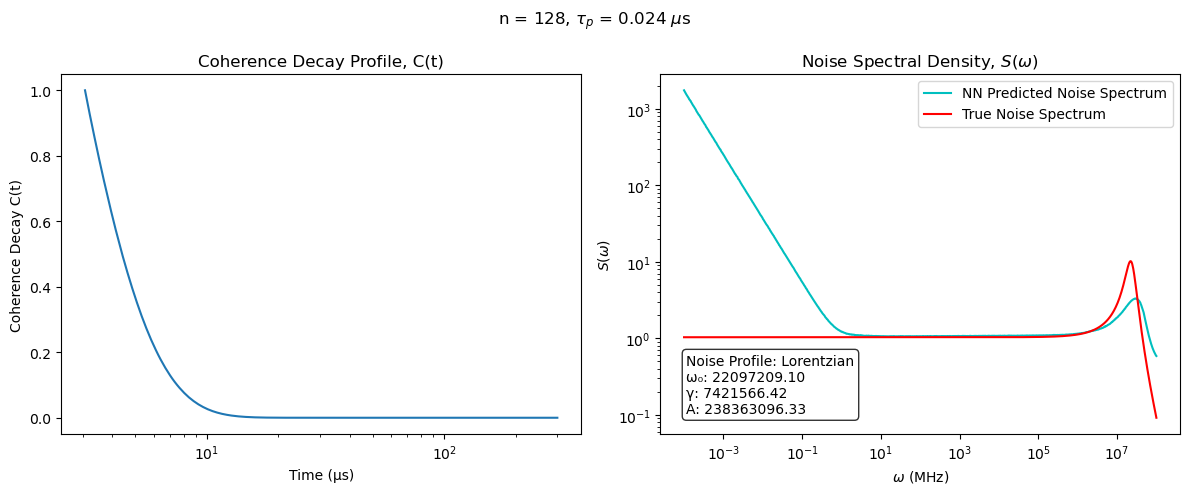

7/8
omega_0:  5715546.147491479
gamma:  9642024.00115712
A:  809796593.0331709
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   20.8s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   50.5s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


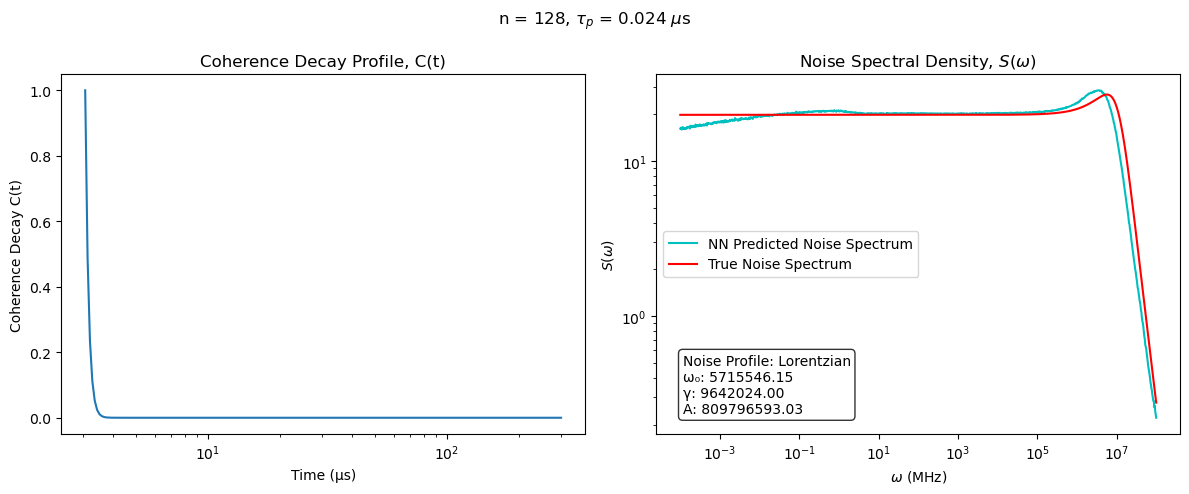

8/8
omega_0:  30303567.57471262
gamma:  1805750.8679514807
A:  463163206.43110144
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   21.6s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:   51.4s finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


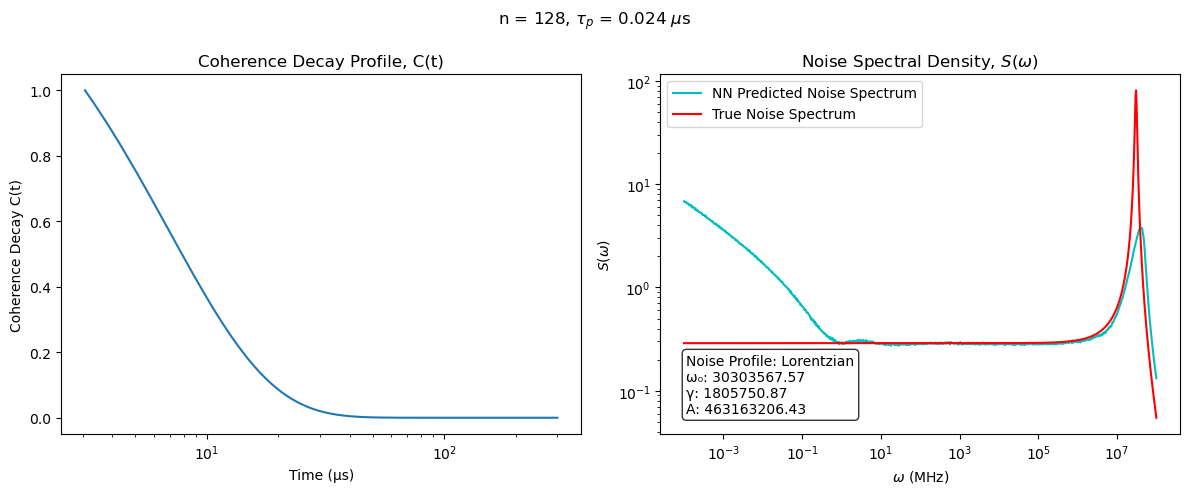


1/f + lor Noise
1/8
A:  [90.14500028824503]
alpha:  [2.7913193790106368]
omega_0:  [49966090.66721245]
gamma:  [7183271.716923639]
A:  [36467683.72914397]
C:  [3.839440243474186]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   32.7s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.2min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


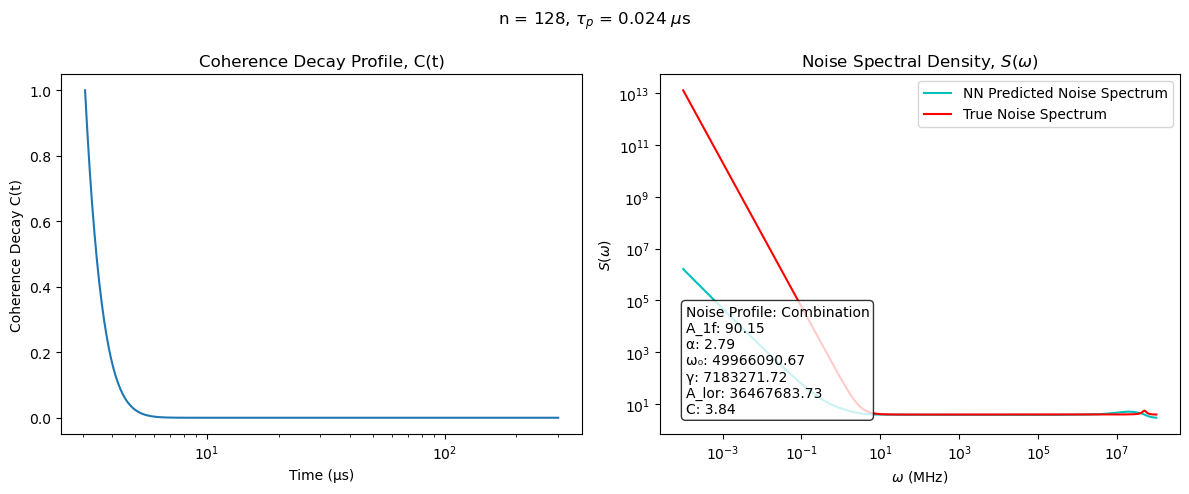

2/8
A:  [43.641580677462514]
alpha:  [1.2766562284503677]
omega_0:  [32581285.5550509]
gamma:  [9113437.76919404]
A:  [412636499.33645785]
C:  [9.47711216204292]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   30.3s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.3min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


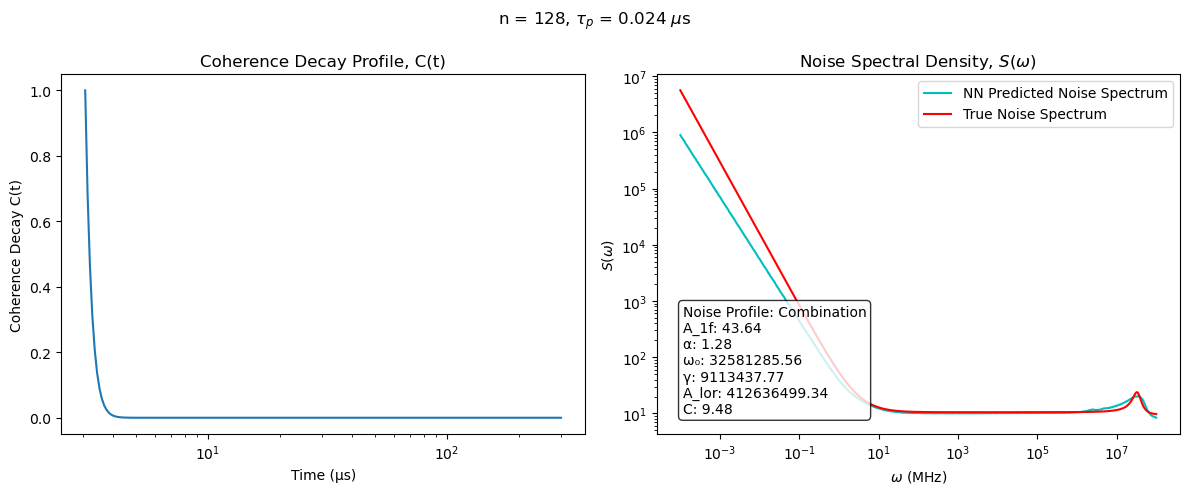

3/8
A:  [44.09462289875453]
alpha:  [0.6065542306954954]
omega_0:  [31301353.866187997]
gamma:  [1626392.7677591625]
A:  [621094652.7593057]
C:  [5.366962229656053]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   28.9s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.1min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


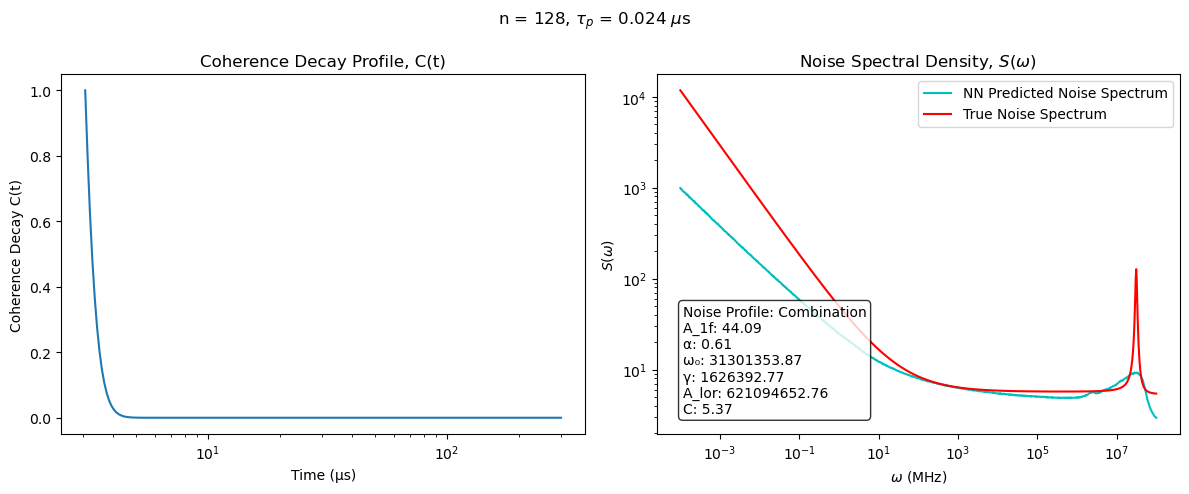

4/8
A:  [64.07311845354607]
alpha:  [0.774920289379657]
omega_0:  [40085397.1323025]
gamma:  [7878075.4363749]
A:  [543556198.7467692]
C:  [1.710686999984855]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   29.6s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.1min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


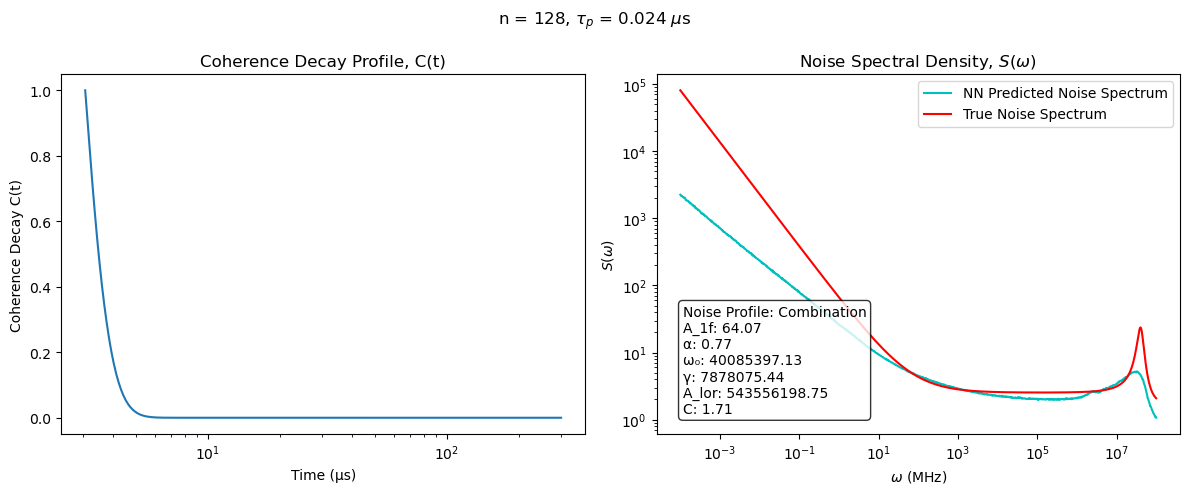

5/8
A:  [60.415476742421895]
alpha:  [0.8303697320691418]
omega_0:  [2342474.1364274137]
gamma:  [803032.6143357854]
A:  [391526827.8650678]
C:  [2.2563687932724807]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   28.5s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.2min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


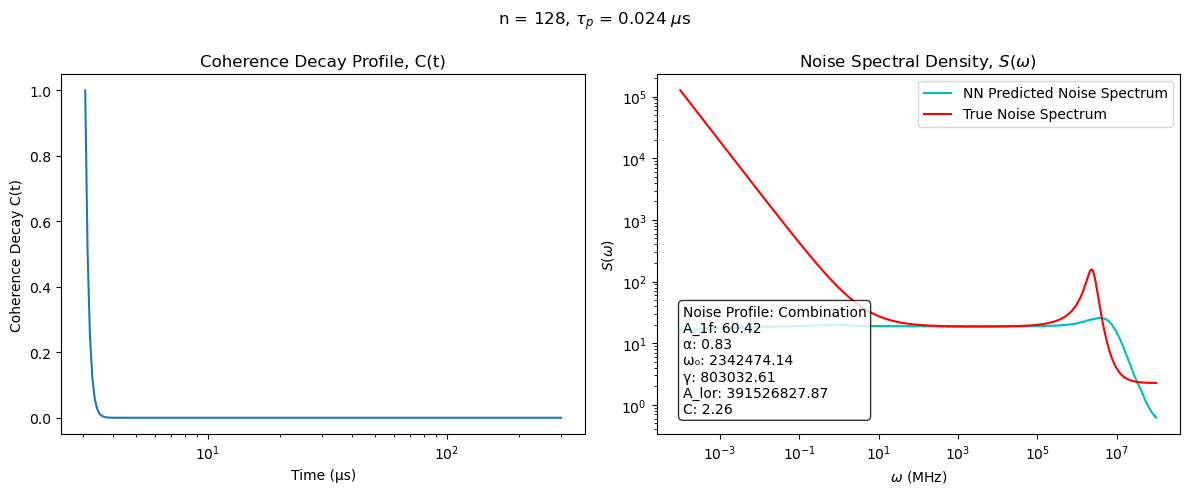

6/8
A:  [28.7498651307203]
alpha:  [2.8109106958333334]
omega_0:  [17278159.02323122]
gamma:  [9496123.770623405]
A:  [896202399.6199774]
C:  [8.062306872435482]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   28.7s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.1min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


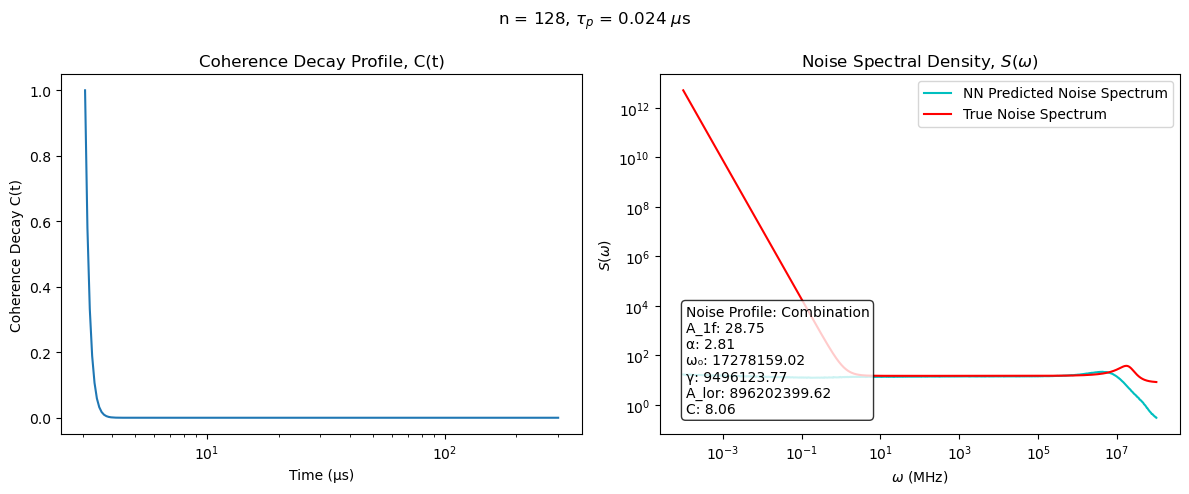

7/8
A:  [33.268990272338414]
alpha:  [1.8021424742039032]
omega_0:  [28282492.02751198]
gamma:  [96501.81485260687]
A:  [720943543.6442211]
C:  [6.275716224260762]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   27.8s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.1min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


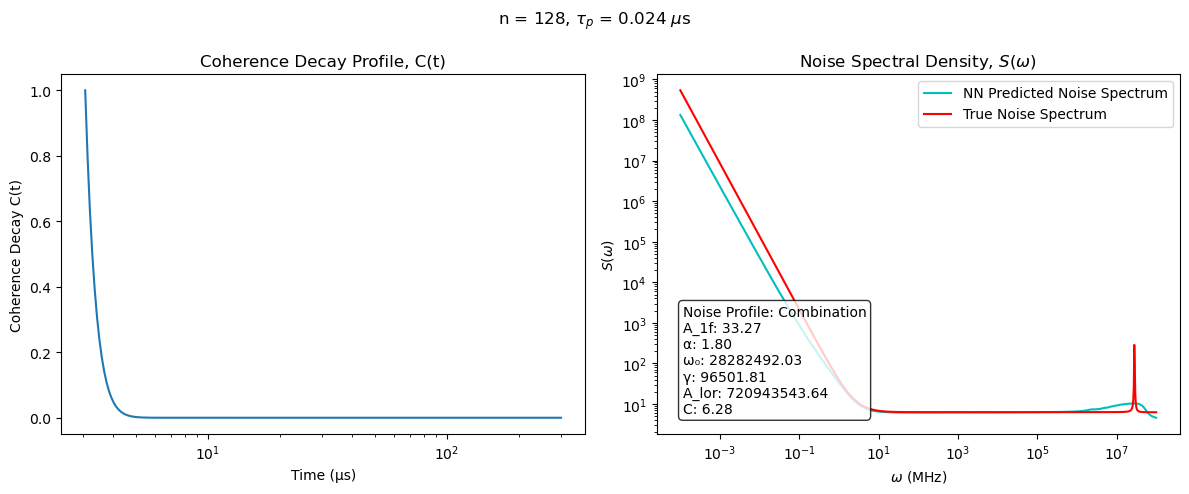

8/8
A:  [14.177900843360103]
alpha:  [1.483252178125246]
omega_0:  [43101695.572517395]
gamma:  [4398608.653214429]
A:  [29125178.690684963]
C:  [0.7026165706710641]
Assuming finite Filter Function Pulse Width

Attempting execution with 16 CPUs...
16
Using 16 CPUs with batch size 3


Processing batches:   0%|          | 0/67 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   27.9s
[Parallel(n_jobs=16)]: Done  67 out of  67 | elapsed:  1.1min finished


Successfully completed using 16 CPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


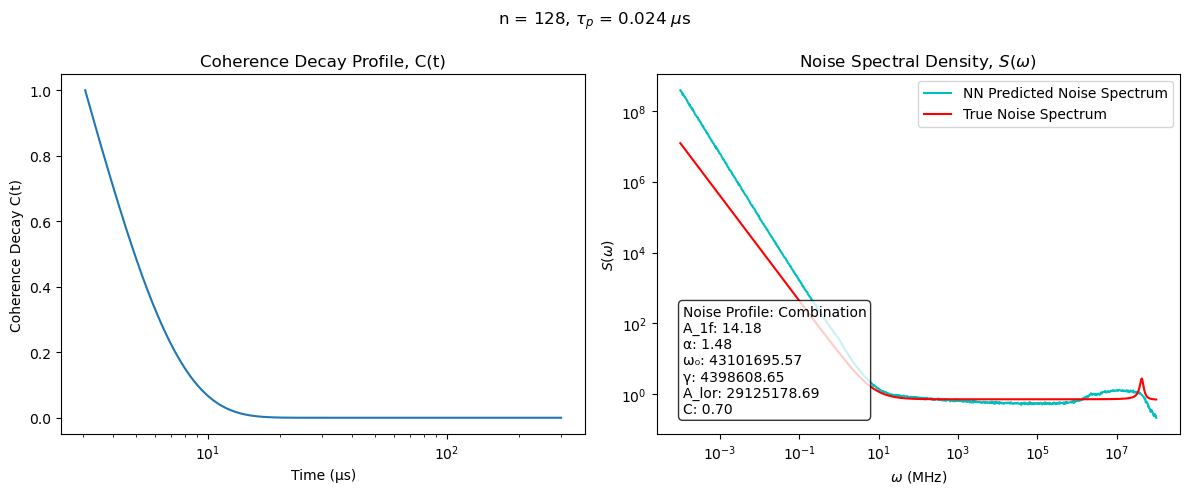

In [28]:
# Store results for later plotting
results = {
    "1/f": defaultdict(list),
    "lor": defaultdict(list),
    "1/f + lor": defaultdict(list),
    "Random": defaultdict(list)
}

repeats = 8
plot_cutoff = 10**100

# test_As = np.random.choice(A_values, repeats)
# test_alphas = np.random.choice(alpha_values, repeats)
# test_omega_0s = np.random.choice(omega_0_values, repeats)
# test_gammas = np.random.choice(gamma_values, repeats)
# test_lor_As = np.random.choice(lor_A_values, repeats)
# test_combo1 = np.random.choice(combo_args[0], repeats)
# test_combo2 = np.random.choice(combo_args[1], repeats)
# test_Cs = np.random.choice(combo_args[2], repeats)

# Assuming A_values and alpha_values define your ranges
A_min, A_max = min(A_values), max(A_values)
alpha_min, alpha_max = min(alpha_values), max(alpha_values)

# For Lorentzian parameters
omega_0_min, omega_0_max = min(omega_0_values), max(omega_0_values)
gamma_min, gamma_max = min(gamma_values), max(gamma_values)
lor_A_min, lor_A_max = min(lor_A_values), max(lor_A_values)

# # Assuming A_values and alpha_values define your ranges
# A_min, A_max = 1, 1
# alpha_min, alpha_max = 1, 1

# # For Lorentzian parameters
# omega_0_min, omega_0_max = 10**3, 10**5
# gamma_min, gamma_max = 10**-1, 10**3
# lor_A_min, lor_A_max = 10**4, 10**6

# For white noise parameter
c_min, c_max = 0, 10  # Based on your np.linspace(0, 10, 10)

# Generate random dictionaries
test_combo1 = [
    {"A": [np.random.uniform(A_min, A_max)], 
     "alpha": [np.random.uniform(alpha_min, alpha_max)]} 
    for _ in range(repeats)
]

test_combo2 = [
    {"omega_0": [np.random.uniform(omega_0_min, omega_0_max)],
     "gamma": [np.random.uniform(gamma_min, gamma_max)],
     "A": [np.random.uniform(lor_A_min, lor_A_max)]}
    for _ in range(repeats)
]

test_Cs = [
    {"C": [np.random.uniform(c_min, c_max)]}
    for _ in range(repeats)
]


test_As = np.random.uniform(A_min, A_max, repeats)
test_alphas = np.random.uniform(alpha_min, alpha_max, repeats)
test_omega_0s = np.random.uniform(omega_0_min, omega_0_max, repeats)
test_gammas = np.random.uniform(gamma_min, gamma_max, repeats)
test_lor_As = np.random.uniform(lor_A_min, lor_A_max, repeats)

# test_As = [7.0526e+1,5.9437e+1,1.9639e+1,9.0403e+00]
# test_alphas = [1,1,1,1]


# Run simulations and collect data
# for n in [1, 8, 128, 256, 512]:
for n in [128]:
    finite_width_params = {
        "N": n, #CPMG-N (test spin echo)
        "tau_p": 24*10**(-3), #pi pulse width in mircoseconds
        "integration_method": "trapezoid", # The method to use for integration. Options are "quad","trapezoid",and "simpson".
        "omega_resolution": int(10**5), # 6*10**5 The number of points to use when integrating to yield the coherence decay profile, C(t)
        "omega_range": (10**(-4), 10**8), # The frequency range for integration
        "num_peaks_cutoff": 100, # must be >=0 and <num_peaks. Only use top peaks in integration
        "peak_resolution": 100, # Additional points around singular points of the filter function
    }
    
    t_points = np.logspace(np.log10(finite_width_params["N"]*finite_width_params["tau_p"]+1e-10), np.log10(300), 201)
    
    print("##############################################")
    print("N = ", n)
    print("##############################################")
    print()
    
    # # 1/f Noise
    # print("1/f Noise")
    # for i in range(repeats):
    #     print(f"{i+1}/{repeats}")
    #     tps, C_t, frequency_points, NN_prediction, true_noise, A, alpha = test_model(
    #         t_points, False, False, plot_cutoff, test_As[i], test_alphas[i], 
    #         noise_profile=noise_spectrum_1f, **finite_width_params
    #     )
    #     # Store results
    #     results["1/f"][n].append({
    #         "tps": tps,
    #         "C_t": C_t,
    #         "frequency_points": frequency_points,
    #         "NN_prediction": NN_prediction,
    #         "true_noise": true_noise,
    #         "params": {"A": test_As[i], "alpha": test_alphas[i]}
    #     })
    
    # Lorentzian Noise
    print("\nLor Noise")
    for i in range(repeats):
        print(f"{i+1}/{repeats}")
        tps, C_t, frequency_points, NN_prediction, true_noise, _, _n= test_model(
            t_points, False, False, plot_cutoff, test_omega_0s[i], test_gammas[i], test_lor_As[i],
            noise_profile=noise_spectrum_lor, **finite_width_params
        )
        # Store results
        results["lor"][n].append({
            "tps": tps,
            "C_t": C_t,
            "frequency_points": frequency_points,
            "NN_prediction": NN_prediction,
            "true_noise": true_noise,
            "params": {"omega_0": test_omega_0s[i], "gamma":  test_gammas[i], "lor_A": test_lor_As[i]}
        })
    
    # Combined 1/f + Lorentzian Noise
    print("\n1/f + lor Noise")
    for i in range(repeats):
        print(f"{i+1}/{repeats}")
        tps, C_t, frequency_points, NN_prediction, true_noise, _, _ = test_model(
            t_points, False, False, plot_cutoff, test_combo1[i], test_combo2[i], test_Cs[i],
            noise_profile=noise_spectrum_combination, **finite_width_params
        )
        # Store results
        results["1/f + lor"][n].append({
            "tps": tps,
            "C_t": C_t,
            "frequency_points": frequency_points,
            "NN_prediction": NN_prediction,
            "true_noise": true_noise,
            "params": {"combo1": test_combo1[i], "combo2": test_combo2[i], "C": test_Cs[i]}
        })
    
    # # Random Noises
    # print("\nRandom Noises")
    # for i in range(repeats):
    #     print(f"{i+1}/{repeats}")
    #     tps, C_t, frequency_points, NN_prediction, true_noise, _, _ = test_model(
    #         t_points, True, False, plot_cutoff, **finite_width_params
    #     )
    #     # Store results
    #     results["Random"][n].append({
    #         "tps": tps,
    #         "C_t": C_t,
    #         "frequency_points": frequency_points,
    #         "NN_prediction": NN_prediction,
    #         "true_noise": true_noise,
    #         # "params": {"A": A, "alpha": alpha}  # These might be different for random case
    #     })

A:  70.526
alpha:  1


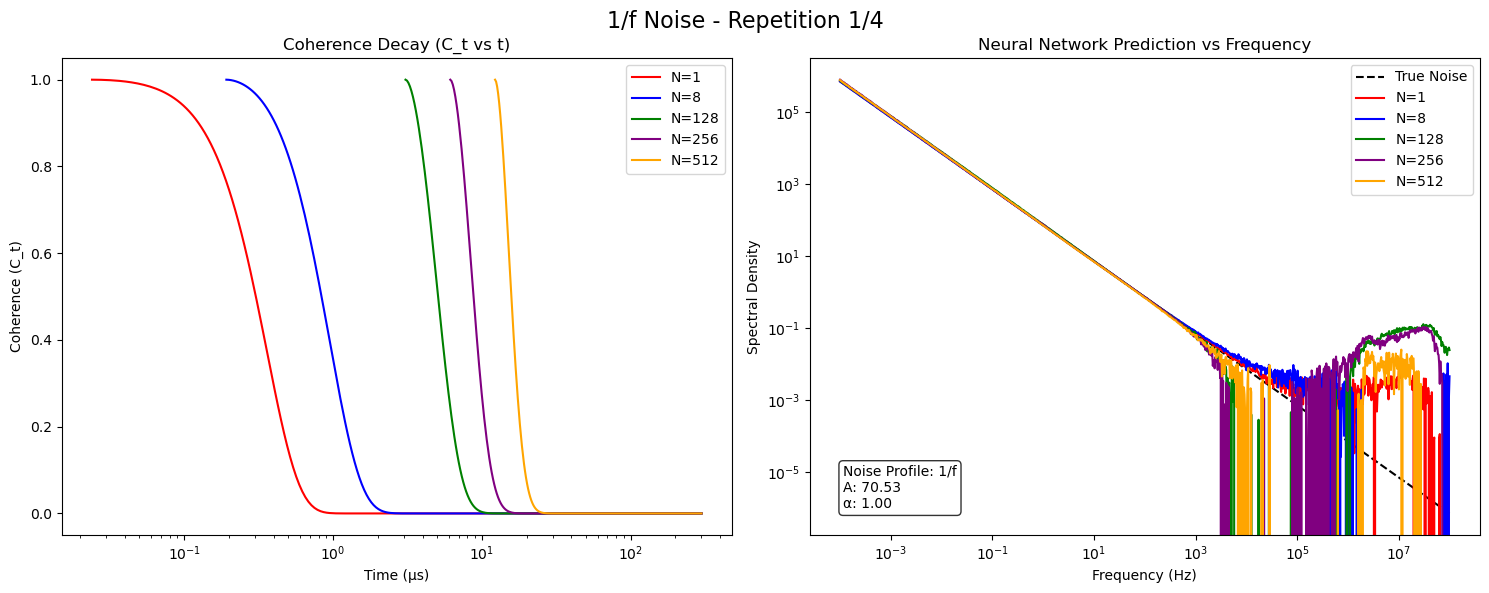

A:  59.437
alpha:  1


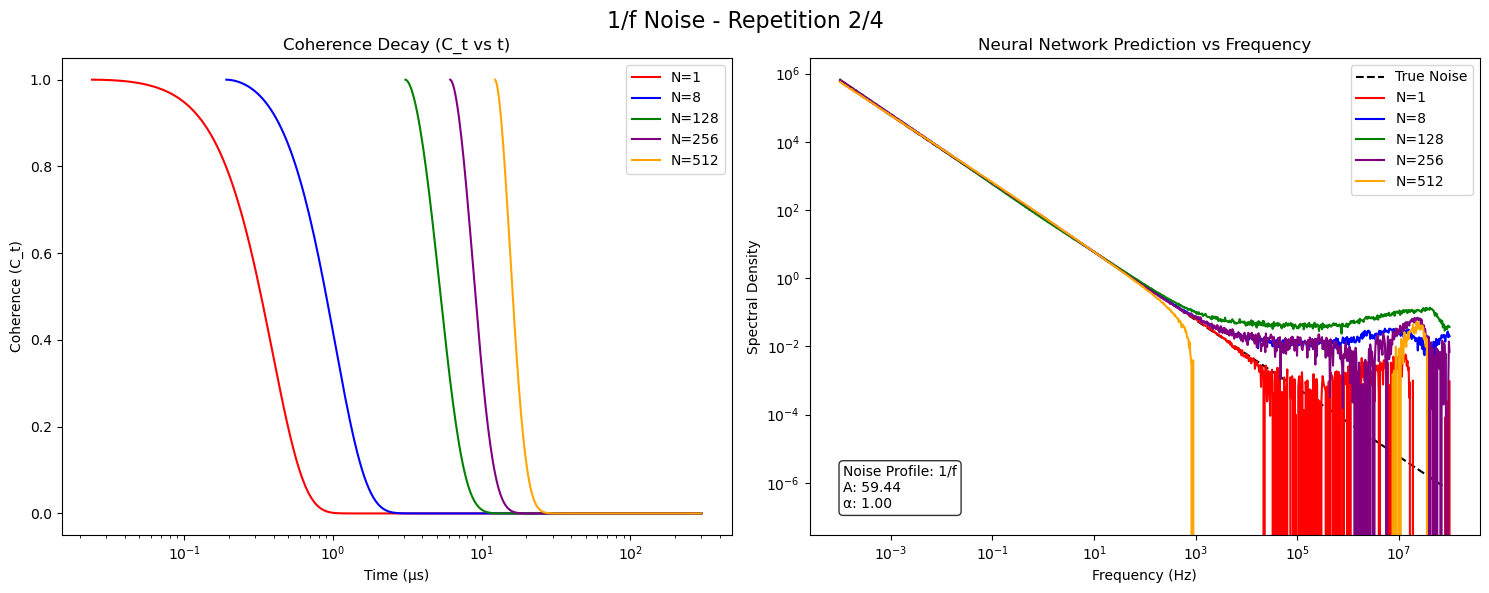

A:  19.639
alpha:  1


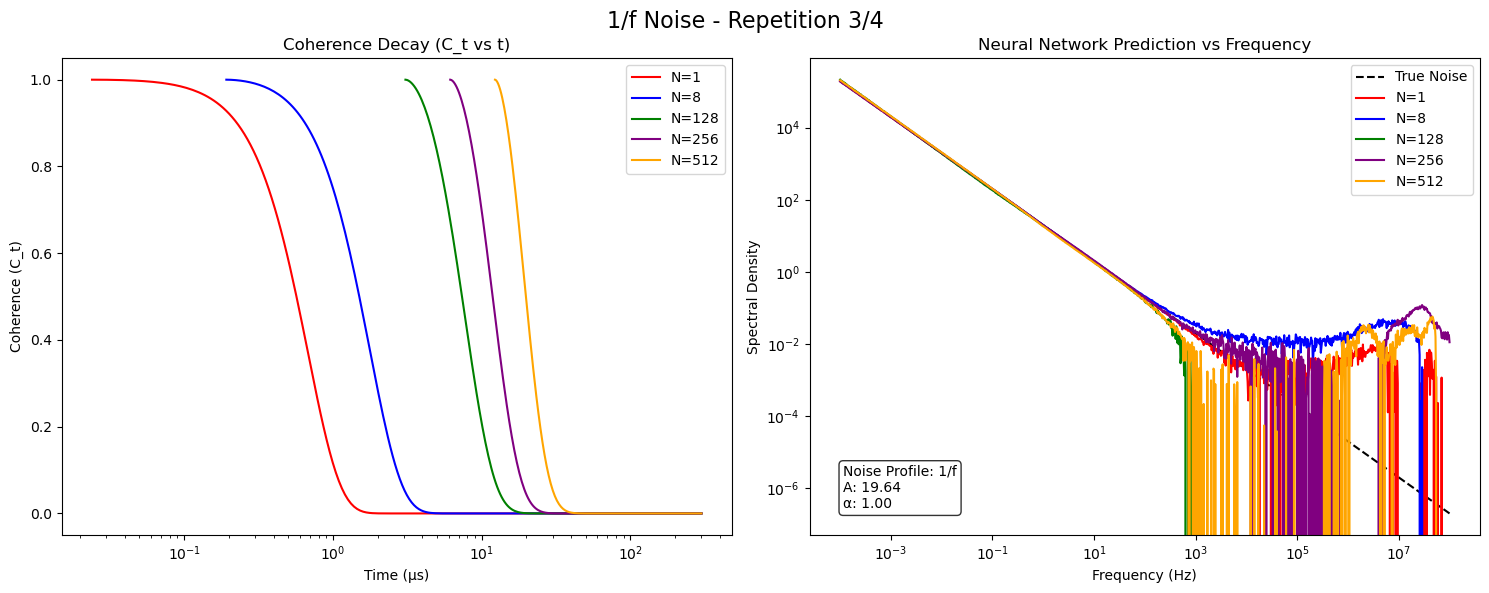

A:  9.0403
alpha:  1


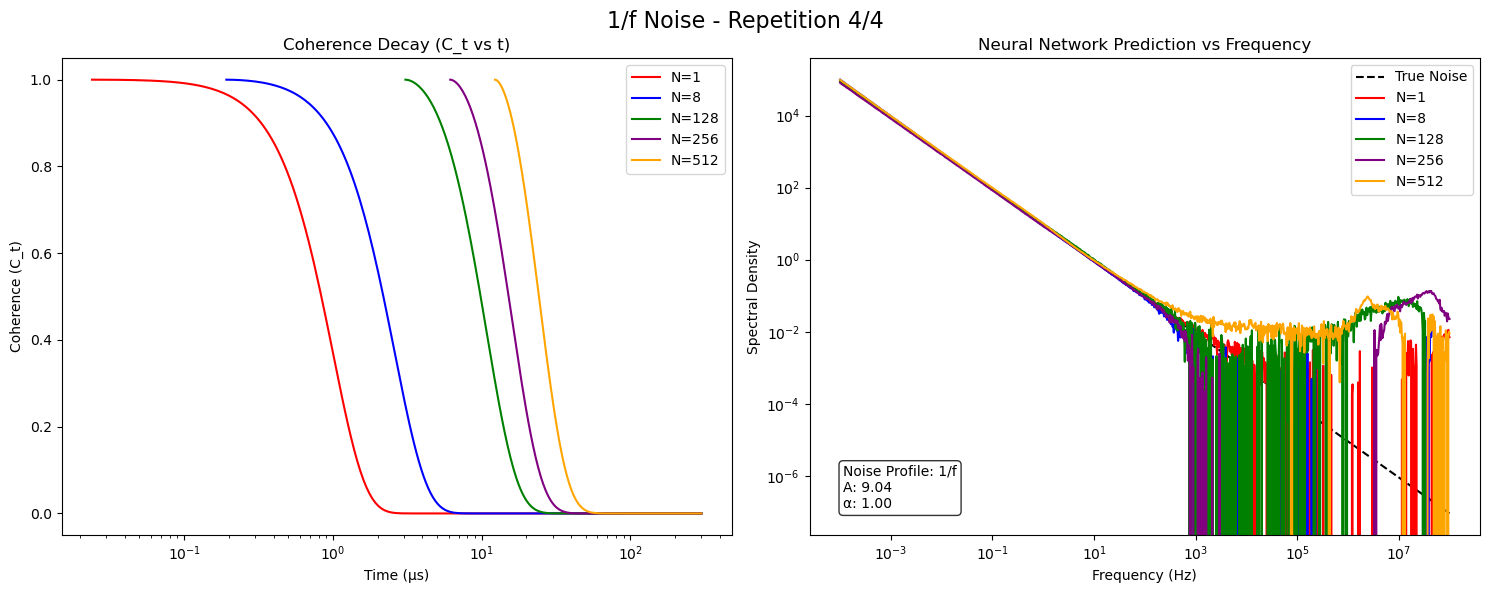

In [28]:
# Plotting code for CPMG analysis results
# This would be in a separate cell

# Define colors for different N values
colors = {
    1: 'red',
    8: 'blue', 
    128: 'green',
    256: 'purple',
    512: 'orange'
}

# noise_types = ["1/f", "lor", "1/f + lor", "Random"]
# noise_types = ["1/f", "lor", "1/f + lor"]
noise_types = ["1/f"]
n_values = [1, 8, 128, 256, 512]

# Create plots for each repetition and noise type
for noise_type in noise_types:
    for rep in range(repeats):

        # args = results[noise_type][1][rep]["params"]
        args = list(results[noise_type][1][rep]["params"].values())

        try:
            if noise_type == "1/f":
                print("A: ", args[0])
                print("alpha: ", args[1])
                info_text = f"Noise Profile: 1/f\nA: {args[0]:.2f}\nα: {args[1]:.2f}"
            elif noise_type == "lor":
                print("omega_0: ", args[0])
                print("gamma: ", args[1])
                print("A: ", args[2])
                info_text = f"Noise Profile: Lorentzian\nω₀: {args[0]:.2f}\nγ: {args[1]:.2f}\nA: {args[2]:.2f}"
            elif noise_type == "1/f + lor":
                print("A: ", args[0]["A"])
                print("alpha: ", args[0]["alpha"])
                print("omega_0: ", args[1]["omega_0"])
                print("gamma: ", args[1]["gamma"])
                print("A: ", args[1]["A"])
                print("C: ", args[2]["C"])

                info_text = (f"Noise Profile: Combination\n"
                    f"A_1f: {args[0]['A'][0]:.2f}\nα: {args[0]['alpha'][0]:.2f}\n"
                    f"ω₀: {args[1]['omega_0'][0]:.2f}\nγ: {args[1]['gamma'][0]:.2f}\n"
                    f"A_lor: {args[1]['A'][0]:.2f}\nC: {args[2]['C'][0]:.2f}")
        except Exception as e:
            print(e)
            info_text = None
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"{noise_type} Noise - Repetition {rep+1}/{repeats}", fontsize=16)
        
        # Left subplot - C_t vs tps
        axes[0].set_title("Coherence Decay (C_t vs t)")
        axes[0].set_xlabel("Time (μs)")
        axes[0].set_ylabel("Coherence (C_t)")
        axes[0].set_xscale('log')
        
        # Right subplot - Neural Network Prediction vs frequency
        axes[1].set_title("Neural Network Prediction vs Frequency")
        axes[1].set_xlabel("Frequency (Hz)")
        axes[1].set_ylabel("Spectral Density")
        axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        
        # Add true noise spectrum to right subplot if available
        # Get the first N value's data to extract frequency points and true noise
        if results[noise_type][n_values[0]] and rep < len(results[noise_type][n_values[0]]):
            freq_points = results[noise_type][n_values[0]][rep]["frequency_points"]
            true_noise = results[noise_type][n_values[0]][rep]["true_noise"]
            axes[1].plot(freq_points, true_noise, 'k--', label=f"True Noise")
        
        # Plot data for each N value
        for n in n_values:
            # Skip if no data for this N and repetition
            if n not in results[noise_type] or rep >= len(results[noise_type][n]):
                continue
                
            data = results[noise_type][n][rep]
            
            # Plot C_t vs tps (left subplot)
            axes[0].plot(data["tps"], data["C_t"], color=colors[n], label=f"N={n}")
            
            # Plot NN prediction vs frequency (right subplot)
            axes[1].plot(data["frequency_points"], data["NN_prediction"], color=colors[n], label=f"N={n}")
        
        # Add legends
        axes[0].legend()
        axes[1].legend()

        try:
            # Add text box to ax2 in bottom left corner
            axes[1].text(0.05, 0.05, info_text,
                transform=axes[1].transAxes,
                verticalalignment='bottom',  # Changed from 'top' to 'bottom'
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),zorder=10)
        except Exception as e:
            print(e)
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
        # Save figure if needed
        if noise_type == "1/f":
            plt.savefig(global_filepath + f"1f_A{args[0]}_alpha{args[1]}.png", dpi=300)
        elif noise_type == "lor":
            plt.savefig(global_filepath + f"lor_omega0{args[0]}_gamma{args[1]}_A{args[2]}.png", dpi=300)
        elif noise_type == "1/f + lor":
            plt.savefig(global_filepath + f"combo_A1f{args[0]['A'][0]}_alpha{args[0]['alpha'][0]}_omega0{args[1]['omega_0'][0]}_gamma{args[1]['gamma'][0]}_A{args[1]['A'][0]}_C{args[2]['C'][0]}.png", dpi=300)
        
        plt.show()

# # You can also create a consolidated plot with all noise types
# # for comparison if desired
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# fig.suptitle(f"Comparison of Different Noise Types", fontsize=16)

# for idx, noise_type in enumerate(noise_types):
#     row, col = idx // 2, idx % 2
#     ax = axes[row, col]
#     ax.set_title(f"{noise_type} Noise")
#     ax.set_xlabel("Time (μs)")
#     ax.set_ylabel("Coherence (C_t)")
#     ax.set_xscale('log')
    
#     # Plot first repetition for each N value
#     for n in n_values:
#         if n in results[noise_type] and results[noise_type][n]:
#             data = results[noise_type][n][0]  # First repetition
#             ax.plot(data["tps"], data["C_t"], color=colors[n], label=f"N={n}")
    
#     ax.legend()

# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.show()

A:  70.526
alpha:  1


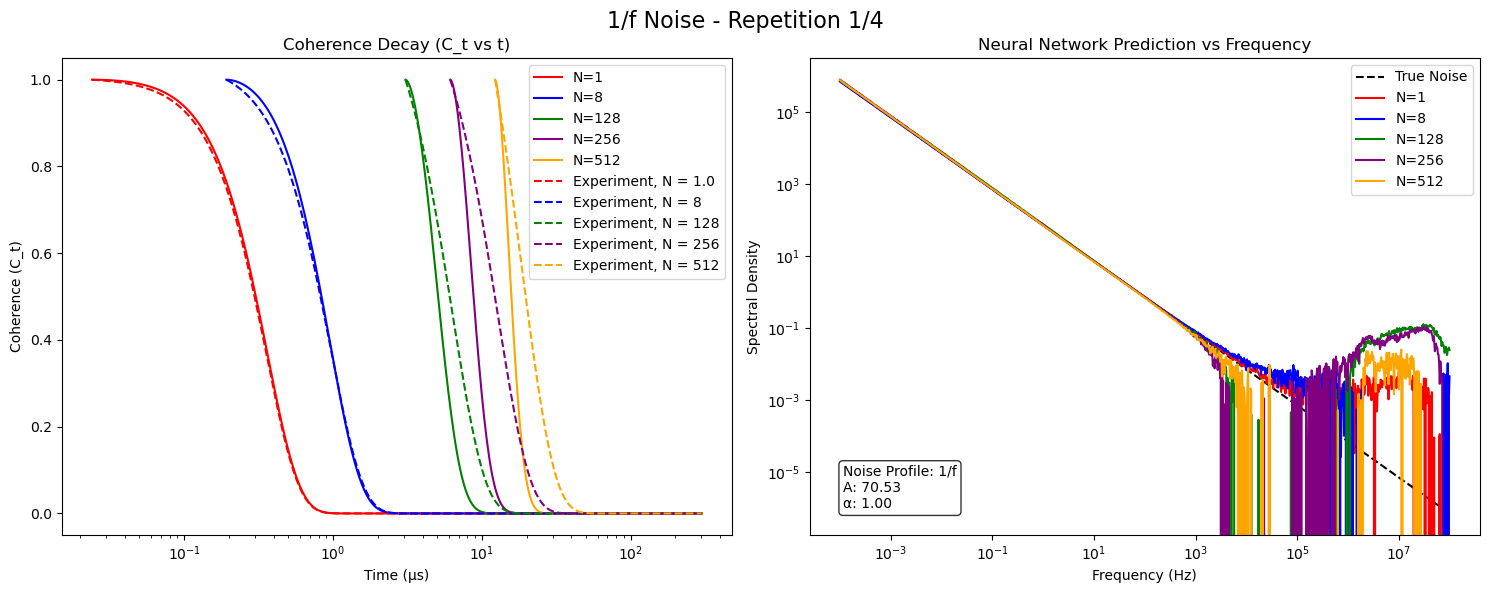

A:  59.437
alpha:  1


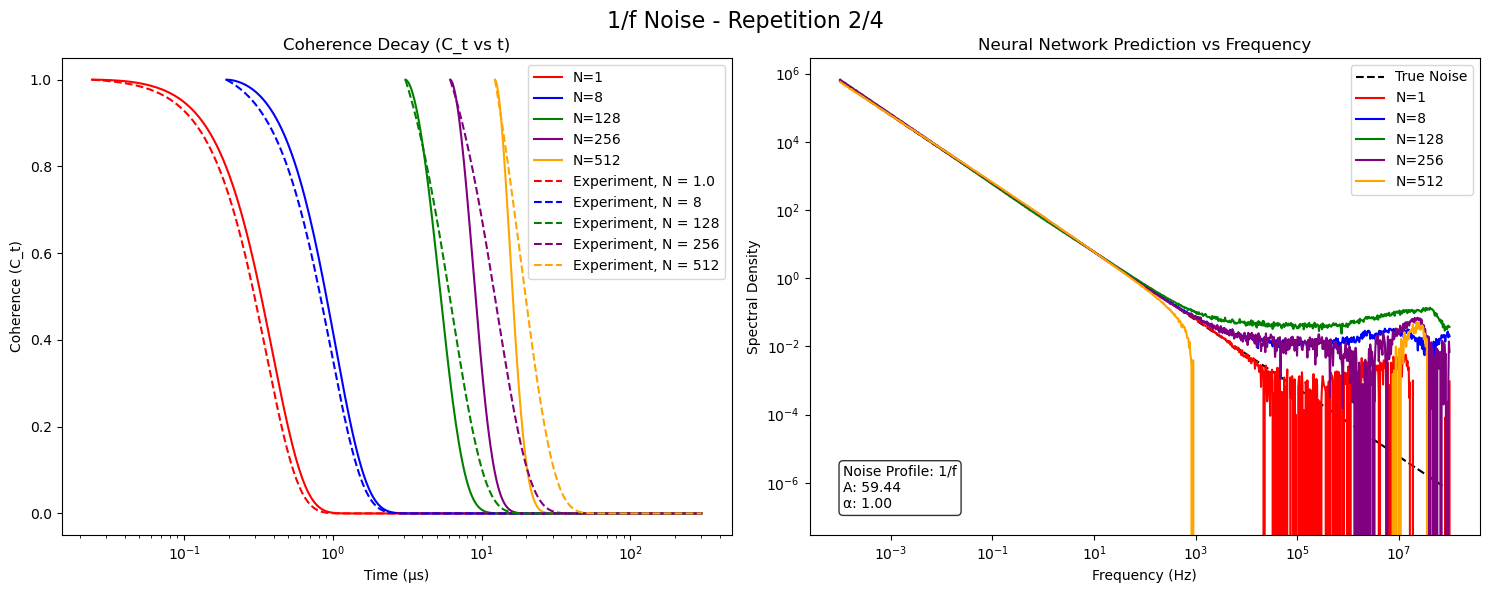

A:  19.639
alpha:  1


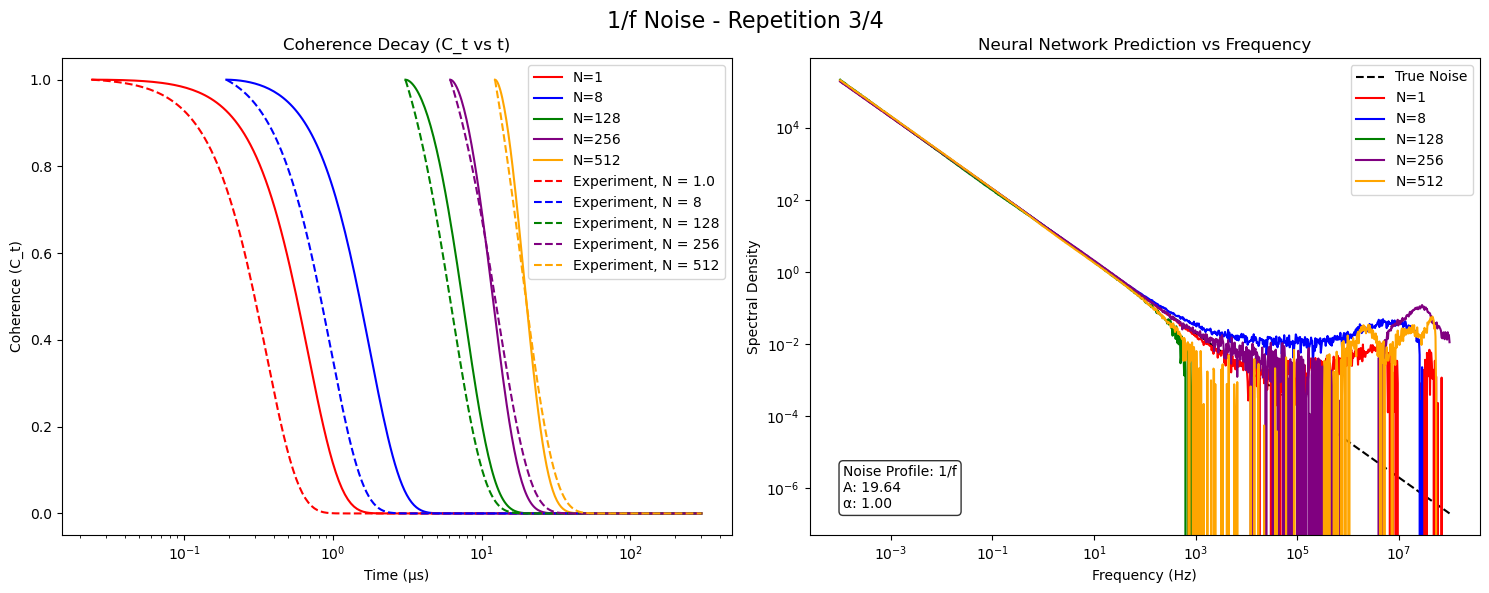

A:  9.0403
alpha:  1


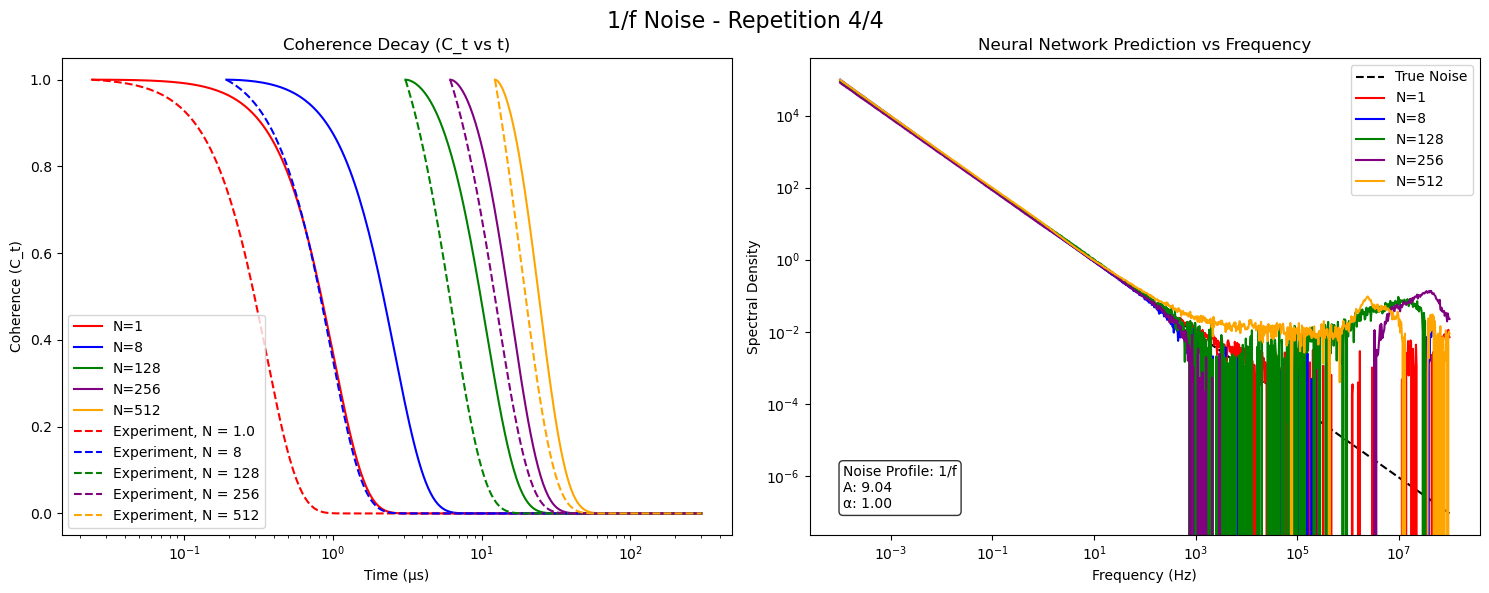

In [29]:
import json
# Plotting code for CPMG analysis results
# This would be in a separate cell

# Define colors for different N values
colors = {
    1: 'red',
    8: 'blue', 
    128: 'green',
    256: 'purple',
    512: 'orange'
}

# noise_types = ["1/f", "lor", "1/f + lor", "Random"]
noise_types = ["1/f"]
# noise_types = ["lor", "1/f + lor"]
n_values = [1, 8, 128, 256, 512]

# Create plots for each repetition and noise type
for noise_type in noise_types:
    for rep in range(repeats):

        # args = results[noise_type][1][rep]["params"]
        args = list(results[noise_type][1][rep]["params"].values())

        try:
            if noise_type == "1/f":
                print("A: ", args[0])
                print("alpha: ", args[1])
                info_text = f"Noise Profile: 1/f\nA: {args[0]:.2f}\nα: {args[1]:.2f}"
            elif noise_type == "lor":
                print("omega_0: ", args[0])
                print("gamma: ", args[1])
                print("A: ", args[2])
                info_text = f"Noise Profile: Lorentzian\nω₀: {args[0]:.2f}\nγ: {args[1]:.2f}\nA: {args[2]:.2f}"
            elif noise_type == "1/f + lor":
                print("A: ", args[0]["A"])
                print("alpha: ", args[0]["alpha"])
                print("omega_0: ", args[1]["omega_0"])
                print("gamma: ", args[1]["gamma"])
                print("A: ", args[1]["A"])
                print("C: ", args[2]["C"])

                info_text = (f"Noise Profile: Combination\n"
                    f"A_1f: {args[0]['A'][0]:.2f}\nα: {args[0]['alpha'][0]:.2f}\n"
                    f"ω₀: {args[1]['omega_0'][0]:.2f}\nγ: {args[1]['gamma'][0]:.2f}\n"
                    f"A_lor: {args[1]['A'][0]:.2f}\nC: {args[2]['C'][0]:.2f}")
        except Exception as e:
            print(e)
            info_text = None
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"{noise_type} Noise - Repetition {rep+1}/{repeats}", fontsize=16)
        
        # Left subplot - C_t vs tps
        axes[0].set_title("Coherence Decay (C_t vs t)")
        axes[0].set_xlabel("Time (μs)")
        axes[0].set_ylabel("Coherence (C_t)")
        axes[0].set_xscale('log')
        
        # Right subplot - Neural Network Prediction vs frequency
        axes[1].set_title("Neural Network Prediction vs Frequency")
        axes[1].set_xlabel("Frequency (Hz)")
        axes[1].set_ylabel("Spectral Density")
        axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        
        # Add true noise spectrum to right subplot if available
        # Get the first N value's data to extract frequency points and true noise
        if results[noise_type][n_values[0]] and rep < len(results[noise_type][n_values[0]]):
            freq_points = results[noise_type][n_values[0]][rep]["frequency_points"]
            true_noise = results[noise_type][n_values[0]][rep]["true_noise"]
            axes[1].plot(freq_points, true_noise, 'k--', label=f"True Noise")
        
        # Plot data for each N value
        for n in n_values:
            # Skip if no data for this N and repetition
            if n not in results[noise_type] or rep >= len(results[noise_type][n]):
                continue
                
            data = results[noise_type][n][rep]
            
            # Plot C_t vs tps (left subplot)
            axes[0].plot(data["tps"], data["C_t"], color=colors[n], label=f"N={n}")
            
            # Plot NN prediction vs frequency (right subplot)
            axes[1].plot(data["frequency_points"], data["NN_prediction"], color=colors[n], label=f"N={n}")
        
        with open(global_filepath + "XY8fits_forNoah.json","r") as file:
            data2 = json.load(file)
            times = np.array(data2["time_points"])

            for i,n in enumerate(data2["N_pi"]):
                axes[0].plot(data2["time_points"][i], data2["y_fit"][i],'--',color=colors[n],label = f"Experiment, N = {n}")

        # Add legends
        axes[0].legend()
        axes[1].legend()

        try:
            # Add text box to ax2 in bottom left corner
            axes[1].text(0.05, 0.05, info_text,
                transform=axes[1].transAxes,
                verticalalignment='bottom',  # Changed from 'top' to 'bottom'
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),zorder=10)
        except Exception as e:
            print(e)
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
        # Save figure if needed
        if noise_type == "1/f":
            plt.savefig(global_filepath + f"1f_A{args[0]}_alpha{args[1]}.png", dpi=300)
        elif noise_type == "lor":
            plt.savefig(global_filepath + f"lor_omega0{args[0]}_gamma{args[1]}_A{args[2]}.png", dpi=300)
        elif noise_type == "1/f + lor":
            plt.savefig(global_filepath + f"combo_A1f{args[0]['A'][0]}_alpha{args[0]['alpha'][0]}_omega0{args[1]['omega_0'][0]}_gamma{args[1]['gamma'][0]}_A{args[1]['A'][0]}_C{args[2]['C'][0]}.png", dpi=300)
        
        plt.show()

# # You can also create a consolidated plot with all noise types
# # for comparison if desired
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# fig.suptitle(f"Comparison of Different Noise Types", fontsize=16)

# for idx, noise_type in enumerate(noise_types):
#     row, col = idx // 2, idx % 2
#     ax = axes[row, col]
#     ax.set_title(f"{noise_type} Noise")
#     ax.set_xlabel("Time (μs)")
#     ax.set_ylabel("Coherence (C_t)")
#     ax.set_xscale('log')
    
#     # Plot first repetition for each N value
#     for n in n_values:
#         if n in results[noise_type] and results[noise_type][n]:
#             data = results[noise_type][n][0]  # First repetition
#             ax.plot(data["tps"], data["C_t"], color=colors[n], label=f"N={n}")
    
#     ax.legend()

# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.show()